In [1]:
import math
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
torch.cuda.is_available()

True

In [2]:
import skeletondef as skd

## Loading data

I ran `generate_patches.py` and `generate_database.py` as specified in the readme to generate the `database.npz` file holding the preprocessed data. `X` and `Y` are the network inputs and outputs as usual, while `P` gives the phase value for each example, which represents the point within the walking cycle. In the PFNN architecture, the phase is used to calculate the network weights each time an input `x` is passed in.

In [3]:
database = np.load('database.npz')
X, Y, P = database['Xun'], database['Yun'], database['Pun']

In [4]:
print(X.shape)
print(Y.shape)
print(P.shape)

(4353570, 342)
(4353570, 311)
(4353570,)


In `generate_database.py` you can try to trace what each of the features represents, but it's messy. Here's what I've gathered:

**Basic format**

Each row of `X` and `Y` corresponds to a frame of motion capture data, at 60 fps (it was captured at 120 fps, but every other frame was discarded). Say `X[some_idx]` corresponds to frame $i$. It will include information about the joint positions and velocities from frame $i-1$. `Y[some_idx]` will include joint positions, velocities, and rotations from frame $i$, meaning the model is supposed to predict them for the current frame.

`X` and `Y` also include information about the trajectory (i.e., the character's location and direction, but not the detailed joint positions) from a broader time span. In particular `X[some_idx]` contains trajectory information from $w = 12$ different frames spaced around frame $i$ with a stride of $10$ (so frames $i - 60, i - 50, \dotsc, i, \dotsc, i + 50$). `Y[some_idx]` contains trajectory information from frames $i+1, i+11, \dotsc, i + 51$, meaning the model also outputs a predicted future trajectory. During training the future trajectory data is all known, but in deployment, the trajectory info for future frames is calculated using the gamepad inputs (as well as the future trajectory predicted by the model; see section 6 of paper).

**Coordinate systems**

There are two main types of coordinate systems used in `generate_database.py`: a single global coordinate system, and local coordinate systems relative to the character at each frame. The global coordinate system is used by the raw motion capture data in `data/animations/`, and has its $y$-axis in the upward direction. All local coordinate systems also have their $y$-axes in the upward direction, but are translated and rotated in the $xz$-plane, so that the character is positioned at $x = z = 0$ and is facing in the $z$-direction. They are not translated in the $y$-direction, meaning $y$-coordinates are the same as in the global system.

As for the scale, it looks like $1$ unit in the coordinate systems corresponds to a centimeter in the world. Of course, the features in the data are all normalized, so this doesn't really matter for training.

**Feature arrangement**

The features in `X` are arranged as follows (see section 4.3 of the paper, and lines `293-301` of `generate_database.py`):

  * First are the trajectory positions ($\mathbf{t}^p_i \in \mathbb{R}^{2w}$ in the paper; note that the paper uses $t$ instead of $w$). These are specified with respect to the character's local coordinate system at frame $i$, so that the trajectory position at frame $i$ is always $(0, 0, 0)$. Also only the $x$- and $z$-coordinates are given here, as the heights are specified later.
    * Features `0` through `11` hold the trajectory $x$-position for each of the $12$ frames (so feature `6` is always 0).
    * Features `12` through `23` hold the trajectory $z$-position for each of the $12$ frames (so feature `18` is always 0).
  * Next are the trajectory directions, $x$- and $z$-coordinates only ($\mathbf{t}^d_i \in \mathbb{R}^{2w}$ in the paper). These are also in the character's local coordinate system at frame $i$, and are normalized to have length $1$. Thus the direction at frame $i$ is always $(0, 1)$.
    * Features `24` through `35` hold the $x$-component for each of the $12$ frames (so feature `30` is always 0).
    * Features `36` through `47` hold the $z$-component for each of the $12$ frames (so feature `42` is always 1).
  * Next are the gait indicators ($\mathbf{t}^g_i \in \mathbb{R}^{6w}$ in the paper; note that the paper is wrong as it lists the dimension as $5w$ instead). These encode how the character is moving at each frame. The paper says these make up a binary vector at each frame, but they actually have continuous values between $0$ and $1$ (I think, but I didn't bounds-check them) as the character blends between different gaits.
    * Features `48` through `59` indicate the "standing" gait for each of the $12$ frames.
    * Features `60` through `71` indicate the "walking" gait for each of the $12$ frames.
    * Features `72` through `83` indicate the "jogging/running" gait for each of the $12$ frames.
      * The data files have two different gaits for jogging and running. The code just adds their values into a single feature (?).
    * Features `84` through `95` indicate the "crouching/crawling" gait for each of the $12$ frames.
      * Same as above; there were originally two features but their values get added.
    * Features `96` through `107` indicate the "jumping" gait for each of the $12$ frames.
    * Features `108` through `119` indicate the "unknown" gait for each of the $12$ frames.
      * It looks like this gait is rare (its mean pre-normalization was like $0.01$). Maybe we can remove these features?
  * Next are the joint positions from frame $i-1$, in the local coordinate system at frame $i-1$ ($\mathbf{j}^p_{i-1} \in \mathbb{R}^{3j}$ in the paper). There are $j = 31$ joints (see `skeletondef.py`). It looks like some of these features are pointless as well, since some joints appear to be fixed in some coordinates. In particular, the root joint by definition always has $x = z = 0$.
    * Features `120, 123, 126, ..., 210` hold the $x$-coordinates (so feature `120` is always 0).
    * Features `121, 124, 127, ..., 211` hold the $y$-coordinates.
      * However, the code subtracts something (the terrain height under the character's trajectory averaged over the $w = 12$ frames) from these $y$-coordinates, so they're not truly in the local coordinate system.
    * Features `122, 125, 128, ..., 212` hold the $z$-coordinates (so feature `122` is always 0).
  * Next are the joint velocities from frame $i-1$, in the local coordinate system at frame $i-1$ ($\mathbf{j}^v_{i-1} \in \mathbb{R}^{3j}$ in the paper).
    * Features `213, 216, 219, ..., 303` hold the $x$-coordinates.
    * Features `214, 217, 220, ..., 304` hold the $y$-coordinates.
    * Features `215, 218, 221, ..., 305` hold the $z$-coordinates.
  * Finally, we have the terrain heights under (and nearby) the character's trajectory. For the training data, these are computed through a somewhat complicated process explained in the paper (section 4.2), but I think for our purposes we can just assume they come from a heightmap perfectly describing the terrain the character is moving on. Note that the mean terrain height under the character's center across the $12$ frames is subtracted from all of the values below.
    * Features `306` through `317` hold the terrain heights for each frame under a point 25 centimeters right of the character's center (relative to the character's facing direction).
    * Features `318` through `329` hold the terrain heights for each frame under the character's center.
    * Features `330` through `341` hold the terrain heights for each frame under a point 25 centimeters left of the character's center (relative to the character's facing direction).
    * **Question:** Actually, it seems the right and left here might be swapped: see lines `510-511`. The `root_offsets_r` variable is obtained by adding the vector $(25, 0, 0)$ to the center position in the local coordinate system; in my understanding this vector should point to the character's left, unless the coordinate systems are all left-handed.

The features in `Y` are arranged as follows (see section 4.3 of the paper, and lines `303-317` of `generate_database.py`):
  * TODO

In [5]:
w = 12
j = skd.JOINT_NUM

### Normalization

For now, reusing the normalization scheme from the paper. We might want to try changing this, since it's currently a bit strange. First of all, it makes sure to normalize features representing similar things (eg. the trajectory positions for different frame offsets) by the same scaling factors. Also, there are some features which encode no information, or which are scaled down extremely small so that the model just ignores them; we might as well remove these features. Specifically, (a) there are unused joints with weights `1e-10` in `skeletondef.py`, (b) there are some joints such as the root one which appear to have fixed positions/rotations, and (c) there are pointless features encoding the trajectory position and direction relative to the current frame, at the current frame.

In [6]:
Xmean, Xstd = X.mean(axis=0), X.std(axis=0)
Ymean, Ystd = Y.mean(axis=0), Y.std(axis=0)

In [7]:
np.save('./project/data/pfnn/Xmean_original', Xmean.astype(np.float32))
np.save('./project/data/pfnn/Ymean_original', Ymean.astype(np.float32))
np.save('./project/data/pfnn/Xstd_original', Xstd.astype(np.float32))
np.save('./project/data/pfnn/Ystd_original', Ystd.astype(np.float32))

In [8]:
Xstd[w*0:w* 1] = Xstd[w*0:w* 1].mean() # Trajectory Positions X
Xstd[w*1:w* 2] = Xstd[w*1:w* 2].mean() # Trajectory Positions Z
Xstd[w*2:w* 3] = Xstd[w*2:w* 3].mean() # Trajectory Directions X
Xstd[w*3:w* 4] = Xstd[w*3:w* 4].mean() # Trajectory Directions Z
Xstd[w*4:w*10] = Xstd[w*4:w*10].mean() # Trajectory Gait

# See skeletondef.py: some of the joints have weights of 1e-10 indicating they should be
# ignored
joint_weights = np.array(skd.JOINT_WEIGHTS).repeat(3)

# The paper mentions that the joint weights are all multiplied by 0.1 here so that the
# model places less importance on them (and more on the trajectory, gait, etc.)
Xstd[w*10+j*3*0:w*10+j*3*1] = Xstd[w*10+j*3*0:w*10+j*3*1].mean() / (joint_weights * 0.1)  # Pos
Xstd[w*10+j*3*1:w*10+j*3*2] = Xstd[w*10+j*3*1:w*10+j*3*2].mean() / (joint_weights * 0.1)  # Vel
Xstd[w*10+j*3*2:          ] = Xstd[w*10+j*3*2:          ].mean()  # Terrain

Ystd[0:2] = Ystd[0:2].mean() # Translational Velocity
Ystd[2:3] = Ystd[2:3].mean() # Rotational Velocity
Ystd[3:4] = Ystd[3:4].mean() # Change in Phase
Ystd[4:8] = Ystd[4:8].mean() # Contacts

Ystd[8+w*0:8+w*1] = Ystd[8+w*0:8+w*1].mean() # Trajectory Future Positions
Ystd[8+w*1:8+w*2] = Ystd[8+w*1:8+w*2].mean() # Trajectory Future Directions

Ystd[8+w*2+j*3*0:8+w*2+j*3*1] = Ystd[8+w*2+j*3*0:8+w*2+j*3*1].mean() # Pos
Ystd[8+w*2+j*3*1:8+w*2+j*3*2] = Ystd[8+w*2+j*3*1:8+w*2+j*3*2].mean() # Vel
Ystd[8+w*2+j*3*2:8+w*2+j*3*3] = Ystd[8+w*2+j*3*2:8+w*2+j*3*3].mean() # Rot

In [9]:
np.save('./project/data/pfnn/Xmean', Xmean.astype(np.float32))
np.save('./project/data/pfnn/Ymean', Ymean.astype(np.float32))
np.save('./project/data/pfnn/Xstd', Xstd.astype(np.float32))
np.save('./project/data/pfnn/Ystd', Ystd.astype(np.float32))

In [10]:
X -= Xmean
X /= Xstd
Y -= Ymean
Y /= Ystd

In [11]:
# Make sure nothing exploded
np.abs(X[:100000]).max(), np.abs(Y[:100000]).max()

(10.131388, 13.565391)

In [12]:
# Here we see some useless features with zero variance
X[:100000].std(axis=0)

array([3.46430254e+00, 2.76993394e+00, 2.06137562e+00, 1.39046049e+00,
       8.12353432e-01, 3.57184649e-01, 0.00000000e+00, 3.07429045e-01,
       6.43967330e-01, 1.08387625e+00, 1.64298975e+00, 2.28811741e+00,
       1.87292469e+00, 1.58425248e+00, 1.28977025e+00, 9.84298289e-01,
       6.64544046e-01, 3.36712569e-01, 0.00000000e+00, 3.16570818e-01,
       5.97050607e-01, 8.56712997e-01, 1.10368228e+00, 1.34334159e+00,
       1.82595563e+00, 1.81444001e+00, 1.70902574e+00, 1.48389220e+00,
       1.11547625e+00, 6.04518116e-01, 1.95815518e-14, 6.03851974e-01,
       1.11350358e+00, 1.48097849e+00, 1.70606816e+00, 1.81194782e+00,
       2.53864431e+00, 2.19636083e+00, 1.74385726e+00, 1.19347608e+00,
       6.22814178e-01, 1.73384026e-01, 0.00000000e+00, 1.73063159e-01,
       6.21004403e-01, 1.18981516e+00, 1.73950970e+00, 2.19398260e+00,
       8.00772607e-02, 4.67904285e-02, 2.08014231e-02, 4.73912805e-03,
       9.36661017e-05, 6.17500264e-05, 1.41106386e-04, 8.65694456e-05,
      

### Dataset

In [13]:
class CharControlDataset(torch.utils.data.Dataset):
    def __init__(self, P, X, Y):
        super().__init__()

        # Avoid copying the data, since it's so large
        self.P, self.X, self.Y = torch.as_tensor(P), torch.as_tensor(X), torch.as_tensor(Y)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.P[idx], self.X[idx], self.Y[idx]

## The networks

**Things to try**

*Please add to this (we might not have time for everything though).*

Network architectures:

  1. Standard feed-forward network using the same inputs and outputs as in the paper, but with phase as an extra input instead of controlling the weights
  1. Phase-functioned feed-forward network, just like in the paper
  1. RNN setup (GRU or LSTM), where at each frame we pass in the phase along with the standard inputs
  1. Phase-functioned RNN?

Improvements/additions:

  1. Pass in more input information
    * Also pass in joint rotations, not just positions and velocities
    * Also pass in joint info for the last few frames, not just the last one
  1. Change loss function
    * The paper uses MSE, even for outputs which are periodic (such as angles, phases). We should at least take the proper angular distance when computing MSE.
  1. Adversarial setups
    * A discriminator could be added to any of the above setups. I'm thinking we'll want to use an RNN for the discriminator, which predicts "real" or "fake" at each frame in addition to maintaining a hidden state.
    * Another idea is to have a separate GAN model, which takes in motion data and "fixes" it to be more natural. The generator's loss would depend on the discriminator output, as well as how closely the generator's output matches its input (sort of like style transfer).

In [19]:
import project.networks as nets

CUDA Available: True


In [50]:
import importlib
importlib.reload(nets)

CUDA Available: True


<module 'project.networks' from 'D:\\CharControl\\dl-character-control\\project\\networks.py'>

## Training

In [14]:
def train(model, device, optimizer, train_loader, lr, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (p, x, y) in enumerate(tqdm.tqdm(train_loader)):
        p, x, y = p.to(device), x.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(p, x)
        loss = model.loss(output, y)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_loss = np.mean(losses)
    print('\nAverage train loss: {:.4f}'.format(avg_loss))
    return avg_loss

def test(model, device, test_loader):
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for batch_idx, (p, x, y) in enumerate(test_loader):
            p, x, y = p.to(device), x.to(device), y.to(device)
            output = model(p, x)
            test_loss += model.loss(output, y, reduction='mean').item()

    test_loss /= len(test_loader)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rc('font', family='serif')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'][0] = 9

def plot(train_losses, test_losses):
    ep, val = zip(*train_losses)
    plt.plot(ep, val, label='Train')
    plt.plot(*zip(*test_losses), label='Test')
    plt.legend()
    plt.xlabel('Epoch')
    tickevery = math.ceil(ep[-1] / 20)
    plt.xticks(np.arange(ep[0], ep[-1]+1, tickevery))
    plt.ylabel('Loss')
    plt.title('MSE Loss')
    plt.show()

In [16]:
def run(data_train, data_test, model, optimizer, hypers, model_version=None):
    use_cuda = hypers['USE_CUDA'] and torch.cuda.is_available()
    device = torch.device('cuda' if use_cuda else 'cpu')
    print('Using device', device)

    import multiprocessing
    num_workers = 0#multiprocessing.cpu_count()
    print('Num workers:', num_workers)

    kwargs = {'num_workers': num_workers, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(data_train, batch_size=hypers['BATCH_SIZE'],
                                               shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(data_test, batch_size=hypers['TEST_BATCH_SIZE'],
                                              shuffle=True, **kwargs)

    epoch = model.load(model_version=model_version)
    model = model.to(device)

    if epoch == 0:
        model.apply(nets.init_weights)

    train_losses, test_losses, hyper_hist = model.read_log(model_version, ([], [], []))
    test_loss = test(model, device, test_loader)
    test_losses.append((epoch, test_loss))
    hyper_hist.append((epoch+1, hypers))

    try:
        while epoch < hypers['EPOCHS']:
            epoch += 1
            lr = hypers['LEARNING_RATE']
            train_loss = train(model, device, optimizer, train_loader, lr, epoch,
                               hypers['PRINT_INTERVAL'])
            test_loss = test(model, device, test_loader)
            train_losses.append((epoch, train_loss))
            test_losses.append((epoch, test_loss))
            model.save(model_version=model_version)
            model.write_log((train_losses, test_losses, hyper_hist), model_version)
            plot(train_losses, test_losses)

    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        plot(train_losses, test_losses)
        return model, device











  0%|                                                                                                                                                                    | 0/136050 [00:00<?, ?it/s]

Using device cuda
Num workers: 0

Test set: Average loss: 2.3760













  0%|                                                                                                                                                          | 1/136050 [00:00<7:34:32,  4.99it/s]









  0%|                                                                                                                                                         | 13/136050 [00:00<5:23:52,  7.00it/s]











Train Epoch: 1 [0/4353569 (0%)]	Loss: 1.237873


  0%|                                                                                                                                                         | 25/136050 [00:00<3:52:42,  9.74it/s]









  0%|                                                                                                                                                         | 38/136050 [00:00<2:48:27, 13.46it/s]









  0%|                                                                                                                                                         | 51/136050 [00:00<2:03:28, 18.36it/s]









  0%|                                                                                                                                                         | 63/136050 [00:00<1:32:17, 24.56it/s]









  0%|                                                                                                                                                         | 75/136050 [00:00

  0%|▍                                                                                                                                                         | 394/136050 [00:04<23:24, 96.58it/s]









  0%|▍                                                                                                                                                         | 405/136050 [00:04<22:54, 98.67it/s]









  0%|▍                                                                                                                                                         | 416/136050 [00:04<22:38, 99.87it/s]









  0%|▍                                                                                                                                                        | 427/136050 [00:04<22:28, 100.54it/s]









  0%|▍                                                                                                                                                        | 438/136050 [00:0

Train Epoch: 1 [16000/4353569 (0%)]	Loss: 0.500186












  0%|▌                                                                                                                                                        | 526/136050 [00:05<22:06, 102.15it/s]









  0%|▌                                                                                                                                                         | 537/136050 [00:05<23:03, 97.98it/s]









  0%|▌                                                                                                                                                         | 548/136050 [00:05<23:37, 95.58it/s]









  0%|▋                                                                                                                                                         | 559/136050 [00:05<22:44, 99.28it/s]









  0%|▋                                                                                                                                                        | 570/13

  1%|█                                                                                                                                                        | 933/136050 [00:08<19:02, 118.31it/s]









  1%|█                                                                                                                                                        | 945/136050 [00:08<19:17, 116.70it/s]









  1%|█                                                                                                                                                        | 958/136050 [00:09<19:12, 117.20it/s]









  1%|█                                                                                                                                                        | 970/136050 [00:09<19:12, 117.19it/s]









  1%|█                                                                                                                                                        | 983/136050 [00:0

Train Epoch: 1 [32000/4353569 (1%)]	Loss: 0.466262












  1%|█▏                                                                                                                                                      | 1031/136050 [00:09<19:37, 114.67it/s]









  1%|█▏                                                                                                                                                      | 1044/136050 [00:09<19:18, 116.56it/s]









  1%|█▏                                                                                                                                                      | 1057/136050 [00:09<18:51, 119.32it/s]









  1%|█▏                                                                                                                                                      | 1070/136050 [00:10<18:35, 121.03it/s]









  1%|█▏                                                                                                                                                      | 1083/13

  1%|█▌                                                                                                                                                      | 1451/136050 [00:13<19:05, 117.52it/s]









  1%|█▋                                                                                                                                                      | 1464/136050 [00:13<18:49, 119.20it/s]









  1%|█▋                                                                                                                                                      | 1476/136050 [00:13<19:10, 116.92it/s]









  1%|█▋                                                                                                                                                      | 1489/136050 [00:13<19:00, 118.01it/s]









  1%|█▋                                                                                                                                                      | 1501/136050 [00:1

Train Epoch: 1 [48000/4353569 (1%)]	Loss: 0.398122












  1%|█▋                                                                                                                                                      | 1526/136050 [00:13<20:26, 109.66it/s]









  1%|█▋                                                                                                                                                      | 1538/136050 [00:14<20:05, 111.62it/s]









  1%|█▋                                                                                                                                                      | 1551/136050 [00:14<19:33, 114.59it/s]









  1%|█▋                                                                                                                                                      | 1563/136050 [00:14<19:25, 115.41it/s]









  1%|█▊                                                                                                                                                      | 1575/13

  1%|██▏                                                                                                                                                     | 1953/136050 [00:17<18:26, 121.21it/s]









  1%|██▏                                                                                                                                                     | 1966/136050 [00:17<18:22, 121.67it/s]









  1%|██▏                                                                                                                                                     | 1979/136050 [00:17<18:07, 123.23it/s]









  1%|██▏                                                                                                                                                     | 1992/136050 [00:17<18:16, 122.29it/s]









  1%|██▏                                                                                                                                                     | 2005/136050 [00:1

Train Epoch: 1 [64000/4353569 (1%)]	Loss: 0.340653












  1%|██▎                                                                                                                                                     | 2031/136050 [00:18<18:33, 120.38it/s]









  2%|██▎                                                                                                                                                     | 2044/136050 [00:18<18:22, 121.55it/s]









  2%|██▎                                                                                                                                                     | 2057/136050 [00:18<18:37, 119.88it/s]









  2%|██▎                                                                                                                                                     | 2070/136050 [00:18<18:51, 118.36it/s]









  2%|██▎                                                                                                                                                     | 2082/13

  2%|██▋                                                                                                                                                     | 2454/136050 [00:21<18:29, 120.37it/s]









  2%|██▊                                                                                                                                                     | 2467/136050 [00:21<18:42, 118.95it/s]









  2%|██▊                                                                                                                                                     | 2480/136050 [00:21<18:30, 120.29it/s]









  2%|██▊                                                                                                                                                     | 2493/136050 [00:22<18:28, 120.49it/s]









  2%|██▊                                                                                                                                                     | 2506/136050 [00:2

Train Epoch: 1 [80000/4353569 (2%)]	Loss: 0.373750












  2%|██▊                                                                                                                                                     | 2532/136050 [00:22<18:37, 119.53it/s]









  2%|██▊                                                                                                                                                     | 2544/136050 [00:22<18:41, 119.06it/s]









  2%|██▊                                                                                                                                                     | 2556/136050 [00:22<18:42, 118.95it/s]









  2%|██▊                                                                                                                                                     | 2569/136050 [00:22<18:39, 119.19it/s]









  2%|██▉                                                                                                                                                     | 2582/13

  2%|███▎                                                                                                                                                    | 2967/136050 [00:26<18:07, 122.32it/s]









  2%|███▎                                                                                                                                                    | 2980/136050 [00:26<18:34, 119.43it/s]









  2%|███▎                                                                                                                                                    | 2992/136050 [00:26<18:39, 118.87it/s]









  2%|███▎                                                                                                                                                    | 3005/136050 [00:26<18:29, 119.88it/s]









  2%|███▎                                                                                                                                                    | 3017/136050 [00:2

Train Epoch: 1 [96000/4353569 (2%)]	Loss: 0.352847












  2%|███▍                                                                                                                                                    | 3029/136050 [00:26<18:40, 118.68it/s]









  2%|███▍                                                                                                                                                    | 3042/136050 [00:26<18:35, 119.23it/s]









  2%|███▍                                                                                                                                                    | 3055/136050 [00:26<18:25, 120.34it/s]









  2%|███▍                                                                                                                                                    | 3068/136050 [00:26<18:36, 119.13it/s]









  2%|███▍                                                                                                                                                    | 3081/13

  3%|███▊                                                                                                                                                    | 3467/136050 [00:30<18:34, 118.98it/s]









  3%|███▉                                                                                                                                                    | 3479/136050 [00:30<18:39, 118.38it/s]









  3%|███▉                                                                                                                                                    | 3492/136050 [00:30<18:19, 120.60it/s]









  3%|███▉                                                                                                                                                    | 3505/136050 [00:30<18:32, 119.15it/s]









  3%|███▉                                                                                                                                                    | 3517/136050 [00:3

Train Epoch: 1 [112000/4353569 (3%)]	Loss: 0.438447












  3%|███▉                                                                                                                                                    | 3530/136050 [00:30<18:28, 119.58it/s]









  3%|███▉                                                                                                                                                    | 3542/136050 [00:30<18:29, 119.45it/s]









  3%|███▉                                                                                                                                                    | 3555/136050 [00:30<18:20, 120.40it/s]









  3%|███▉                                                                                                                                                    | 3568/136050 [00:31<18:13, 121.18it/s]









  3%|████                                                                                                                                                    | 3581/13

  3%|████▍                                                                                                                                                   | 3958/136050 [00:34<18:28, 119.13it/s]









  3%|████▍                                                                                                                                                   | 3970/136050 [00:34<18:33, 118.67it/s]









  3%|████▍                                                                                                                                                   | 3983/136050 [00:34<18:12, 120.89it/s]









  3%|████▍                                                                                                                                                   | 3996/136050 [00:34<17:52, 123.11it/s]









  3%|████▍                                                                                                                                                   | 4009/136050 [00:3

Train Epoch: 1 [128000/4353569 (3%)]	Loss: 0.342237












  3%|████▌                                                                                                                                                   | 4035/136050 [00:34<18:27, 119.20it/s]









  3%|████▌                                                                                                                                                   | 4047/136050 [00:35<18:41, 117.72it/s]









  3%|████▌                                                                                                                                                   | 4060/136050 [00:35<18:31, 118.78it/s]









  3%|████▌                                                                                                                                                   | 4073/136050 [00:35<18:31, 118.69it/s]









  3%|████▌                                                                                                                                                   | 4085/13

  3%|████▉                                                                                                                                                   | 4472/136050 [00:38<17:38, 124.27it/s]









  3%|█████                                                                                                                                                   | 4485/136050 [00:38<17:39, 124.20it/s]









  3%|█████                                                                                                                                                   | 4498/136050 [00:38<18:03, 121.40it/s]









  3%|█████                                                                                                                                                   | 4511/136050 [00:38<18:24, 119.04it/s]











Train Epoch: 1 [144000/4353569 (3%)]	Loss: 0.443253


  3%|█████                                                                                                                                                   | 4524/136050 [00:39<18:04, 121.25it/s]









  3%|█████                                                                                                                                                   | 4537/136050 [00:39<17:57, 122.08it/s]









  3%|█████                                                                                                                                                   | 4550/136050 [00:39<18:18, 119.66it/s]









  3%|█████                                                                                                                                                   | 4563/136050 [00:39<18:07, 120.93it/s]









  3%|█████                                                                                                                                                   | 4576/136050 [00:3

  4%|█████▌                                                                                                                                                  | 4964/136050 [00:42<17:34, 124.26it/s]









  4%|█████▌                                                                                                                                                  | 4977/136050 [00:42<17:35, 124.14it/s]









  4%|█████▌                                                                                                                                                  | 4990/136050 [00:42<17:35, 124.12it/s]









  4%|█████▌                                                                                                                                                  | 5003/136050 [00:42<17:33, 124.42it/s]









  4%|█████▌                                                                                                                                                  | 5016/136050 [00:4

Train Epoch: 1 [160000/4353569 (4%)]	Loss: 0.419167












  4%|█████▌                                                                                                                                                  | 5029/136050 [00:43<17:26, 125.16it/s]









  4%|█████▋                                                                                                                                                  | 5042/136050 [00:43<17:15, 126.52it/s]









  4%|█████▋                                                                                                                                                  | 5055/136050 [00:43<17:16, 126.35it/s]









  4%|█████▋                                                                                                                                                  | 5069/136050 [00:43<17:01, 128.21it/s]









  4%|█████▋                                                                                                                                                  | 5082/13

  4%|██████                                                                                                                                                  | 5440/136050 [00:46<20:46, 104.77it/s]









  4%|██████                                                                                                                                                  | 5451/136050 [00:46<20:44, 104.91it/s]









  4%|██████▏                                                                                                                                                  | 5462/136050 [00:47<22:01, 98.85it/s]









  4%|██████                                                                                                                                                  | 5474/136050 [00:47<21:29, 101.23it/s]









  4%|██████▏                                                                                                                                                 | 5485/136050 [00:4

Train Epoch: 1 [176000/4353569 (4%)]	Loss: 0.335245


  4%|██████▏                                                                                                                                                 | 5518/136050 [00:47<21:33, 100.94it/s]









  4%|██████▏                                                                                                                                                 | 5529/136050 [00:47<21:08, 102.91it/s]









  4%|██████▏                                                                                                                                                 | 5541/136050 [00:47<20:21, 106.82it/s]









  4%|██████▏                                                                                                                                                 | 5554/136050 [00:47<19:32, 111.31it/s]









  4%|██████▏                                                                                                                                                 | 5567/136050 [00:4

  4%|██████▋                                                                                                                                                 | 5959/136050 [00:51<17:43, 122.32it/s]









  4%|██████▋                                                                                                                                                 | 5972/136050 [00:51<17:32, 123.56it/s]









  4%|██████▋                                                                                                                                                 | 5985/136050 [00:51<17:33, 123.41it/s]









  4%|██████▋                                                                                                                                                 | 5998/136050 [00:51<17:33, 123.42it/s]









  4%|██████▋                                                                                                                                                 | 6011/136050 [00:5

Train Epoch: 1 [192000/4353569 (4%)]	Loss: 0.458057


  4%|██████▋                                                                                                                                                 | 6024/136050 [00:51<17:52, 121.20it/s]









  4%|██████▋                                                                                                                                                 | 6037/136050 [00:51<18:03, 120.01it/s]









  4%|██████▊                                                                                                                                                 | 6050/136050 [00:51<18:06, 119.60it/s]









  4%|██████▊                                                                                                                                                 | 6063/136050 [00:52<18:00, 120.29it/s]









  4%|██████▊                                                                                                                                                 | 6076/136050 [00:5

  5%|███████▏                                                                                                                                                | 6467/136050 [00:55<17:52, 120.87it/s]









  5%|███████▏                                                                                                                                                | 6480/136050 [00:55<17:38, 122.42it/s]









  5%|███████▎                                                                                                                                                | 6493/136050 [00:55<17:36, 122.64it/s]









  5%|███████▎                                                                                                                                                | 6506/136050 [00:55<17:38, 122.37it/s]









  5%|███████▎                                                                                                                                                | 6519/136050 [00:5

Train Epoch: 1 [208000/4353569 (5%)]	Loss: 0.547674












  5%|███████▎                                                                                                                                                | 6532/136050 [00:55<17:18, 124.71it/s]









  5%|███████▎                                                                                                                                                | 6545/136050 [00:56<17:30, 123.33it/s]









  5%|███████▎                                                                                                                                                | 6558/136050 [00:56<17:39, 122.28it/s]









  5%|███████▎                                                                                                                                                | 6571/136050 [00:56<17:38, 122.35it/s]









  5%|███████▎                                                                                                                                                | 6584/13

  5%|███████▊                                                                                                                                                | 6972/136050 [00:59<17:43, 121.35it/s]









  5%|███████▊                                                                                                                                                | 6985/136050 [00:59<18:18, 117.54it/s]









  5%|███████▊                                                                                                                                                | 6997/136050 [00:59<18:20, 117.32it/s]









  5%|███████▊                                                                                                                                                | 7009/136050 [00:59<18:28, 116.46it/s]









  5%|███████▊                                                                                                                                                | 7022/136050 [00:5

Train Epoch: 1 [224000/4353569 (5%)]	Loss: 0.319220












  5%|███████▊                                                                                                                                                | 7035/136050 [01:00<17:37, 122.04it/s]









  5%|███████▊                                                                                                                                                | 7048/136050 [01:00<17:27, 123.16it/s]









  5%|███████▉                                                                                                                                                | 7061/136050 [01:00<17:24, 123.46it/s]









  5%|███████▉                                                                                                                                                | 7074/136050 [01:00<17:27, 123.17it/s]









  5%|███████▉                                                                                                                                                | 7087/13

  5%|████████▎                                                                                                                                               | 7479/136050 [01:03<17:03, 125.64it/s]









  6%|████████▎                                                                                                                                               | 7492/136050 [01:03<17:20, 123.53it/s]









  6%|████████▍                                                                                                                                               | 7505/136050 [01:03<17:39, 121.28it/s]









  6%|████████▍                                                                                                                                               | 7518/136050 [01:03<17:25, 122.96it/s]

Train Epoch: 1 [240000/4353569 (6%)]	Loss: 0.435596












  6%|████████▍                                                                                                                                               | 7531/136050 [01:04<17:11, 124.58it/s]









  6%|████████▍                                                                                                                                               | 7544/136050 [01:04<17:20, 123.55it/s]









  6%|████████▍                                                                                                                                               | 7557/136050 [01:04<17:20, 123.53it/s]









  6%|████████▍                                                                                                                                               | 7570/136050 [01:04<17:18, 123.67it/s]









  6%|████████▍                                                                                                                                               | 7583/13

  6%|████████▉                                                                                                                                               | 7976/136050 [01:07<17:33, 121.62it/s]









  6%|████████▉                                                                                                                                               | 7989/136050 [01:07<17:22, 122.86it/s]









  6%|████████▉                                                                                                                                               | 8002/136050 [01:07<17:28, 122.13it/s]









  6%|████████▉                                                                                                                                               | 8015/136050 [01:07<17:19, 123.21it/s]

Train Epoch: 1 [256000/4353569 (6%)]	Loss: 0.298391












  6%|████████▉                                                                                                                                               | 8029/136050 [01:08<16:58, 125.75it/s]









  6%|████████▉                                                                                                                                               | 8042/136050 [01:08<17:09, 124.39it/s]









  6%|████████▉                                                                                                                                               | 8055/136050 [01:08<17:23, 122.63it/s]









  6%|█████████                                                                                                                                               | 8068/136050 [01:08<17:19, 123.18it/s]









  6%|█████████                                                                                                                                               | 8081/13

  6%|█████████▍                                                                                                                                              | 8477/136050 [01:11<17:17, 122.93it/s]









  6%|█████████▍                                                                                                                                              | 8490/136050 [01:11<17:02, 124.70it/s]









  6%|█████████▍                                                                                                                                              | 8503/136050 [01:11<17:19, 122.75it/s]









  6%|█████████▌                                                                                                                                              | 8517/136050 [01:11<17:01, 124.90it/s]

Train Epoch: 1 [272000/4353569 (6%)]	Loss: 0.417826












  6%|█████████▌                                                                                                                                              | 8530/136050 [01:12<16:55, 125.52it/s]









  6%|█████████▌                                                                                                                                              | 8543/136050 [01:12<17:23, 122.20it/s]









  6%|█████████▌                                                                                                                                              | 8556/136050 [01:12<17:15, 123.08it/s]









  6%|█████████▌                                                                                                                                              | 8569/136050 [01:12<17:17, 122.86it/s]









  6%|█████████▌                                                                                                                                              | 8582/13

  7%|██████████                                                                                                                                              | 8975/136050 [01:15<17:06, 123.82it/s]









  7%|██████████                                                                                                                                              | 8989/136050 [01:15<16:52, 125.55it/s]









  7%|██████████                                                                                                                                              | 9002/136050 [01:15<16:45, 126.33it/s]









  7%|██████████                                                                                                                                              | 9015/136050 [01:16<16:38, 127.20it/s]

Train Epoch: 1 [288000/4353569 (7%)]	Loss: 0.415765












  7%|██████████                                                                                                                                              | 9028/136050 [01:16<16:53, 125.33it/s]









  7%|██████████                                                                                                                                              | 9042/136050 [01:16<16:39, 127.01it/s]









  7%|██████████                                                                                                                                              | 9056/136050 [01:16<16:31, 128.03it/s]









  7%|██████████▏                                                                                                                                             | 9069/136050 [01:16<16:53, 125.28it/s]









  7%|██████████▏                                                                                                                                             | 9082/13

  7%|██████████▌                                                                                                                                             | 9476/136050 [01:19<16:47, 125.62it/s]









  7%|██████████▌                                                                                                                                             | 9489/136050 [01:19<16:57, 124.34it/s]









  7%|██████████▌                                                                                                                                             | 9502/136050 [01:19<16:44, 125.96it/s]









  7%|██████████▋                                                                                                                                             | 9515/136050 [01:20<17:00, 123.95it/s]

Train Epoch: 1 [304000/4353569 (7%)]	Loss: 0.425001












  7%|██████████▋                                                                                                                                             | 9528/136050 [01:20<17:18, 121.89it/s]









  7%|██████████▋                                                                                                                                             | 9541/136050 [01:20<17:29, 120.49it/s]









  7%|██████████▋                                                                                                                                             | 9554/136050 [01:20<17:06, 123.18it/s]









  7%|██████████▋                                                                                                                                             | 9567/136050 [01:20<16:51, 125.05it/s]









  7%|██████████▋                                                                                                                                             | 9580/13

  7%|███████████▏                                                                                                                                            | 9972/136050 [01:23<17:01, 123.38it/s]









  7%|███████████▏                                                                                                                                            | 9985/136050 [01:23<16:59, 123.61it/s]









  7%|███████████▏                                                                                                                                            | 9999/136050 [01:23<16:43, 125.66it/s]









  7%|███████████                                                                                                                                            | 10012/136050 [01:24<16:49, 124.89it/s]

Train Epoch: 1 [320000/4353569 (7%)]	Loss: 0.535675












  7%|███████████▏                                                                                                                                           | 10025/136050 [01:24<16:40, 126.02it/s]









  7%|███████████▏                                                                                                                                           | 10038/136050 [01:24<16:31, 127.03it/s]









  7%|███████████▏                                                                                                                                           | 10051/136050 [01:24<16:44, 125.39it/s]









  7%|███████████▏                                                                                                                                           | 10064/136050 [01:24<16:41, 125.73it/s]









  7%|███████████▏                                                                                                                                           | 10077/13

  8%|███████████▌                                                                                                                                           | 10421/136050 [01:27<17:59, 116.34it/s]









  8%|███████████▌                                                                                                                                           | 10433/136050 [01:27<18:06, 115.64it/s]









  8%|███████████▌                                                                                                                                           | 10445/136050 [01:27<17:57, 116.60it/s]









  8%|███████████▌                                                                                                                                           | 10458/136050 [01:28<17:28, 119.73it/s]









  8%|███████████▌                                                                                                                                           | 10471/136050 [01:2

Train Epoch: 1 [336000/4353569 (8%)]	Loss: 0.423970












  8%|███████████▋                                                                                                                                           | 10536/136050 [01:28<16:58, 123.29it/s]









  8%|███████████▋                                                                                                                                           | 10549/136050 [01:28<16:50, 124.15it/s]









  8%|███████████▋                                                                                                                                           | 10562/136050 [01:28<16:39, 125.58it/s]









  8%|███████████▋                                                                                                                                           | 10575/136050 [01:28<16:32, 126.44it/s]









  8%|███████████▊                                                                                                                                           | 10588/13

  8%|████████████▏                                                                                                                                          | 10980/136050 [01:32<16:59, 122.68it/s]









  8%|████████████▏                                                                                                                                          | 10993/136050 [01:32<17:18, 120.37it/s]









  8%|████████████▏                                                                                                                                          | 11006/136050 [01:32<17:08, 121.54it/s]









  8%|████████████▏                                                                                                                                          | 11019/136050 [01:32<17:24, 119.69it/s]

Train Epoch: 1 [352000/4353569 (8%)]	Loss: 0.399695












  8%|████████████▏                                                                                                                                          | 11031/136050 [01:32<17:32, 118.81it/s]









  8%|████████████▎                                                                                                                                          | 11044/136050 [01:32<17:17, 120.54it/s]









  8%|████████████▎                                                                                                                                          | 11057/136050 [01:32<17:02, 122.21it/s]









  8%|████████████▎                                                                                                                                          | 11070/136050 [01:33<16:52, 123.39it/s]









  8%|████████████▎                                                                                                                                          | 11083/13

  8%|████████████▋                                                                                                                                          | 11474/136050 [01:36<17:11, 120.75it/s]









  8%|████████████▋                                                                                                                                          | 11487/136050 [01:36<17:13, 120.55it/s]









  8%|████████████▊                                                                                                                                          | 11500/136050 [01:36<17:20, 119.70it/s]









  8%|████████████▊                                                                                                                                          | 11512/136050 [01:36<17:35, 118.02it/s]

Train Epoch: 1 [368000/4353569 (8%)]	Loss: 0.470321












  8%|████████████▊                                                                                                                                          | 11525/136050 [01:36<17:25, 119.13it/s]









  8%|████████████▊                                                                                                                                          | 11538/136050 [01:36<17:02, 121.78it/s]









  8%|████████████▊                                                                                                                                          | 11551/136050 [01:36<17:14, 120.34it/s]









  8%|████████████▊                                                                                                                                          | 11564/136050 [01:37<17:04, 121.49it/s]









  9%|████████████▊                                                                                                                                          | 11577/13

  9%|█████████████▎                                                                                                                                         | 11960/136050 [01:40<16:32, 125.05it/s]









  9%|█████████████▎                                                                                                                                         | 11973/136050 [01:40<16:48, 123.06it/s]









  9%|█████████████▎                                                                                                                                         | 11986/136050 [01:40<17:00, 121.61it/s]









  9%|█████████████▎                                                                                                                                         | 11999/136050 [01:40<17:12, 120.13it/s]









  9%|█████████████▎                                                                                                                                         | 12012/136050 [01:4

Train Epoch: 1 [384000/4353569 (9%)]	Loss: 0.371513












  9%|█████████████▎                                                                                                                                         | 12025/136050 [01:40<17:09, 120.43it/s]









  9%|█████████████▎                                                                                                                                         | 12038/136050 [01:41<17:04, 121.08it/s]









  9%|█████████████▍                                                                                                                                         | 12051/136050 [01:41<17:19, 119.26it/s]









  9%|█████████████▍                                                                                                                                         | 12064/136050 [01:41<17:05, 120.87it/s]









  9%|█████████████▍                                                                                                                                         | 12078/13

  9%|█████████████▊                                                                                                                                         | 12471/136050 [01:44<16:44, 122.97it/s]









  9%|█████████████▊                                                                                                                                         | 12484/136050 [01:44<16:40, 123.55it/s]









  9%|█████████████▊                                                                                                                                         | 12497/136050 [01:44<16:33, 124.38it/s]









  9%|█████████████▉                                                                                                                                         | 12510/136050 [01:44<16:37, 123.85it/s]









  9%|█████████████▉                                                                                                                                         | 12523/136050 [01:4

Train Epoch: 1 [400000/4353569 (9%)]	Loss: 0.347732












  9%|█████████████▉                                                                                                                                         | 12536/136050 [01:45<17:10, 119.81it/s]









  9%|█████████████▉                                                                                                                                         | 12549/136050 [01:45<17:12, 119.67it/s]









  9%|█████████████▉                                                                                                                                         | 12561/136050 [01:45<17:15, 119.20it/s]









  9%|█████████████▉                                                                                                                                         | 12574/136050 [01:45<17:03, 120.64it/s]









  9%|█████████████▉                                                                                                                                         | 12587/13

 10%|██████████████▍                                                                                                                                        | 12976/136050 [01:48<17:07, 119.79it/s]









 10%|██████████████▍                                                                                                                                        | 12989/136050 [01:48<16:51, 121.61it/s]









 10%|██████████████▍                                                                                                                                        | 13002/136050 [01:48<17:11, 119.30it/s]









 10%|██████████████▍                                                                                                                                        | 13015/136050 [01:49<17:11, 119.23it/s]

Train Epoch: 1 [416000/4353569 (10%)]	Loss: 0.498542












 10%|██████████████▍                                                                                                                                        | 13028/136050 [01:49<16:51, 121.59it/s]









 10%|██████████████▍                                                                                                                                        | 13041/136050 [01:49<16:50, 121.71it/s]









 10%|██████████████▍                                                                                                                                        | 13054/136050 [01:49<17:22, 117.99it/s]









 10%|██████████████▌                                                                                                                                        | 13067/136050 [01:49<17:01, 120.36it/s]









 10%|██████████████▌                                                                                                                                        | 13080/13

 10%|██████████████▉                                                                                                                                        | 13473/136050 [01:52<17:10, 119.00it/s]









 10%|██████████████▉                                                                                                                                        | 13485/136050 [01:52<17:28, 116.88it/s]









 10%|██████████████▉                                                                                                                                        | 13498/136050 [01:52<16:58, 120.28it/s]









 10%|██████████████▉                                                                                                                                        | 13511/136050 [01:53<17:11, 118.76it/s]











Train Epoch: 1 [432000/4353569 (10%)]	Loss: 0.373451


 10%|███████████████                                                                                                                                        | 13524/136050 [01:53<16:58, 120.31it/s]









 10%|███████████████                                                                                                                                        | 13537/136050 [01:53<16:59, 120.19it/s]









 10%|███████████████                                                                                                                                        | 13550/136050 [01:53<17:04, 119.61it/s]









 10%|███████████████                                                                                                                                        | 13562/136050 [01:53<17:19, 117.82it/s]









 10%|███████████████                                                                                                                                        | 13574/136050 [01:5

 10%|███████████████▍                                                                                                                                       | 13965/136050 [01:56<16:22, 124.30it/s]









 10%|███████████████▌                                                                                                                                       | 13978/136050 [01:56<16:22, 124.31it/s]









 10%|███████████████▌                                                                                                                                       | 13991/136050 [01:57<16:34, 122.78it/s]









 10%|███████████████▌                                                                                                                                       | 14004/136050 [01:57<16:29, 123.32it/s]









 10%|███████████████▌                                                                                                                                       | 14017/136050 [01:5

Train Epoch: 1 [448000/4353569 (10%)]	Loss: 0.610483












 10%|███████████████▌                                                                                                                                       | 14030/136050 [01:57<16:29, 123.33it/s]









 10%|███████████████▌                                                                                                                                       | 14043/136050 [01:57<16:40, 121.96it/s]









 10%|███████████████▌                                                                                                                                       | 14056/136050 [01:57<16:37, 122.33it/s]









 10%|███████████████▌                                                                                                                                       | 14069/136050 [01:57<16:24, 123.85it/s]









 10%|███████████████▋                                                                                                                                       | 14082/13

 11%|████████████████                                                                                                                                       | 14472/136050 [02:00<16:24, 123.44it/s]









 11%|████████████████                                                                                                                                       | 14485/136050 [02:01<16:36, 121.96it/s]









 11%|████████████████                                                                                                                                       | 14498/136050 [02:01<16:38, 121.71it/s]









 11%|████████████████                                                                                                                                       | 14511/136050 [02:01<16:35, 122.09it/s]











Train Epoch: 1 [464000/4353569 (11%)]	Loss: 0.336344


 11%|████████████████                                                                                                                                       | 14524/136050 [02:01<16:28, 123.00it/s]









 11%|████████████████▏                                                                                                                                      | 14537/136050 [02:01<16:24, 123.40it/s]









 11%|████████████████▏                                                                                                                                      | 14550/136050 [02:01<16:23, 123.51it/s]









 11%|████████████████▏                                                                                                                                      | 14563/136050 [02:01<16:42, 121.18it/s]









 11%|████████████████▏                                                                                                                                      | 14577/136050 [02:0

 11%|████████████████▌                                                                                                                                      | 14917/136050 [02:05<17:59, 112.19it/s]









 11%|████████████████▌                                                                                                                                      | 14929/136050 [02:05<17:40, 114.17it/s]









 11%|████████████████▌                                                                                                                                      | 14942/136050 [02:05<17:02, 118.47it/s]









 11%|████████████████▌                                                                                                                                      | 14954/136050 [02:05<17:12, 117.24it/s]









 11%|████████████████▌                                                                                                                                      | 14966/136050 [02:0

Train Epoch: 1 [480000/4353569 (11%)]	Loss: 0.325392












 11%|████████████████▋                                                                                                                                      | 15031/136050 [02:06<16:27, 122.54it/s]









 11%|████████████████▋                                                                                                                                      | 15044/136050 [02:06<16:35, 121.50it/s]









 11%|████████████████▋                                                                                                                                      | 15057/136050 [02:06<16:31, 121.97it/s]









 11%|████████████████▋                                                                                                                                      | 15070/136050 [02:06<16:14, 124.12it/s]









 11%|████████████████▋                                                                                                                                      | 15083/13

 11%|█████████████████▏                                                                                                                                     | 15472/136050 [02:09<16:42, 120.24it/s]









 11%|█████████████████▏                                                                                                                                     | 15485/136050 [02:09<16:28, 121.95it/s]









 11%|█████████████████▏                                                                                                                                     | 15498/136050 [02:09<16:32, 121.48it/s]









 11%|█████████████████▏                                                                                                                                     | 15511/136050 [02:09<16:51, 119.17it/s]











Train Epoch: 1 [496000/4353569 (11%)]	Loss: 0.337485


 11%|█████████████████▏                                                                                                                                     | 15524/136050 [02:10<16:37, 120.81it/s]









 11%|█████████████████▏                                                                                                                                     | 15537/136050 [02:10<16:55, 118.69it/s]









 11%|█████████████████▎                                                                                                                                     | 15550/136050 [02:10<16:42, 120.24it/s]









 11%|█████████████████▎                                                                                                                                     | 15563/136050 [02:10<16:49, 119.30it/s]









 11%|█████████████████▎                                                                                                                                     | 15576/136050 [02:1

 12%|█████████████████▋                                                                                                                                     | 15956/136050 [02:13<16:55, 118.24it/s]









 12%|█████████████████▋                                                                                                                                     | 15968/136050 [02:13<16:56, 118.19it/s]









 12%|█████████████████▋                                                                                                                                     | 15980/136050 [02:13<16:55, 118.26it/s]









 12%|█████████████████▊                                                                                                                                     | 15993/136050 [02:13<16:38, 120.27it/s]









 12%|█████████████████▊                                                                                                                                     | 16006/136050 [02:1

Train Epoch: 1 [512000/4353569 (12%)]	Loss: 0.391360












 12%|█████████████████▊                                                                                                                                     | 16032/136050 [02:14<16:45, 119.42it/s]









 12%|█████████████████▊                                                                                                                                     | 16044/136050 [02:14<16:48, 118.95it/s]









 12%|█████████████████▊                                                                                                                                     | 16057/136050 [02:14<16:37, 120.28it/s]









 12%|█████████████████▊                                                                                                                                     | 16070/136050 [02:14<16:39, 119.99it/s]









 12%|█████████████████▊                                                                                                                                     | 16083/13

 12%|██████████████████▎                                                                                                                                    | 16457/136050 [02:17<16:46, 118.78it/s]









 12%|██████████████████▎                                                                                                                                    | 16469/136050 [02:18<16:52, 118.16it/s]









 12%|██████████████████▎                                                                                                                                    | 16482/136050 [02:18<16:35, 120.16it/s]









 12%|██████████████████▎                                                                                                                                    | 16495/136050 [02:18<16:39, 119.59it/s]









 12%|██████████████████▎                                                                                                                                    | 16509/136050 [02:1

Train Epoch: 1 [528000/4353569 (12%)]	Loss: 0.351664












 12%|██████████████████▎                                                                                                                                    | 16535/136050 [02:18<16:22, 121.63it/s]









 12%|██████████████████▎                                                                                                                                    | 16548/136050 [02:18<16:27, 120.97it/s]









 12%|██████████████████▍                                                                                                                                    | 16561/136050 [02:18<16:16, 122.31it/s]









 12%|██████████████████▍                                                                                                                                    | 16574/136050 [02:18<16:23, 121.53it/s]









 12%|██████████████████▍                                                                                                                                    | 16587/13

 12%|██████████████████▊                                                                                                                                    | 16957/136050 [02:22<17:09, 115.70it/s]









 12%|██████████████████▊                                                                                                                                    | 16970/136050 [02:22<16:54, 117.37it/s]









 12%|██████████████████▊                                                                                                                                    | 16983/136050 [02:22<16:54, 117.39it/s]









 12%|██████████████████▊                                                                                                                                    | 16995/136050 [02:22<16:51, 117.69it/s]









 13%|██████████████████▉                                                                                                                                    | 17007/136050 [02:2

Train Epoch: 1 [544000/4353569 (12%)]	Loss: 0.336997












 13%|██████████████████▉                                                                                                                                    | 17032/136050 [02:22<16:52, 117.54it/s]









 13%|██████████████████▉                                                                                                                                    | 17044/136050 [02:22<16:54, 117.25it/s]









 13%|██████████████████▉                                                                                                                                    | 17057/136050 [02:22<16:35, 119.55it/s]









 13%|██████████████████▉                                                                                                                                    | 17069/136050 [02:23<16:36, 119.36it/s]









 13%|██████████████████▉                                                                                                                                    | 17082/13

 13%|███████████████████▎                                                                                                                                   | 17448/136050 [02:26<16:48, 117.64it/s]









 13%|███████████████████▍                                                                                                                                   | 17460/136050 [02:26<17:11, 114.94it/s]









 13%|███████████████████▍                                                                                                                                   | 17472/136050 [02:26<17:05, 115.64it/s]









 13%|███████████████████▍                                                                                                                                   | 17484/136050 [02:26<17:12, 114.79it/s]









 13%|███████████████████▍                                                                                                                                   | 17497/136050 [02:2

Train Epoch: 1 [560000/4353569 (13%)]	Loss: 0.450000












 13%|███████████████████▍                                                                                                                                   | 17533/136050 [02:27<17:04, 115.70it/s]









 13%|███████████████████▍                                                                                                                                   | 17546/136050 [02:27<16:49, 117.36it/s]









 13%|███████████████████▍                                                                                                                                   | 17558/136050 [02:27<17:13, 114.63it/s]









 13%|███████████████████▌                                                                                                                                   | 17570/136050 [02:27<17:00, 116.06it/s]









 13%|███████████████████▌                                                                                                                                   | 17582/13

 13%|███████████████████▉                                                                                                                                   | 17946/136050 [02:30<17:21, 113.35it/s]









 13%|███████████████████▉                                                                                                                                   | 17958/136050 [02:30<17:25, 112.91it/s]









 13%|███████████████████▉                                                                                                                                   | 17970/136050 [02:30<17:20, 113.51it/s]









 13%|███████████████████▉                                                                                                                                   | 17982/136050 [02:31<17:11, 114.49it/s]









 13%|███████████████████▉                                                                                                                                   | 17994/136050 [02:3

Train Epoch: 1 [576000/4353569 (13%)]	Loss: 0.450675












 13%|████████████████████                                                                                                                                   | 18030/136050 [02:31<17:20, 113.43it/s]









 13%|████████████████████                                                                                                                                   | 18042/136050 [02:31<17:20, 113.44it/s]









 13%|████████████████████                                                                                                                                   | 18054/136050 [02:31<17:15, 113.97it/s]









 13%|████████████████████                                                                                                                                   | 18066/136050 [02:31<17:17, 113.71it/s]









 13%|████████████████████                                                                                                                                   | 18078/13

 14%|████████████████████▍                                                                                                                                  | 18439/136050 [02:35<17:53, 109.58it/s]









 14%|████████████████████▍                                                                                                                                  | 18451/136050 [02:35<17:45, 110.41it/s]









 14%|████████████████████▍                                                                                                                                  | 18463/136050 [02:35<17:42, 110.63it/s]









 14%|████████████████████▌                                                                                                                                  | 18475/136050 [02:35<17:38, 111.12it/s]









 14%|████████████████████▌                                                                                                                                  | 18487/136050 [02:3

Train Epoch: 1 [592000/4353569 (14%)]	Loss: 0.387484












 14%|████████████████████▌                                                                                                                                  | 18523/136050 [02:35<17:21, 112.84it/s]









 14%|████████████████████▌                                                                                                                                  | 18535/136050 [02:35<17:13, 113.75it/s]









 14%|████████████████████▌                                                                                                                                  | 18547/136050 [02:36<17:40, 110.78it/s]









 14%|████████████████████▌                                                                                                                                  | 18559/136050 [02:36<18:12, 107.56it/s]









 14%|████████████████████▌                                                                                                                                  | 18571/13

 14%|█████████████████████                                                                                                                                  | 18932/136050 [02:39<17:01, 114.67it/s]









 14%|█████████████████████                                                                                                                                  | 18944/136050 [02:39<16:50, 115.89it/s]









 14%|█████████████████████                                                                                                                                  | 18956/136050 [02:39<17:20, 112.56it/s]









 14%|█████████████████████                                                                                                                                  | 18968/136050 [02:39<17:34, 111.05it/s]









 14%|█████████████████████                                                                                                                                  | 18980/136050 [02:3

Train Epoch: 1 [608000/4353569 (14%)]	Loss: 0.336415












 14%|█████████████████████                                                                                                                                  | 19028/136050 [02:40<17:08, 113.73it/s]









 14%|█████████████████████▏                                                                                                                                 | 19040/136050 [02:40<17:14, 113.11it/s]









 14%|█████████████████████▏                                                                                                                                 | 19052/136050 [02:40<17:23, 112.17it/s]









 14%|█████████████████████▏                                                                                                                                 | 19064/136050 [02:40<17:15, 112.93it/s]









 14%|█████████████████████▏                                                                                                                                 | 19077/13

 14%|█████████████████████▌                                                                                                                                 | 19438/136050 [02:43<18:54, 102.81it/s]









 14%|█████████████████████▌                                                                                                                                 | 19449/136050 [02:44<19:14, 100.98it/s]









 14%|█████████████████████▋                                                                                                                                  | 19460/136050 [02:44<20:46, 93.56it/s]









 14%|█████████████████████▊                                                                                                                                  | 19471/136050 [02:44<20:27, 94.96it/s]









 14%|█████████████████████▊                                                                                                                                  | 19481/136050 [02:

Train Epoch: 1 [624000/4353569 (14%)]	Loss: 0.334711












 14%|█████████████████████▊                                                                                                                                  | 19521/136050 [02:44<21:57, 88.41it/s]









 14%|█████████████████████▊                                                                                                                                  | 19532/136050 [02:45<21:25, 90.62it/s]









 14%|█████████████████████▊                                                                                                                                  | 19542/136050 [02:45<21:06, 91.99it/s]









 14%|█████████████████████▊                                                                                                                                  | 19554/136050 [02:45<19:49, 97.91it/s]









 14%|█████████████████████▋                                                                                                                                 | 19566/13

 15%|██████████████████████                                                                                                                                 | 19925/136050 [02:48<17:49, 108.60it/s]









 15%|██████████████████████▏                                                                                                                                | 19937/136050 [02:48<17:32, 110.31it/s]









 15%|██████████████████████▏                                                                                                                                | 19949/136050 [02:48<17:09, 112.80it/s]









 15%|██████████████████████▏                                                                                                                                | 19961/136050 [02:48<17:10, 112.67it/s]









 15%|██████████████████████▏                                                                                                                                | 19973/136050 [02:4

Train Epoch: 1 [640000/4353569 (15%)]	Loss: 0.278744












 15%|██████████████████████▏                                                                                                                                | 20033/136050 [02:49<17:12, 112.35it/s]









 15%|██████████████████████▏                                                                                                                                | 20046/136050 [02:49<16:48, 115.01it/s]









 15%|██████████████████████▎                                                                                                                                | 20058/136050 [02:49<17:17, 111.83it/s]









 15%|██████████████████████▎                                                                                                                                | 20070/136050 [02:49<17:34, 109.97it/s]









 15%|██████████████████████▎                                                                                                                                | 20082/13

 15%|██████████████████████▋                                                                                                                                | 20442/136050 [02:53<17:05, 112.75it/s]









 15%|██████████████████████▋                                                                                                                                | 20454/136050 [02:53<17:09, 112.29it/s]









 15%|██████████████████████▋                                                                                                                                | 20466/136050 [02:53<17:15, 111.60it/s]









 15%|██████████████████████▋                                                                                                                                | 20478/136050 [02:53<17:25, 110.59it/s]









 15%|██████████████████████▋                                                                                                                                | 20490/136050 [02:5

Train Epoch: 1 [656000/4353569 (15%)]	Loss: 0.432008












 15%|██████████████████████▊                                                                                                                                | 20526/136050 [02:53<16:52, 114.11it/s]









 15%|██████████████████████▊                                                                                                                                | 20538/136050 [02:54<16:59, 113.33it/s]









 15%|██████████████████████▊                                                                                                                                | 20550/136050 [02:54<16:54, 113.82it/s]









 15%|██████████████████████▊                                                                                                                                | 20562/136050 [02:54<17:04, 112.74it/s]









 15%|██████████████████████▊                                                                                                                                | 20574/13

 15%|███████████████████████▏                                                                                                                               | 20932/136050 [02:57<18:02, 106.32it/s]









 15%|███████████████████████▏                                                                                                                               | 20944/136050 [02:57<17:43, 108.23it/s]









 15%|███████████████████████▎                                                                                                                               | 20955/136050 [02:57<17:48, 107.71it/s]









 15%|███████████████████████▎                                                                                                                               | 20967/136050 [02:57<17:35, 109.07it/s]









 15%|███████████████████████▎                                                                                                                               | 20979/136050 [02:5

Train Epoch: 1 [672000/4353569 (15%)]	Loss: 0.377120












 15%|███████████████████████▎                                                                                                                               | 21024/136050 [02:58<18:00, 106.44it/s]









 15%|███████████████████████▎                                                                                                                               | 21035/136050 [02:58<18:01, 106.32it/s]









 15%|███████████████████████▎                                                                                                                               | 21047/136050 [02:58<17:43, 108.15it/s]









 15%|███████████████████████▎                                                                                                                               | 21058/136050 [02:58<17:39, 108.55it/s]









 15%|███████████████████████▍                                                                                                                               | 21069/13

 16%|███████████████████████▊                                                                                                                               | 21428/136050 [03:02<17:13, 110.96it/s]









 16%|███████████████████████▊                                                                                                                               | 21440/136050 [03:02<17:10, 111.21it/s]









 16%|███████████████████████▊                                                                                                                               | 21452/136050 [03:02<17:13, 110.89it/s]









 16%|███████████████████████▊                                                                                                                               | 21464/136050 [03:02<16:53, 113.05it/s]









 16%|███████████████████████▊                                                                                                                               | 21476/136050 [03:0

Train Epoch: 1 [688000/4353569 (16%)]	Loss: 0.315485












 16%|███████████████████████▉                                                                                                                               | 21524/136050 [03:02<16:48, 113.57it/s]









 16%|███████████████████████▉                                                                                                                               | 21536/136050 [03:03<16:51, 113.18it/s]









 16%|███████████████████████▉                                                                                                                               | 21548/136050 [03:03<17:04, 111.75it/s]









 16%|███████████████████████▉                                                                                                                               | 21560/136050 [03:03<17:10, 111.12it/s]









 16%|███████████████████████▉                                                                                                                               | 21572/13

 16%|████████████████████████▎                                                                                                                              | 21924/136050 [03:06<17:05, 111.31it/s]









 16%|████████████████████████▎                                                                                                                              | 21936/136050 [03:06<17:27, 108.90it/s]









 16%|████████████████████████▎                                                                                                                              | 21948/136050 [03:06<17:19, 109.80it/s]









 16%|████████████████████████▎                                                                                                                              | 21960/136050 [03:06<17:01, 111.66it/s]









 16%|████████████████████████▍                                                                                                                              | 21972/136050 [03:0

Train Epoch: 1 [704000/4353569 (16%)]	Loss: 0.346978












 16%|████████████████████████▍                                                                                                                              | 22030/136050 [03:07<17:41, 107.43it/s]









 16%|████████████████████████▍                                                                                                                              | 22041/136050 [03:07<17:45, 106.98it/s]









 16%|████████████████████████▍                                                                                                                              | 22053/136050 [03:07<17:26, 108.95it/s]









 16%|████████████████████████▍                                                                                                                              | 22065/136050 [03:07<17:11, 110.48it/s]









 16%|████████████████████████▌                                                                                                                              | 22077/13

 16%|████████████████████████▉                                                                                                                              | 22428/136050 [03:11<17:13, 109.94it/s]









 16%|████████████████████████▉                                                                                                                              | 22440/136050 [03:11<17:22, 109.02it/s]









 17%|████████████████████████▉                                                                                                                              | 22452/136050 [03:11<17:18, 109.35it/s]









 17%|████████████████████████▉                                                                                                                              | 22463/136050 [03:11<17:49, 106.20it/s]









 17%|████████████████████████▉                                                                                                                              | 22474/136050 [03:1

Train Epoch: 1 [720000/4353569 (17%)]	Loss: 0.343276












 17%|█████████████████████████                                                                                                                              | 22531/136050 [03:12<17:24, 108.72it/s]









 17%|█████████████████████████                                                                                                                              | 22542/136050 [03:12<17:33, 107.78it/s]









 17%|█████████████████████████                                                                                                                              | 22554/136050 [03:12<17:12, 109.92it/s]









 17%|█████████████████████████                                                                                                                              | 22566/136050 [03:12<16:55, 111.77it/s]









 17%|█████████████████████████                                                                                                                              | 22578/13

 17%|█████████████████████████▍                                                                                                                             | 22923/136050 [03:15<17:37, 106.97it/s]









 17%|█████████████████████████▍                                                                                                                             | 22935/136050 [03:15<17:20, 108.76it/s]









 17%|█████████████████████████▍                                                                                                                             | 22946/136050 [03:15<17:17, 109.02it/s]









 17%|█████████████████████████▍                                                                                                                             | 22958/136050 [03:16<17:06, 110.21it/s]









 17%|█████████████████████████▍                                                                                                                             | 22970/136050 [03:1

Train Epoch: 1 [736000/4353569 (17%)]	Loss: 0.484048












 17%|█████████████████████████▌                                                                                                                             | 23028/136050 [03:16<17:41, 106.51it/s]









 17%|█████████████████████████▌                                                                                                                             | 23039/136050 [03:16<17:47, 105.91it/s]









 17%|█████████████████████████▌                                                                                                                             | 23051/136050 [03:16<17:24, 108.15it/s]









 17%|█████████████████████████▌                                                                                                                             | 23063/136050 [03:17<17:14, 109.23it/s]









 17%|█████████████████████████▌                                                                                                                             | 23074/13

 17%|█████████████████████████▉                                                                                                                             | 23424/136050 [03:20<17:12, 109.03it/s]









 17%|██████████████████████████                                                                                                                             | 23435/136050 [03:20<17:31, 107.13it/s]









 17%|██████████████████████████                                                                                                                             | 23446/136050 [03:20<17:32, 107.03it/s]









 17%|██████████████████████████                                                                                                                             | 23457/136050 [03:20<17:29, 107.32it/s]









 17%|██████████████████████████                                                                                                                             | 23468/136050 [03:2

Train Epoch: 1 [752000/4353569 (17%)]	Loss: 0.376307












 17%|██████████████████████████                                                                                                                             | 23525/136050 [03:21<17:12, 108.96it/s]









 17%|██████████████████████████                                                                                                                             | 23536/136050 [03:21<17:13, 108.85it/s]









 17%|██████████████████████████▏                                                                                                                            | 23548/136050 [03:21<17:06, 109.56it/s]









 17%|██████████████████████████▏                                                                                                                            | 23559/136050 [03:21<17:11, 109.10it/s]









 17%|██████████████████████████▏                                                                                                                            | 23571/13

 18%|██████████████████████████▌                                                                                                                            | 23925/136050 [03:24<17:00, 109.89it/s]









 18%|██████████████████████████▌                                                                                                                            | 23936/136050 [03:25<17:16, 108.19it/s]









 18%|██████████████████████████▌                                                                                                                            | 23947/136050 [03:25<17:25, 107.25it/s]









 18%|██████████████████████████▌                                                                                                                            | 23959/136050 [03:25<17:10, 108.73it/s]









 18%|██████████████████████████▌                                                                                                                            | 23970/136050 [03:2

Train Epoch: 1 [768000/4353569 (18%)]	Loss: 0.414458












 18%|██████████████████████████▋                                                                                                                            | 24025/136050 [03:25<17:27, 106.90it/s]









 18%|██████████████████████████▋                                                                                                                            | 24036/136050 [03:25<17:23, 107.34it/s]









 18%|██████████████████████████▋                                                                                                                            | 24047/136050 [03:26<17:18, 107.84it/s]









 18%|██████████████████████████▋                                                                                                                            | 24058/136050 [03:26<17:40, 105.64it/s]









 18%|██████████████████████████▋                                                                                                                            | 24070/13

 18%|███████████████████████████                                                                                                                            | 24411/136050 [03:29<17:22, 107.11it/s]









 18%|███████████████████████████                                                                                                                            | 24422/136050 [03:29<17:19, 107.41it/s]









 18%|███████████████████████████                                                                                                                            | 24434/136050 [03:29<17:03, 109.09it/s]









 18%|███████████████████████████▏                                                                                                                           | 24446/136050 [03:29<16:42, 111.28it/s]









 18%|███████████████████████████▏                                                                                                                           | 24458/136050 [03:2

Train Epoch: 1 [784000/4353569 (18%)]	Loss: 0.483387












 18%|███████████████████████████▏                                                                                                                           | 24525/136050 [03:30<17:21, 107.09it/s]









 18%|███████████████████████████▏                                                                                                                           | 24536/136050 [03:30<17:17, 107.44it/s]









 18%|███████████████████████████▏                                                                                                                           | 24547/136050 [03:30<17:18, 107.41it/s]









 18%|███████████████████████████▎                                                                                                                           | 24558/136050 [03:30<17:32, 105.97it/s]









 18%|███████████████████████████▎                                                                                                                           | 24570/13

 18%|███████████████████████████▋                                                                                                                           | 24914/136050 [03:34<17:15, 107.32it/s]









 18%|███████████████████████████▋                                                                                                                           | 24926/136050 [03:34<17:01, 108.74it/s]









 18%|███████████████████████████▋                                                                                                                           | 24937/136050 [03:34<17:15, 107.34it/s]









 18%|███████████████████████████▋                                                                                                                           | 24949/136050 [03:34<17:00, 108.89it/s]









 18%|███████████████████████████▋                                                                                                                           | 24960/136050 [03:3

Train Epoch: 1 [800000/4353569 (18%)]	Loss: 0.348244












 18%|███████████████████████████▊                                                                                                                           | 25030/136050 [03:35<16:36, 111.40it/s]









 18%|███████████████████████████▊                                                                                                                           | 25042/136050 [03:35<16:47, 110.13it/s]









 18%|███████████████████████████▊                                                                                                                           | 25054/136050 [03:35<16:38, 111.12it/s]









 18%|███████████████████████████▊                                                                                                                           | 25066/136050 [03:35<16:30, 112.09it/s]









 18%|███████████████████████████▊                                                                                                                           | 25078/13

 19%|████████████████████████████▏                                                                                                                          | 25421/136050 [03:38<17:51, 103.21it/s]









 19%|████████████████████████████▏                                                                                                                          | 25432/136050 [03:38<17:35, 104.85it/s]









 19%|████████████████████████████▏                                                                                                                          | 25444/136050 [03:39<17:18, 106.49it/s]









 19%|████████████████████████████▎                                                                                                                          | 25455/136050 [03:39<17:38, 104.44it/s]









 19%|████████████████████████████▎                                                                                                                          | 25466/136050 [03:3

Train Epoch: 1 [816000/4353569 (19%)]	Loss: 0.389193












 19%|████████████████████████████▎                                                                                                                          | 25523/136050 [03:39<17:30, 105.18it/s]









 19%|████████████████████████████▎                                                                                                                          | 25534/136050 [03:39<17:24, 105.81it/s]









 19%|████████████████████████████▎                                                                                                                          | 25545/136050 [03:39<17:33, 104.90it/s]









 19%|████████████████████████████▎                                                                                                                          | 25556/136050 [03:40<17:33, 104.87it/s]









 19%|████████████████████████████▍                                                                                                                          | 25567/13

 19%|████████████████████████████▊                                                                                                                          | 25914/136050 [03:43<16:31, 111.04it/s]









 19%|████████████████████████████▊                                                                                                                          | 25926/136050 [03:43<16:16, 112.80it/s]









 19%|████████████████████████████▊                                                                                                                          | 25938/136050 [03:43<16:34, 110.70it/s]









 19%|████████████████████████████▊                                                                                                                          | 25950/136050 [03:43<16:43, 109.74it/s]









 19%|████████████████████████████▊                                                                                                                          | 25962/136050 [03:4

Train Epoch: 1 [832000/4353569 (19%)]	Loss: 0.404243












 19%|████████████████████████████▉                                                                                                                          | 26031/136050 [03:44<16:56, 108.21it/s]









 19%|████████████████████████████▉                                                                                                                          | 26042/136050 [03:44<16:54, 108.43it/s]









 19%|████████████████████████████▉                                                                                                                          | 26054/136050 [03:44<16:49, 109.01it/s]









 19%|████████████████████████████▉                                                                                                                          | 26065/136050 [03:44<16:47, 109.12it/s]









 19%|████████████████████████████▉                                                                                                                          | 26077/13

 19%|█████████████████████████████▎                                                                                                                         | 26422/136050 [03:48<16:54, 108.09it/s]









 19%|█████████████████████████████▎                                                                                                                         | 26433/136050 [03:48<17:14, 105.93it/s]









 19%|█████████████████████████████▎                                                                                                                         | 26444/136050 [03:48<17:17, 105.61it/s]









 19%|█████████████████████████████▎                                                                                                                         | 26456/136050 [03:48<17:04, 106.98it/s]









 19%|█████████████████████████████▍                                                                                                                         | 26467/136050 [03:4

Train Epoch: 1 [848000/4353569 (19%)]	Loss: 0.295561












 19%|█████████████████████████████▍                                                                                                                         | 26524/136050 [03:48<17:01, 107.20it/s]









 20%|█████████████████████████████▍                                                                                                                         | 26535/136050 [03:49<17:03, 107.05it/s]









 20%|█████████████████████████████▍                                                                                                                         | 26546/136050 [03:49<17:05, 106.74it/s]









 20%|█████████████████████████████▍                                                                                                                         | 26557/136050 [03:49<17:01, 107.18it/s]









 20%|█████████████████████████████▍                                                                                                                         | 26568/13

 20%|█████████████████████████████▊                                                                                                                         | 26910/136050 [03:52<17:15, 105.37it/s]









 20%|█████████████████████████████▉                                                                                                                         | 26921/136050 [03:52<17:29, 103.93it/s]









 20%|█████████████████████████████▉                                                                                                                         | 26932/136050 [03:52<17:17, 105.22it/s]









 20%|█████████████████████████████▉                                                                                                                         | 26943/136050 [03:52<17:13, 105.55it/s]









 20%|█████████████████████████████▉                                                                                                                         | 26954/136050 [03:5

Train Epoch: 1 [864000/4353569 (20%)]	Loss: 0.414297












 20%|█████████████████████████████▉                                                                                                                         | 27024/136050 [03:53<16:41, 108.88it/s]









 20%|██████████████████████████████                                                                                                                         | 27036/136050 [03:53<16:34, 109.61it/s]









 20%|██████████████████████████████                                                                                                                         | 27047/136050 [03:53<16:35, 109.54it/s]









 20%|██████████████████████████████                                                                                                                         | 27058/136050 [03:54<16:34, 109.61it/s]









 20%|██████████████████████████████                                                                                                                         | 27069/13

 20%|██████████████████████████████▍                                                                                                                        | 27428/136050 [03:57<16:07, 112.28it/s]









 20%|██████████████████████████████▍                                                                                                                        | 27440/136050 [03:57<16:26, 110.11it/s]









 20%|██████████████████████████████▍                                                                                                                        | 27452/136050 [03:57<16:55, 106.96it/s]









 20%|██████████████████████████████▍                                                                                                                        | 27464/136050 [03:57<16:43, 108.19it/s]









 20%|██████████████████████████████▍                                                                                                                        | 27476/136050 [03:5

Train Epoch: 1 [880000/4353569 (20%)]	Loss: 0.334370












 20%|██████████████████████████████▌                                                                                                                        | 27524/136050 [03:58<16:12, 111.64it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27536/136050 [03:58<16:10, 111.85it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27548/136050 [03:58<16:16, 111.11it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27560/136050 [03:58<16:13, 111.44it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27572/13

 21%|███████████████████████████████                                                                                                                        | 27932/136050 [04:01<17:08, 105.15it/s]









 21%|███████████████████████████████                                                                                                                        | 27943/136050 [04:01<16:57, 106.28it/s]









 21%|███████████████████████████████                                                                                                                        | 27955/136050 [04:02<16:27, 109.46it/s]









 21%|███████████████████████████████                                                                                                                        | 27967/136050 [04:02<16:11, 111.26it/s]









 21%|███████████████████████████████                                                                                                                        | 27979/136050 [04:0

Train Epoch: 1 [896000/4353569 (21%)]	Loss: 0.315000












 21%|███████████████████████████████                                                                                                                        | 28027/136050 [04:02<16:04, 112.03it/s]









 21%|███████████████████████████████                                                                                                                        | 28039/136050 [04:02<15:51, 113.50it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28051/136050 [04:02<15:50, 113.60it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28063/136050 [04:03<15:40, 114.87it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28075/13

 21%|███████████████████████████████▌                                                                                                                       | 28440/136050 [04:06<15:10, 118.18it/s]









 21%|███████████████████████████████▌                                                                                                                       | 28452/136050 [04:06<15:13, 117.76it/s]









 21%|███████████████████████████████▌                                                                                                                       | 28465/136050 [04:06<15:05, 118.82it/s]









 21%|███████████████████████████████▌                                                                                                                       | 28477/136050 [04:06<15:03, 119.06it/s]









 21%|███████████████████████████████▌                                                                                                                       | 28489/136050 [04:0

Train Epoch: 1 [912000/4353569 (21%)]	Loss: 0.351771












 21%|███████████████████████████████▋                                                                                                                       | 28525/136050 [04:07<15:21, 116.68it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28537/136050 [04:07<15:25, 116.16it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28549/136050 [04:07<15:45, 113.65it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28561/136050 [04:07<15:43, 113.89it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28573/13

 21%|████████████████████████████████▏                                                                                                                      | 28946/136050 [04:10<14:55, 119.65it/s]









 21%|████████████████████████████████▏                                                                                                                      | 28959/136050 [04:10<14:53, 119.88it/s]









 21%|████████████████████████████████▏                                                                                                                      | 28971/136050 [04:10<15:11, 117.51it/s]









 21%|████████████████████████████████▏                                                                                                                      | 28984/136050 [04:10<15:01, 118.78it/s]









 21%|████████████████████████████████▏                                                                                                                      | 28996/136050 [04:1

Train Epoch: 1 [928000/4353569 (21%)]	Loss: 0.363457












 21%|████████████████████████████████▏                                                                                                                      | 29034/136050 [04:11<14:55, 119.55it/s]









 21%|████████████████████████████████▏                                                                                                                      | 29046/136050 [04:11<15:06, 117.99it/s]









 21%|████████████████████████████████▎                                                                                                                      | 29058/136050 [04:11<15:06, 118.07it/s]









 21%|████████████████████████████████▎                                                                                                                      | 29070/136050 [04:11<15:01, 118.63it/s]









 21%|████████████████████████████████▎                                                                                                                      | 29083/13

 22%|████████████████████████████████▋                                                                                                                      | 29462/136050 [04:14<15:28, 114.86it/s]









 22%|████████████████████████████████▋                                                                                                                      | 29474/136050 [04:15<15:16, 116.29it/s]









 22%|████████████████████████████████▋                                                                                                                      | 29487/136050 [04:15<15:02, 118.12it/s]









 22%|████████████████████████████████▋                                                                                                                      | 29499/136050 [04:15<15:06, 117.54it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29512/136050 [04:1

Train Epoch: 1 [944000/4353569 (22%)]	Loss: 0.422843












 22%|████████████████████████████████▊                                                                                                                      | 29524/136050 [04:15<15:08, 117.22it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29536/136050 [04:15<15:26, 115.01it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29548/136050 [04:15<15:29, 114.54it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29560/136050 [04:15<15:19, 115.80it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29572/13

 22%|█████████████████████████████████▏                                                                                                                     | 29956/136050 [04:19<14:57, 118.25it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 29968/136050 [04:19<15:01, 117.66it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 29981/136050 [04:19<14:55, 118.47it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 29994/136050 [04:19<14:48, 119.39it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 30006/136050 [04:1

Train Epoch: 1 [960000/4353569 (22%)]	Loss: 0.286249












 22%|█████████████████████████████████▎                                                                                                                     | 30031/136050 [04:19<14:39, 120.48it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 30044/136050 [04:19<14:45, 119.69it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 30057/136050 [04:19<14:31, 121.63it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 30070/136050 [04:20<14:31, 121.57it/s]









 22%|█████████████████████████████████▍                                                                                                                     | 30083/13

 22%|█████████████████████████████████▊                                                                                                                     | 30465/136050 [04:23<15:32, 113.18it/s]









 22%|█████████████████████████████████▊                                                                                                                     | 30478/136050 [04:23<15:15, 115.32it/s]









 22%|█████████████████████████████████▊                                                                                                                     | 30490/136050 [04:23<15:10, 115.99it/s]









 22%|█████████████████████████████████▊                                                                                                                     | 30502/136050 [04:23<15:19, 114.82it/s]









 22%|█████████████████████████████████▊                                                                                                                     | 30515/136050 [04:2

Train Epoch: 1 [976000/4353569 (22%)]	Loss: 0.341497












 22%|█████████████████████████████████▉                                                                                                                     | 30527/136050 [04:23<15:13, 115.54it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30539/136050 [04:23<15:03, 116.79it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30552/136050 [04:24<14:45, 119.19it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30565/136050 [04:24<14:38, 120.10it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30579/13

 23%|██████████████████████████████████▎                                                                                                                    | 30960/136050 [04:27<14:50, 118.07it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 30973/136050 [04:27<14:41, 119.18it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 30985/136050 [04:27<14:41, 119.19it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 30998/136050 [04:27<14:38, 119.65it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31010/136050 [04:2

Train Epoch: 1 [992000/4353569 (23%)]	Loss: 0.496290


 23%|██████████████████████████████████▍                                                                                                                    | 31023/136050 [04:28<14:34, 120.09it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31036/136050 [04:28<14:36, 119.77it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31049/136050 [04:28<14:34, 120.11it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31062/136050 [04:28<14:21, 121.83it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31075/136050 [04:2

 23%|██████████████████████████████████▉                                                                                                                    | 31443/136050 [04:31<15:27, 112.72it/s]









 23%|██████████████████████████████████▉                                                                                                                    | 31456/136050 [04:31<15:07, 115.25it/s]









 23%|██████████████████████████████████▉                                                                                                                    | 31468/136050 [04:31<14:58, 116.44it/s]









 23%|██████████████████████████████████▉                                                                                                                    | 31481/136050 [04:31<14:43, 118.29it/s]









 23%|██████████████████████████████████▉                                                                                                                    | 31493/136050 [04:3

Train Epoch: 1 [1008000/4353569 (23%)]	Loss: 0.276664












 23%|██████████████████████████████████▉                                                                                                                    | 31529/136050 [04:32<15:13, 114.39it/s]









 23%|███████████████████████████████████                                                                                                                    | 31541/136050 [04:32<15:30, 112.33it/s]









 23%|███████████████████████████████████                                                                                                                    | 31553/136050 [04:32<15:13, 114.40it/s]









 23%|███████████████████████████████████                                                                                                                    | 31566/136050 [04:32<14:57, 116.47it/s]









 23%|███████████████████████████████████                                                                                                                    | 31578/13

 23%|███████████████████████████████████▍                                                                                                                   | 31911/136050 [04:36<15:09, 114.55it/s]









 23%|███████████████████████████████████▍                                                                                                                   | 31923/136050 [04:36<15:17, 113.46it/s]









 23%|███████████████████████████████████▍                                                                                                                   | 31935/136050 [04:36<15:16, 113.65it/s]









 23%|███████████████████████████████████▍                                                                                                                   | 31947/136050 [04:36<15:08, 114.61it/s]









 23%|███████████████████████████████████▍                                                                                                                   | 31960/136050 [04:3

Train Epoch: 1 [1024000/4353569 (24%)]	Loss: 0.318984












 24%|███████████████████████████████████▌                                                                                                                   | 32034/136050 [04:37<14:30, 119.49it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32047/136050 [04:37<14:19, 120.94it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32060/136050 [04:37<14:24, 120.28it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32073/136050 [04:37<14:33, 119.01it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32086/13

 24%|████████████████████████████████████                                                                                                                   | 32469/136050 [04:40<14:34, 118.40it/s]









 24%|████████████████████████████████████                                                                                                                   | 32481/136050 [04:40<14:35, 118.23it/s]









 24%|████████████████████████████████████                                                                                                                   | 32493/136050 [04:41<14:37, 118.00it/s]









 24%|████████████████████████████████████                                                                                                                   | 32506/136050 [04:41<14:24, 119.83it/s]









 24%|████████████████████████████████████                                                                                                                   | 32519/136050 [04:4

Train Epoch: 1 [1040000/4353569 (24%)]	Loss: 0.437674












 24%|████████████████████████████████████                                                                                                                   | 32532/136050 [04:41<14:02, 122.93it/s]









 24%|████████████████████████████████████                                                                                                                   | 32545/136050 [04:41<13:59, 123.35it/s]









 24%|████████████████████████████████████▏                                                                                                                  | 32558/136050 [04:41<13:51, 124.46it/s]









 24%|████████████████████████████████████▏                                                                                                                  | 32571/136050 [04:41<13:49, 124.72it/s]









 24%|████████████████████████████████████▏                                                                                                                  | 32584/13

 24%|████████████████████████████████████▌                                                                                                                  | 32966/136050 [04:44<14:03, 122.19it/s]









 24%|████████████████████████████████████▌                                                                                                                  | 32979/136050 [04:45<14:04, 122.11it/s]









 24%|████████████████████████████████████▌                                                                                                                  | 32992/136050 [04:45<13:54, 123.56it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33005/136050 [04:45<13:45, 124.76it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33018/136050 [04:4

Train Epoch: 1 [1056000/4353569 (24%)]	Loss: 0.460305












 24%|████████████████████████████████████▋                                                                                                                  | 33031/136050 [04:45<14:12, 120.88it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33044/136050 [04:45<14:21, 119.63it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33057/136050 [04:45<14:17, 120.14it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33070/136050 [04:45<14:30, 118.29it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33083/13

 25%|█████████████████████████████████████▏                                                                                                                 | 33467/136050 [04:49<14:12, 120.30it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33480/136050 [04:49<14:18, 119.53it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33492/136050 [04:49<14:30, 117.81it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33505/136050 [04:49<14:14, 119.97it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33518/136050 [04:4

Train Epoch: 1 [1072000/4353569 (25%)]	Loss: 0.314437












 25%|█████████████████████████████████████▏                                                                                                                 | 33530/136050 [04:49<14:17, 119.60it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33543/136050 [04:49<14:07, 120.90it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33556/136050 [04:49<13:52, 123.07it/s]









 25%|█████████████████████████████████████▎                                                                                                                 | 33569/136050 [04:49<14:23, 118.63it/s]









 25%|█████████████████████████████████████▎                                                                                                                 | 33582/13

 25%|█████████████████████████████████████▋                                                                                                                 | 33970/136050 [04:53<14:13, 119.57it/s]









 25%|█████████████████████████████████████▋                                                                                                                 | 33983/136050 [04:53<14:09, 120.16it/s]









 25%|█████████████████████████████████████▋                                                                                                                 | 33996/136050 [04:53<14:12, 119.68it/s]









 25%|█████████████████████████████████████▋                                                                                                                 | 34008/136050 [04:53<14:12, 119.71it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34021/136050 [04:5

Train Epoch: 1 [1088000/4353569 (25%)]	Loss: 0.472903












 25%|█████████████████████████████████████▊                                                                                                                 | 34034/136050 [04:53<13:50, 122.81it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34047/136050 [04:53<14:08, 120.18it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34060/136050 [04:53<13:59, 121.46it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34073/136050 [04:54<13:56, 121.91it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34086/13

 25%|██████████████████████████████████████▎                                                                                                                | 34476/136050 [04:57<13:55, 121.53it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34489/136050 [04:57<13:52, 121.99it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34502/136050 [04:57<13:54, 121.69it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34515/136050 [04:57<13:58, 121.04it/s]

Train Epoch: 1 [1104000/4353569 (25%)]	Loss: 0.402175












 25%|██████████████████████████████████████▎                                                                                                                | 34528/136050 [04:57<14:23, 117.55it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34542/136050 [04:57<13:54, 121.59it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34555/136050 [04:58<14:10, 119.31it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34567/136050 [04:58<14:09, 119.45it/s]









 25%|██████████████████████████████████████▍                                                                                                                | 34579/13

 26%|██████████████████████████████████████▊                                                                                                                | 34965/136050 [05:01<14:20, 117.42it/s]









 26%|██████████████████████████████████████▊                                                                                                                | 34978/136050 [05:01<14:17, 117.91it/s]









 26%|██████████████████████████████████████▊                                                                                                                | 34990/136050 [05:01<14:12, 118.53it/s]









 26%|██████████████████████████████████████▊                                                                                                                | 35002/136050 [05:01<14:19, 117.55it/s]









 26%|██████████████████████████████████████▊                                                                                                                | 35015/136050 [05:0

Train Epoch: 1 [1120000/4353569 (26%)]	Loss: 0.399396












 26%|██████████████████████████████████████▉                                                                                                                | 35028/136050 [05:01<14:07, 119.16it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35041/136050 [05:02<13:58, 120.51it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35054/136050 [05:02<14:00, 120.23it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35067/136050 [05:02<13:46, 122.20it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35080/13

 26%|███████████████████████████████████████▎                                                                                                               | 35464/136050 [05:05<14:20, 116.93it/s]









 26%|███████████████████████████████████████▎                                                                                                               | 35476/136050 [05:05<14:30, 115.58it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35488/136050 [05:05<14:22, 116.64it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35501/136050 [05:05<14:12, 118.01it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35514/136050 [05:0

Train Epoch: 1 [1136000/4353569 (26%)]	Loss: 0.336030












 26%|███████████████████████████████████████▍                                                                                                               | 35527/136050 [05:06<13:59, 119.81it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35539/136050 [05:06<14:04, 119.05it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35551/136050 [05:06<14:04, 119.05it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35564/136050 [05:06<13:54, 120.45it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35577/13

 26%|███████████████████████████████████████▉                                                                                                               | 35962/136050 [05:09<13:44, 121.40it/s]









 26%|███████████████████████████████████████▉                                                                                                               | 35975/136050 [05:09<13:53, 120.04it/s]









 26%|███████████████████████████████████████▉                                                                                                               | 35988/136050 [05:09<13:57, 119.51it/s]









 26%|███████████████████████████████████████▉                                                                                                               | 36001/136050 [05:10<13:49, 120.60it/s]









 26%|███████████████████████████████████████▉                                                                                                               | 36014/136050 [05:1

Train Epoch: 1 [1152000/4353569 (26%)]	Loss: 0.348339












 26%|███████████████████████████████████████▉                                                                                                               | 36027/136050 [05:10<13:42, 121.55it/s]









 26%|████████████████████████████████████████                                                                                                               | 36040/136050 [05:10<13:53, 120.01it/s]









 26%|████████████████████████████████████████                                                                                                               | 36053/136050 [05:10<14:09, 117.77it/s]









 27%|████████████████████████████████████████                                                                                                               | 36066/136050 [05:10<14:00, 118.95it/s]









 27%|████████████████████████████████████████                                                                                                               | 36079/13

 27%|████████████████████████████████████████▍                                                                                                              | 36455/136050 [05:13<13:59, 118.70it/s]









 27%|████████████████████████████████████████▍                                                                                                              | 36468/136050 [05:14<13:54, 119.29it/s]









 27%|████████████████████████████████████████▍                                                                                                              | 36480/136050 [05:14<13:59, 118.67it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36493/136050 [05:14<13:51, 119.79it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36505/136050 [05:1

Train Epoch: 1 [1168000/4353569 (27%)]	Loss: 0.534891












 27%|████████████████████████████████████████▌                                                                                                              | 36530/136050 [05:14<13:44, 120.73it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36543/136050 [05:14<13:47, 120.22it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36556/136050 [05:14<13:57, 118.76it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36569/136050 [05:14<13:46, 120.41it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36582/13

 27%|█████████████████████████████████████████                                                                                                              | 36960/136050 [05:18<14:18, 115.48it/s]









 27%|█████████████████████████████████████████                                                                                                              | 36973/136050 [05:18<14:09, 116.65it/s]









 27%|█████████████████████████████████████████                                                                                                              | 36985/136050 [05:18<14:26, 114.35it/s]









 27%|█████████████████████████████████████████                                                                                                              | 36998/136050 [05:18<14:03, 117.40it/s]









 27%|█████████████████████████████████████████                                                                                                              | 37010/136050 [05:1

Train Epoch: 1 [1184000/4353569 (27%)]	Loss: 0.297168


 27%|█████████████████████████████████████████                                                                                                              | 37022/136050 [05:18<14:04, 117.21it/s]









 27%|█████████████████████████████████████████                                                                                                              | 37034/136050 [05:18<15:14, 108.29it/s]









 27%|█████████████████████████████████████████                                                                                                              | 37045/136050 [05:18<15:30, 106.35it/s]









 27%|█████████████████████████████████████████▏                                                                                                             | 37057/136050 [05:19<15:02, 109.64it/s]









 27%|█████████████████████████████████████████▏                                                                                                             | 37070/136050 [05:1

 28%|█████████████████████████████████████████▌                                                                                                             | 37459/136050 [05:22<13:57, 117.76it/s]









 28%|█████████████████████████████████████████▌                                                                                                             | 37471/136050 [05:22<14:17, 115.02it/s]









 28%|█████████████████████████████████████████▌                                                                                                             | 37483/136050 [05:22<14:18, 114.76it/s]









 28%|█████████████████████████████████████████▌                                                                                                             | 37496/136050 [05:22<13:51, 118.57it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37508/136050 [05:2

Train Epoch: 1 [1200000/4353569 (28%)]	Loss: 0.397474












 28%|█████████████████████████████████████████▋                                                                                                             | 37533/136050 [05:22<13:50, 118.67it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37545/136050 [05:23<13:54, 118.10it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37558/136050 [05:23<13:46, 119.19it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37571/136050 [05:23<13:27, 122.02it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37584/13

 28%|██████████████████████████████████████████▏                                                                                                            | 37963/136050 [05:26<13:48, 118.33it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 37977/136050 [05:26<13:29, 121.20it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 37990/136050 [05:26<13:52, 117.76it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 38003/136050 [05:26<13:40, 119.43it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 38015/136050 [05:2

Train Epoch: 1 [1216000/4353569 (28%)]	Loss: 0.408983












 28%|██████████████████████████████████████████▏                                                                                                            | 38027/136050 [05:27<14:03, 116.17it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 38039/136050 [05:27<14:07, 115.63it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 38052/136050 [05:27<13:46, 118.54it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 38064/136050 [05:27<13:50, 117.95it/s]









 28%|██████████████████████████████████████████▎                                                                                                            | 38077/13

 28%|██████████████████████████████████████████▋                                                                                                            | 38455/136050 [05:30<13:05, 124.22it/s]









 28%|██████████████████████████████████████████▋                                                                                                            | 38468/136050 [05:30<13:16, 122.51it/s]









 28%|██████████████████████████████████████████▋                                                                                                            | 38481/136050 [05:30<13:15, 122.60it/s]









 28%|██████████████████████████████████████████▋                                                                                                            | 38494/136050 [05:31<13:32, 120.11it/s]









 28%|██████████████████████████████████████████▋                                                                                                            | 38507/136050 [05:3

Train Epoch: 1 [1232000/4353569 (28%)]	Loss: 0.364764












 28%|██████████████████████████████████████████▊                                                                                                            | 38533/136050 [05:31<13:22, 121.55it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38546/136050 [05:31<13:19, 121.99it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38560/136050 [05:31<13:02, 124.56it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38573/136050 [05:31<13:10, 123.29it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38587/13

 29%|███████████████████████████████████████████▎                                                                                                           | 38973/136050 [05:34<13:24, 120.74it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 38987/136050 [05:35<13:07, 123.32it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39000/136050 [05:35<13:12, 122.43it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39013/136050 [05:35<13:17, 121.71it/s]

Train Epoch: 1 [1248000/4353569 (29%)]	Loss: 0.366167












 29%|███████████████████████████████████████████▎                                                                                                           | 39026/136050 [05:35<13:09, 122.97it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39039/136050 [05:35<13:13, 122.19it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39052/136050 [05:35<13:14, 122.08it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39065/136050 [05:35<13:14, 122.00it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39078/13

 29%|███████████████████████████████████████████▊                                                                                                           | 39457/136050 [05:39<13:52, 115.98it/s]









 29%|███████████████████████████████████████████▊                                                                                                           | 39470/136050 [05:39<13:39, 117.79it/s]









 29%|███████████████████████████████████████████▊                                                                                                           | 39483/136050 [05:39<13:29, 119.23it/s]









 29%|███████████████████████████████████████████▊                                                                                                           | 39496/136050 [05:39<13:26, 119.73it/s]









 29%|███████████████████████████████████████████▊                                                                                                           | 39508/136050 [05:3

Train Epoch: 1 [1264000/4353569 (29%)]	Loss: 0.478625












 29%|███████████████████████████████████████████▉                                                                                                           | 39533/136050 [05:39<13:25, 119.78it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39546/136050 [05:39<13:13, 121.64it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39559/136050 [05:39<13:24, 120.01it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39572/136050 [05:40<13:49, 116.33it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39584/13

 29%|████████████████████████████████████████████▎                                                                                                          | 39966/136050 [05:43<12:56, 123.77it/s]









 29%|████████████████████████████████████████████▎                                                                                                          | 39979/136050 [05:43<13:05, 122.29it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 39992/136050 [05:43<13:07, 122.03it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40005/136050 [05:43<13:12, 121.18it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40018/136050 [05:4

Train Epoch: 1 [1280000/4353569 (29%)]	Loss: 0.339502












 29%|████████████████████████████████████████████▍                                                                                                          | 40031/136050 [05:43<13:26, 119.06it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40044/136050 [05:43<13:23, 119.47it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40056/136050 [05:44<13:24, 119.30it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40069/136050 [05:44<13:07, 121.85it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40082/13

 30%|████████████████████████████████████████████▉                                                                                                          | 40470/136050 [05:47<13:02, 122.13it/s]









 30%|████████████████████████████████████████████▉                                                                                                          | 40483/136050 [05:47<12:48, 124.38it/s]









 30%|████████████████████████████████████████████▉                                                                                                          | 40496/136050 [05:47<12:56, 123.10it/s]









 30%|████████████████████████████████████████████▉                                                                                                          | 40509/136050 [05:47<13:00, 122.37it/s]









 30%|████████████████████████████████████████████▉                                                                                                          | 40522/136050 [05:4

Train Epoch: 1 [1296000/4353569 (30%)]	Loss: 0.304165












 30%|████████████████████████████████████████████▉                                                                                                          | 40535/136050 [05:47<12:53, 123.55it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40548/136050 [05:48<12:58, 122.62it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40561/136050 [05:48<13:00, 122.40it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40574/136050 [05:48<12:55, 123.09it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40587/13

 30%|█████████████████████████████████████████████▍                                                                                                         | 40979/136050 [05:51<12:47, 123.92it/s]









 30%|█████████████████████████████████████████████▍                                                                                                         | 40992/136050 [05:51<12:38, 125.39it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41005/136050 [05:51<12:31, 126.45it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41018/136050 [05:51<12:42, 124.58it/s]

Train Epoch: 1 [1312000/4353569 (30%)]	Loss: 0.275022












 30%|█████████████████████████████████████████████▌                                                                                                         | 41031/136050 [05:51<13:02, 121.39it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41044/136050 [05:52<13:05, 120.89it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41057/136050 [05:52<13:13, 119.77it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41070/136050 [05:52<12:58, 122.02it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41083/13

 30%|██████████████████████████████████████████████                                                                                                         | 41475/136050 [05:55<12:35, 125.13it/s]









 30%|██████████████████████████████████████████████                                                                                                         | 41488/136050 [05:55<12:54, 122.16it/s]









 31%|██████████████████████████████████████████████                                                                                                         | 41502/136050 [05:55<12:43, 123.77it/s]









 31%|██████████████████████████████████████████████                                                                                                         | 41515/136050 [05:55<13:05, 120.36it/s]

Train Epoch: 1 [1328000/4353569 (31%)]	Loss: 0.436911












 31%|██████████████████████████████████████████████                                                                                                         | 41528/136050 [05:56<12:48, 123.00it/s]









 31%|██████████████████████████████████████████████                                                                                                         | 41541/136050 [05:56<12:56, 121.72it/s]









 31%|██████████████████████████████████████████████                                                                                                         | 41554/136050 [05:56<12:48, 122.97it/s]









 31%|██████████████████████████████████████████████▏                                                                                                        | 41567/136050 [05:56<12:59, 121.23it/s]









 31%|██████████████████████████████████████████████▏                                                                                                        | 41580/13

 31%|██████████████████████████████████████████████▌                                                                                                        | 41970/136050 [05:59<12:59, 120.62it/s]









 31%|██████████████████████████████████████████████▌                                                                                                        | 41983/136050 [05:59<12:55, 121.37it/s]









 31%|██████████████████████████████████████████████▌                                                                                                        | 41996/136050 [05:59<12:50, 122.05it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42009/136050 [05:59<12:38, 123.98it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42022/136050 [06:0

Train Epoch: 1 [1344000/4353569 (31%)]	Loss: 0.403432












 31%|██████████████████████████████████████████████▋                                                                                                        | 42035/136050 [06:00<12:47, 122.55it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42048/136050 [06:00<12:51, 121.76it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42061/136050 [06:00<12:48, 122.34it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42074/136050 [06:00<12:50, 121.99it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42087/13

 31%|███████████████████████████████████████████████▏                                                                                                       | 42480/136050 [06:03<12:38, 123.32it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42493/136050 [06:03<13:22, 116.63it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42506/136050 [06:04<13:05, 119.10it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42519/136050 [06:04<12:48, 121.64it/s]

Train Epoch: 1 [1360000/4353569 (31%)]	Loss: 0.330727












 31%|███████████████████████████████████████████████▏                                                                                                       | 42532/136050 [06:04<12:51, 121.24it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42545/136050 [06:04<12:42, 122.68it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42558/136050 [06:04<12:43, 122.37it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42571/136050 [06:04<12:34, 123.85it/s]









 31%|███████████████████████████████████████████████▎                                                                                                       | 42584/13

 32%|███████████████████████████████████████████████▋                                                                                                       | 42972/136050 [06:07<12:30, 124.08it/s]









 32%|███████████████████████████████████████████████▋                                                                                                       | 42985/136050 [06:07<12:24, 124.97it/s]









 32%|███████████████████████████████████████████████▋                                                                                                       | 42998/136050 [06:08<12:33, 123.57it/s]









 32%|███████████████████████████████████████████████▋                                                                                                       | 43011/136050 [06:08<12:50, 120.79it/s]











Train Epoch: 1 [1376000/4353569 (32%)]	Loss: 0.466954


 32%|███████████████████████████████████████████████▊                                                                                                       | 43024/136050 [06:08<12:40, 122.29it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43037/136050 [06:08<12:36, 122.94it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43050/136050 [06:08<12:42, 122.02it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43063/136050 [06:08<12:42, 121.99it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43076/136050 [06:0

 32%|████████████████████████████████████████████████▏                                                                                                      | 43467/136050 [06:11<12:25, 124.17it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43480/136050 [06:11<12:26, 124.02it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43493/136050 [06:12<12:24, 124.33it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43506/136050 [06:12<12:19, 125.18it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43519/136050 [06:1

Train Epoch: 1 [1392000/4353569 (32%)]	Loss: 0.312518












 32%|████████████████████████████████████████████████▎                                                                                                      | 43532/136050 [06:12<12:38, 121.99it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43545/136050 [06:12<12:32, 122.87it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43558/136050 [06:12<12:33, 122.81it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43571/136050 [06:12<12:30, 123.20it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43584/13

 32%|████████████████████████████████████████████████▊                                                                                                      | 43978/136050 [06:15<12:37, 121.51it/s]









 32%|████████████████████████████████████████████████▊                                                                                                      | 43991/136050 [06:16<12:28, 123.02it/s]









 32%|████████████████████████████████████████████████▊                                                                                                      | 44004/136050 [06:16<12:33, 122.09it/s]









 32%|████████████████████████████████████████████████▊                                                                                                      | 44017/136050 [06:16<12:29, 122.85it/s]

Train Epoch: 1 [1408000/4353569 (32%)]	Loss: 0.449245












 32%|████████████████████████████████████████████████▊                                                                                                      | 44030/136050 [06:16<12:18, 124.53it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44043/136050 [06:16<12:28, 122.97it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44056/136050 [06:16<12:25, 123.33it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44069/136050 [06:16<12:31, 122.43it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44082/13

 33%|█████████████████████████████████████████████████▎                                                                                                     | 44474/136050 [06:20<12:27, 122.44it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44487/136050 [06:20<12:29, 122.15it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44500/136050 [06:20<12:25, 122.79it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44513/136050 [06:20<12:25, 122.84it/s]

Train Epoch: 1 [1424000/4353569 (33%)]	Loss: 0.374014












 33%|█████████████████████████████████████████████████▍                                                                                                     | 44526/136050 [06:20<12:24, 122.99it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44539/136050 [06:20<12:31, 121.69it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44552/136050 [06:20<12:23, 123.09it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44565/136050 [06:20<12:13, 124.72it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44578/13

 33%|█████████████████████████████████████████████████▉                                                                                                     | 44972/136050 [06:24<12:26, 121.93it/s]









 33%|█████████████████████████████████████████████████▉                                                                                                     | 44985/136050 [06:24<12:25, 122.10it/s]









 33%|█████████████████████████████████████████████████▉                                                                                                     | 44999/136050 [06:24<12:11, 124.50it/s]









 33%|█████████████████████████████████████████████████▉                                                                                                     | 45012/136050 [06:24<12:05, 125.54it/s]











Train Epoch: 1 [1440000/4353569 (33%)]	Loss: 0.355357


 33%|█████████████████████████████████████████████████▉                                                                                                     | 45026/136050 [06:24<11:57, 126.90it/s]









 33%|█████████████████████████████████████████████████▉                                                                                                     | 45039/136050 [06:24<12:17, 123.33it/s]









 33%|██████████████████████████████████████████████████                                                                                                     | 45052/136050 [06:24<13:25, 112.91it/s]









 33%|██████████████████████████████████████████████████                                                                                                     | 45064/136050 [06:24<13:24, 113.12it/s]









 33%|██████████████████████████████████████████████████                                                                                                     | 45076/136050 [06:2

 33%|██████████████████████████████████████████████████▍                                                                                                    | 45466/136050 [06:28<12:35, 119.90it/s]









 33%|██████████████████████████████████████████████████▍                                                                                                    | 45479/136050 [06:28<12:55, 116.84it/s]









 33%|██████████████████████████████████████████████████▍                                                                                                    | 45492/136050 [06:28<12:35, 119.85it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45505/136050 [06:28<12:38, 119.33it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45519/136050 [06:2

Train Epoch: 1 [1456000/4353569 (33%)]	Loss: 0.326316












 33%|██████████████████████████████████████████████████▌                                                                                                    | 45532/136050 [06:28<12:12, 123.58it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45545/136050 [06:28<12:10, 123.82it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45558/136050 [06:28<12:10, 123.90it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45571/136050 [06:29<12:13, 123.36it/s]









 34%|██████████████████████████████████████████████████▌                                                                                                    | 45584/13

 34%|███████████████████████████████████████████████████                                                                                                    | 45976/136050 [06:32<12:17, 122.09it/s]









 34%|███████████████████████████████████████████████████                                                                                                    | 45989/136050 [06:32<12:26, 120.56it/s]









 34%|███████████████████████████████████████████████████                                                                                                    | 46002/136050 [06:32<12:30, 120.05it/s]









 34%|███████████████████████████████████████████████████                                                                                                    | 46016/136050 [06:32<12:12, 122.97it/s]

Train Epoch: 1 [1472000/4353569 (34%)]	Loss: 0.305118












 34%|███████████████████████████████████████████████████                                                                                                    | 46029/136050 [06:32<12:10, 123.15it/s]









 34%|███████████████████████████████████████████████████                                                                                                    | 46042/136050 [06:32<12:00, 124.92it/s]









 34%|███████████████████████████████████████████████████                                                                                                    | 46055/136050 [06:32<11:59, 125.10it/s]









 34%|███████████████████████████████████████████████████▏                                                                                                   | 46068/136050 [06:33<12:01, 124.65it/s]









 34%|███████████████████████████████████████████████████▏                                                                                                   | 46081/13

 34%|███████████████████████████████████████████████████▌                                                                                                   | 46471/136050 [06:36<12:06, 123.32it/s]









 34%|███████████████████████████████████████████████████▌                                                                                                   | 46484/136050 [06:36<12:15, 121.80it/s]









 34%|███████████████████████████████████████████████████▌                                                                                                   | 46497/136050 [06:36<12:07, 123.11it/s]









 34%|███████████████████████████████████████████████████▌                                                                                                   | 46510/136050 [06:36<12:06, 123.26it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46523/136050 [06:3

Train Epoch: 1 [1488000/4353569 (34%)]	Loss: 0.415786












 34%|███████████████████████████████████████████████████▋                                                                                                   | 46536/136050 [06:36<11:55, 125.15it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46549/136050 [06:36<11:52, 125.57it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46562/136050 [06:37<11:57, 124.77it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46575/136050 [06:37<12:09, 122.69it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46588/13

 35%|████████████████████████████████████████████████████▏                                                                                                  | 46982/136050 [06:40<11:49, 125.46it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 46995/136050 [06:40<11:54, 124.63it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47008/136050 [06:40<11:52, 124.97it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47021/136050 [06:40<11:50, 125.25it/s]

Train Epoch: 1 [1504000/4353569 (35%)]	Loss: 0.436172












 35%|████████████████████████████████████████████████████▏                                                                                                  | 47034/136050 [06:40<12:01, 123.34it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47047/136050 [06:41<12:20, 120.18it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47060/136050 [06:41<12:11, 121.67it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47073/136050 [06:41<12:04, 122.77it/s]









 35%|████████████████████████████████████████████████████▎                                                                                                  | 47086/13

 35%|████████████████████████████████████████████████████▋                                                                                                  | 47479/136050 [06:44<11:57, 123.43it/s]









 35%|████████████████████████████████████████████████████▋                                                                                                  | 47492/136050 [06:44<11:52, 124.37it/s]









 35%|████████████████████████████████████████████████████▋                                                                                                  | 47505/136050 [06:44<11:52, 124.21it/s]









 35%|████████████████████████████████████████████████████▋                                                                                                  | 47518/136050 [06:44<12:00, 122.92it/s]

Train Epoch: 1 [1520000/4353569 (35%)]	Loss: 0.486452












 35%|████████████████████████████████████████████████████▊                                                                                                  | 47531/136050 [06:44<11:52, 124.22it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47544/136050 [06:45<12:02, 122.50it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47557/136050 [06:45<11:53, 123.99it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47571/136050 [06:45<11:40, 126.35it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47585/13

 35%|█████████████████████████████████████████████████████▏                                                                                                 | 47973/136050 [06:48<12:10, 120.49it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 47986/136050 [06:48<11:56, 122.95it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 47999/136050 [06:48<12:16, 119.62it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48012/136050 [06:48<12:08, 120.89it/s]











Train Epoch: 1 [1536000/4353569 (35%)]	Loss: 0.447164


 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48025/136050 [06:49<12:00, 122.20it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48038/136050 [06:49<11:57, 122.71it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48051/136050 [06:49<11:55, 123.00it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48064/136050 [06:49<11:55, 122.91it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48077/136050 [06:4

 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48471/136050 [06:52<12:00, 121.52it/s]









 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48484/136050 [06:52<11:46, 123.93it/s]









 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48497/136050 [06:52<11:48, 123.62it/s]









 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48510/136050 [06:52<11:44, 124.23it/s]









 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48523/136050 [06:5

Train Epoch: 1 [1552000/4353569 (36%)]	Loss: 0.522235












 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48537/136050 [06:53<11:26, 127.47it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48550/136050 [06:53<12:13, 119.30it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48563/136050 [06:53<12:05, 120.52it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48576/136050 [06:53<11:59, 121.53it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48590/13

 36%|██████████████████████████████████████████████████████▎                                                                                                | 48984/136050 [06:56<11:18, 128.25it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 48997/136050 [06:56<11:18, 128.32it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49010/136050 [06:56<11:16, 128.62it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49023/136050 [06:57<11:31, 125.92it/s]

Train Epoch: 1 [1568000/4353569 (36%)]	Loss: 0.359613












 36%|██████████████████████████████████████████████████████▍                                                                                                | 49036/136050 [06:57<11:38, 124.63it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49049/136050 [06:57<11:33, 125.39it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49062/136050 [06:57<11:33, 125.46it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49075/136050 [06:57<11:44, 123.45it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49088/13

 36%|██████████████████████████████████████████████████████▉                                                                                                | 49483/136050 [07:00<11:46, 122.45it/s]









 36%|██████████████████████████████████████████████████████▉                                                                                                | 49496/136050 [07:00<12:00, 120.20it/s]









 36%|██████████████████████████████████████████████████████▉                                                                                                | 49509/136050 [07:00<11:50, 121.72it/s]











Train Epoch: 1 [1584000/4353569 (36%)]	Loss: 0.379672


 36%|██████████████████████████████████████████████████████▉                                                                                                | 49522/136050 [07:01<12:06, 119.18it/s]









 36%|██████████████████████████████████████████████████████▉                                                                                                | 49536/136050 [07:01<11:47, 122.34it/s]









 36%|██████████████████████████████████████████████████████▉                                                                                                | 49549/136050 [07:01<11:36, 124.15it/s]









 36%|███████████████████████████████████████████████████████                                                                                                | 49562/136050 [07:01<11:38, 123.79it/s]









 36%|███████████████████████████████████████████████████████                                                                                                | 49576/136050 [07:0

 37%|███████████████████████████████████████████████████████▍                                                                                               | 49968/136050 [07:04<11:50, 121.21it/s]









 37%|███████████████████████████████████████████████████████▍                                                                                               | 49981/136050 [07:04<11:37, 123.40it/s]









 37%|███████████████████████████████████████████████████████▍                                                                                               | 49994/136050 [07:04<11:36, 123.62it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50007/136050 [07:04<11:37, 123.31it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50020/136050 [07:0

Train Epoch: 1 [1600000/4353569 (37%)]	Loss: 0.530909












 37%|███████████████████████████████████████████████████████▌                                                                                               | 50033/136050 [07:05<11:28, 124.86it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50046/136050 [07:05<11:22, 126.09it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50059/136050 [07:05<11:19, 126.55it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50072/136050 [07:05<11:21, 126.09it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50085/13

 37%|████████████████████████████████████████████████████████                                                                                               | 50480/136050 [07:08<11:16, 126.47it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50493/136050 [07:08<11:32, 123.52it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50507/136050 [07:08<11:22, 125.36it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50521/136050 [07:09<11:10, 127.59it/s]

Train Epoch: 1 [1616000/4353569 (37%)]	Loss: 0.341179












 37%|████████████████████████████████████████████████████████                                                                                               | 50534/136050 [07:09<11:11, 127.36it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50547/136050 [07:09<11:18, 125.98it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50560/136050 [07:09<11:25, 124.73it/s]









 37%|████████████████████████████████████████████████████████▏                                                                                              | 50573/136050 [07:09<11:19, 125.73it/s]









 37%|████████████████████████████████████████████████████████▏                                                                                              | 50586/13

 37%|████████████████████████████████████████████████████████▌                                                                                              | 50984/136050 [07:12<11:22, 124.72it/s]









 37%|████████████████████████████████████████████████████████▌                                                                                              | 50997/136050 [07:12<11:16, 125.70it/s]









 37%|████████████████████████████████████████████████████████▌                                                                                              | 51010/136050 [07:12<11:15, 125.90it/s]











Train Epoch: 1 [1632000/4353569 (37%)]	Loss: 0.383446


 38%|████████████████████████████████████████████████████████▋                                                                                              | 51024/136050 [07:13<11:12, 126.47it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51037/136050 [07:13<11:15, 125.84it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51050/136050 [07:13<11:14, 126.11it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51063/136050 [07:13<11:24, 124.10it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51076/136050 [07:1

 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51475/136050 [07:16<11:07, 126.74it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51488/136050 [07:16<11:06, 126.89it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51501/136050 [07:16<11:20, 124.30it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51515/136050 [07:16<11:06, 126.86it/s]

Train Epoch: 1 [1648000/4353569 (38%)]	Loss: 0.374531












 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51528/136050 [07:17<11:11, 125.90it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51541/136050 [07:17<11:25, 123.23it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51555/136050 [07:17<11:10, 126.11it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51569/136050 [07:17<10:55, 128.83it/s]









 38%|█████████████████████████████████████████████████████████▎                                                                                             | 51583/13

 38%|█████████████████████████████████████████████████████████▋                                                                                             | 51975/136050 [07:20<12:03, 116.20it/s]









 38%|█████████████████████████████████████████████████████████▋                                                                                             | 51988/136050 [07:20<11:47, 118.83it/s]









 38%|█████████████████████████████████████████████████████████▋                                                                                             | 52001/136050 [07:20<11:35, 120.90it/s]









 38%|█████████████████████████████████████████████████████████▋                                                                                             | 52014/136050 [07:20<11:22, 123.20it/s]











Train Epoch: 1 [1664000/4353569 (38%)]	Loss: 0.369715


 38%|█████████████████████████████████████████████████████████▋                                                                                             | 52027/136050 [07:21<11:15, 124.35it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52040/136050 [07:21<11:13, 124.67it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52053/136050 [07:21<11:19, 123.54it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52067/136050 [07:21<11:06, 126.07it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52080/136050 [07:2

 39%|██████████████████████████████████████████████████████████▏                                                                                            | 52481/136050 [07:24<11:00, 126.47it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52494/136050 [07:24<11:00, 126.51it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52507/136050 [07:24<11:02, 126.13it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52521/136050 [07:24<10:53, 127.77it/s]

Train Epoch: 1 [1680000/4353569 (39%)]	Loss: 0.352177












 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52534/136050 [07:25<10:56, 127.21it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52547/136050 [07:25<11:25, 121.81it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52560/136050 [07:25<11:14, 123.82it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52573/136050 [07:25<11:07, 125.15it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52587/13

 39%|██████████████████████████████████████████████████████████▊                                                                                            | 52985/136050 [07:28<11:03, 125.25it/s]









 39%|██████████████████████████████████████████████████████████▊                                                                                            | 52998/136050 [07:28<11:06, 124.66it/s]









 39%|██████████████████████████████████████████████████████████▊                                                                                            | 53011/136050 [07:28<11:07, 124.34it/s]









 39%|██████████████████████████████████████████████████████████▊                                                                                            | 53024/136050 [07:28<11:13, 123.31it/s]

Train Epoch: 1 [1696000/4353569 (39%)]	Loss: 0.386460












 39%|██████████████████████████████████████████████████████████▊                                                                                            | 53037/136050 [07:29<11:05, 124.78it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53051/136050 [07:29<10:53, 126.95it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53064/136050 [07:29<10:59, 125.80it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53077/136050 [07:29<10:55, 126.57it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53090/13

 39%|███████████████████████████████████████████████████████████▎                                                                                           | 53485/136050 [07:32<10:52, 126.61it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53499/136050 [07:32<10:40, 128.86it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53512/136050 [07:32<10:47, 127.51it/s]











Train Epoch: 1 [1712000/4353569 (39%)]	Loss: 0.510024


 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53525/136050 [07:32<10:52, 126.39it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53539/136050 [07:33<10:42, 128.39it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53553/136050 [07:33<10:37, 129.47it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53566/136050 [07:33<10:36, 129.52it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53579/136050 [07:3

 40%|███████████████████████████████████████████████████████████▉                                                                                           | 53981/136050 [07:36<10:36, 128.86it/s]









 40%|███████████████████████████████████████████████████████████▉                                                                                           | 53994/136050 [07:36<10:37, 128.75it/s]









 40%|███████████████████████████████████████████████████████████▉                                                                                           | 54008/136050 [07:36<10:24, 131.39it/s]









 40%|███████████████████████████████████████████████████████████▉                                                                                           | 54022/136050 [07:36<10:26, 130.97it/s]

Train Epoch: 1 [1728000/4353569 (40%)]	Loss: 0.295942












 40%|███████████████████████████████████████████████████████████▉                                                                                           | 54036/136050 [07:36<10:37, 128.70it/s]









 40%|███████████████████████████████████████████████████████████▉                                                                                           | 54050/136050 [07:37<10:31, 129.79it/s]









 40%|████████████████████████████████████████████████████████████                                                                                           | 54064/136050 [07:37<10:30, 130.08it/s]









 40%|████████████████████████████████████████████████████████████                                                                                           | 54078/136050 [07:37<11:11, 122.00it/s]









 40%|████████████████████████████████████████████████████████████                                                                                           | 54091/13

 40%|████████████████████████████████████████████████████████████▍                                                                                          | 54484/136050 [07:40<10:46, 126.14it/s]









 40%|████████████████████████████████████████████████████████████▍                                                                                          | 54497/136050 [07:40<10:49, 125.64it/s]









 40%|████████████████████████████████████████████████████████████▍                                                                                          | 54510/136050 [07:40<10:52, 125.05it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54523/136050 [07:40<10:50, 125.37it/s]

Train Epoch: 1 [1744000/4353569 (40%)]	Loss: 0.300301












 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54536/136050 [07:40<10:49, 125.51it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54549/136050 [07:40<10:44, 126.55it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54562/136050 [07:41<10:44, 126.34it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54575/136050 [07:41<10:53, 124.61it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54588/13

 40%|█████████████████████████████████████████████████████████████                                                                                          | 54986/136050 [07:44<10:27, 129.20it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 54999/136050 [07:44<10:30, 128.60it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 55012/136050 [07:44<10:34, 127.78it/s]

Train Epoch: 1 [1760000/4353569 (40%)]	Loss: 0.425088












 40%|█████████████████████████████████████████████████████████████                                                                                          | 55025/136050 [07:44<10:31, 128.37it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 55038/136050 [07:44<10:33, 127.97it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 55052/136050 [07:45<10:31, 128.33it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 55065/136050 [07:45<10:42, 125.97it/s]









 40%|█████████████████████████████████████████████████████████████▏                                                                                         | 55078/13

 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 55480/136050 [07:48<10:34, 126.97it/s]









 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 55494/136050 [07:48<10:21, 129.53it/s]









 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 55508/136050 [07:48<10:20, 129.86it/s]









 41%|█████████████████████████████████████████████████████████████▌                                                                                         | 55522/136050 [07:48<10:13, 131.37it/s]

Train Epoch: 1 [1776000/4353569 (41%)]	Loss: 0.420735












 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55536/136050 [07:48<10:23, 129.22it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55549/136050 [07:48<10:31, 127.55it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55563/136050 [07:49<10:26, 128.55it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55576/136050 [07:49<10:39, 125.82it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55589/13

 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56000/136050 [07:52<10:10, 131.17it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56014/136050 [07:52<10:16, 129.75it/s]

Train Epoch: 1 [1792000/4353569 (41%)]	Loss: 0.305877












 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56028/136050 [07:52<10:15, 130.11it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56042/136050 [07:52<10:15, 130.06it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56056/136050 [07:52<10:21, 128.75it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56069/136050 [07:52<10:34, 126.10it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56082/13

 42%|██████████████████████████████████████████████████████████████▋                                                                                        | 56492/136050 [07:56<10:24, 127.35it/s]









 42%|██████████████████████████████████████████████████████████████▋                                                                                        | 56506/136050 [07:56<10:14, 129.51it/s]









 42%|██████████████████████████████████████████████████████████████▋                                                                                        | 56520/136050 [07:56<10:08, 130.67it/s]

Train Epoch: 1 [1808000/4353569 (42%)]	Loss: 0.391157












 42%|██████████████████████████████████████████████████████████████▋                                                                                        | 56534/136050 [07:56<10:11, 130.13it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56548/136050 [07:56<10:24, 127.24it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56562/136050 [07:56<10:14, 129.28it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56575/136050 [07:56<10:22, 127.60it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56589/13

 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 56991/136050 [08:00<10:14, 128.64it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57004/136050 [08:00<10:19, 127.51it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57017/136050 [08:00<10:27, 125.93it/s]

Train Epoch: 1 [1824000/4353569 (42%)]	Loss: 0.396367












 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57031/136050 [08:00<10:18, 127.78it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57044/136050 [08:00<10:44, 122.62it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57057/136050 [08:00<10:34, 124.51it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57070/136050 [08:00<10:29, 125.37it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57084/13

 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57490/136050 [08:04<10:12, 128.27it/s]









 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57503/136050 [08:04<10:13, 127.95it/s]









 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57516/136050 [08:04<10:35, 123.54it/s]

Train Epoch: 1 [1840000/4353569 (42%)]	Loss: 0.390423












 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57529/136050 [08:04<10:31, 124.43it/s]









 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57542/136050 [08:04<10:45, 121.56it/s]









 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 57555/136050 [08:04<10:47, 121.30it/s]









 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 57568/136050 [08:04<11:33, 113.17it/s]









 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 57580/13

 43%|████████████████████████████████████████████████████████████████▎                                                                                      | 57983/136050 [08:08<10:17, 126.46it/s]









 43%|████████████████████████████████████████████████████████████████▎                                                                                      | 57996/136050 [08:08<10:18, 126.10it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58010/136050 [08:08<10:13, 127.25it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58023/136050 [08:08<10:14, 127.01it/s]

Train Epoch: 1 [1856000/4353569 (43%)]	Loss: 0.354073












 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58036/136050 [08:08<10:18, 126.13it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58050/136050 [08:08<10:07, 128.35it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58064/136050 [08:08<10:03, 129.17it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58077/136050 [08:08<10:08, 128.15it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58091/13

 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58502/136050 [08:12<09:58, 129.48it/s]









 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58516/136050 [08:12<09:54, 130.35it/s]

Train Epoch: 1 [1872000/4353569 (43%)]	Loss: 0.415746












 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58530/136050 [08:12<10:06, 127.75it/s]









 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58544/136050 [08:12<09:58, 129.46it/s]









 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58557/136050 [08:12<09:59, 129.33it/s]









 43%|█████████████████████████████████████████████████████████████████                                                                                      | 58570/136050 [08:12<10:02, 128.70it/s]









 43%|█████████████████████████████████████████████████████████████████                                                                                      | 58583/13

 43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 58996/136050 [08:15<09:46, 131.49it/s]









 43%|█████████████████████████████████████████████████████████████████▍                                                                                     | 59010/136050 [08:15<09:46, 131.40it/s]











Train Epoch: 1 [1888000/4353569 (43%)]	Loss: 0.534166


 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59024/136050 [08:16<09:47, 131.13it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59038/136050 [08:16<09:43, 131.90it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59052/136050 [08:16<09:44, 131.78it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59066/136050 [08:16<09:42, 132.22it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59080/136050 [08:1

 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59498/136050 [08:19<09:57, 128.21it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59512/136050 [08:19<09:46, 130.47it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59526/136050 [08:19<09:43, 131.24it/s]

Train Epoch: 1 [1904000/4353569 (44%)]	Loss: 0.517208












 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59540/136050 [08:20<09:50, 129.66it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59553/136050 [08:20<09:51, 129.41it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59567/136050 [08:20<09:48, 130.00it/s]









 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 59581/136050 [08:20<09:45, 130.65it/s]









 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 59595/13

 44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 60007/136050 [08:23<09:39, 131.19it/s]









 44%|██████████████████████████████████████████████████████████████████▌                                                                                    | 60021/136050 [08:23<09:34, 132.39it/s]

Train Epoch: 1 [1920000/4353569 (44%)]	Loss: 0.295589












 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60035/136050 [08:23<09:35, 132.03it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60049/136050 [08:23<09:32, 132.87it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60063/136050 [08:24<09:41, 130.58it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60077/136050 [08:24<09:39, 131.11it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60091/13

 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60507/136050 [08:27<09:26, 133.46it/s]









 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60521/136050 [08:27<09:23, 134.12it/s]

Train Epoch: 1 [1936000/4353569 (44%)]	Loss: 0.471059












 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60535/136050 [08:27<09:31, 132.12it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60549/136050 [08:27<09:25, 133.53it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60563/136050 [08:27<09:31, 132.02it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60577/136050 [08:27<09:36, 131.02it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60591/13

 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 61010/136050 [08:31<09:44, 128.38it/s]









 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 61023/136050 [08:31<09:51, 126.88it/s]

Train Epoch: 1 [1952000/4353569 (45%)]	Loss: 0.375919












 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 61037/136050 [08:31<09:45, 128.19it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61051/136050 [08:31<09:35, 130.38it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61066/136050 [08:31<09:25, 132.53it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61080/136050 [08:31<09:27, 132.03it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61094/13

 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61511/136050 [08:35<09:30, 130.70it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61525/136050 [08:35<09:24, 131.98it/s]

Train Epoch: 1 [1968000/4353569 (45%)]	Loss: 0.477918












 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61539/136050 [08:35<09:44, 127.55it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61553/136050 [08:35<09:35, 129.36it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61567/136050 [08:35<09:30, 130.56it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61581/136050 [08:35<09:31, 130.36it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61595/13

 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 62015/136050 [08:38<09:29, 130.09it/s]

Train Epoch: 1 [1984000/4353569 (46%)]	Loss: 0.350150












 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 62029/136050 [08:39<09:25, 130.84it/s]









 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 62043/136050 [08:39<09:35, 128.62it/s]









 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 62056/136050 [08:39<09:35, 128.55it/s]









 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 62069/136050 [08:39<09:35, 128.66it/s]









 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 62082/13

 46%|█████████████████████████████████████████████████████████████████████▎                                                                                 | 62497/136050 [08:42<09:19, 131.52it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62511/136050 [08:42<09:22, 130.79it/s]











Train Epoch: 1 [2000000/4353569 (46%)]	Loss: 0.402283


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62525/136050 [08:42<09:25, 129.95it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62539/136050 [08:42<09:19, 131.37it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62553/136050 [08:43<09:33, 128.10it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62566/136050 [08:43<09:45, 125.51it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62579/136050 [08:4

 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 62998/136050 [08:46<09:13, 132.07it/s]









 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63012/136050 [08:46<09:17, 131.06it/s]











Train Epoch: 1 [2016000/4353569 (46%)]	Loss: 0.325768


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63026/136050 [08:46<09:14, 131.80it/s]









 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63040/136050 [08:46<09:16, 131.23it/s]









 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63054/136050 [08:46<09:14, 131.56it/s]









 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63068/136050 [08:47<09:06, 133.58it/s]









 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 63082/136050 [08:4

 47%|██████████████████████████████████████████████████████████████████████▍                                                                                | 63504/136050 [08:50<09:24, 128.45it/s]









 47%|██████████████████████████████████████████████████████████████████████▍                                                                                | 63518/136050 [08:50<09:14, 130.78it/s]

Train Epoch: 1 [2032000/4353569 (47%)]	Loss: 0.464546












 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63532/136050 [08:50<09:21, 129.15it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63545/136050 [08:50<09:26, 127.97it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63558/136050 [08:50<09:25, 128.29it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63571/136050 [08:50<09:38, 125.20it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63584/13

 47%|███████████████████████████████████████████████████████████████████████                                                                                | 63978/136050 [08:54<09:49, 122.19it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 63991/136050 [08:54<10:04, 119.29it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64003/136050 [08:54<10:03, 119.32it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64017/136050 [08:54<09:48, 122.33it/s]

Train Epoch: 1 [2048000/4353569 (47%)]	Loss: 0.463849












 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64030/136050 [08:54<09:39, 124.18it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64043/136050 [08:54<09:33, 125.57it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64056/136050 [08:54<09:31, 126.04it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64071/136050 [08:54<09:17, 129.02it/s]









 47%|███████████████████████████████████████████████████████████████████████▏                                                                               | 64085/13

 47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 64506/136050 [08:58<09:00, 132.40it/s]









 47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 64520/136050 [08:58<08:57, 133.12it/s]

Train Epoch: 1 [2064000/4353569 (47%)]	Loss: 0.504716












 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64534/136050 [08:58<08:58, 132.78it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64548/136050 [08:58<08:58, 132.68it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64562/136050 [08:58<08:52, 134.26it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64576/136050 [08:58<08:58, 132.79it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64590/13

 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 64998/136050 [09:02<09:01, 131.27it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65012/136050 [09:02<09:26, 125.34it/s]











Train Epoch: 1 [2080000/4353569 (48%)]	Loss: 0.356961


 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65025/136050 [09:02<09:23, 126.00it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65038/136050 [09:02<09:45, 121.33it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65051/136050 [09:02<10:15, 115.33it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65063/136050 [09:02<10:35, 111.68it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65075/136050 [09:0

 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65487/136050 [09:05<08:41, 135.32it/s]









 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65501/136050 [09:06<08:43, 134.75it/s]









 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65515/136050 [09:06<08:45, 134.32it/s]

Train Epoch: 1 [2096000/4353569 (48%)]	Loss: 0.494361












 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65529/136050 [09:06<08:49, 133.19it/s]









 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65543/136050 [09:06<08:47, 133.66it/s]









 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 65557/136050 [09:06<08:53, 132.07it/s]









 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 65571/136050 [09:06<08:50, 132.90it/s]









 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 65586/13

 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66010/136050 [09:09<08:50, 131.93it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66025/136050 [09:09<08:39, 134.88it/s]

Train Epoch: 1 [2112000/4353569 (49%)]	Loss: 0.400771












 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66039/136050 [09:09<08:36, 135.49it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66053/136050 [09:10<08:35, 135.75it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66067/136050 [09:10<08:37, 135.36it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66081/136050 [09:10<08:38, 134.84it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66095/13

 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 66521/136050 [09:13<08:34, 135.19it/s]

Train Epoch: 1 [2128000/4353569 (49%)]	Loss: 0.396884












 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 66535/136050 [09:13<08:33, 135.50it/s]









 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 66549/136050 [09:13<08:31, 135.92it/s]









 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 66563/136050 [09:13<08:31, 135.74it/s]









 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 66577/136050 [09:13<08:37, 134.29it/s]









 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 66591/13

 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67018/136050 [09:17<08:25, 136.69it/s]

Train Epoch: 1 [2144000/4353569 (49%)]	Loss: 0.381334












 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67032/136050 [09:17<08:28, 135.63it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67046/136050 [09:17<08:25, 136.56it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67060/136050 [09:17<08:24, 136.66it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67074/136050 [09:17<08:30, 135.16it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67088/13

 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67508/136050 [09:20<08:30, 134.37it/s]









 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67522/136050 [09:21<08:35, 132.89it/s]

Train Epoch: 1 [2160000/4353569 (50%)]	Loss: 0.310192












 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67536/136050 [09:21<08:31, 133.87it/s]









 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67550/136050 [09:21<08:38, 132.23it/s]









 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67564/136050 [09:21<08:35, 132.96it/s]









 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 67579/136050 [09:21<08:25, 135.44it/s]









 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 67593/13

 50%|███████████████████████████████████████████████████████████████████████████▍                                                                           | 68018/136050 [09:24<08:26, 134.22it/s]

Train Epoch: 1 [2176000/4353569 (50%)]	Loss: 0.314560












 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68032/136050 [09:24<08:28, 133.66it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68046/136050 [09:24<08:31, 132.92it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68060/136050 [09:25<08:27, 133.86it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68075/136050 [09:25<08:18, 136.29it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68089/13

 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68514/136050 [09:28<08:13, 136.88it/s]

Train Epoch: 1 [2192000/4353569 (50%)]	Loss: 0.298354












 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68528/136050 [09:28<08:12, 137.23it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68542/136050 [09:28<08:21, 134.56it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68557/136050 [09:28<08:14, 136.39it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68572/136050 [09:28<08:10, 137.70it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68586/13

 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 69014/136050 [09:32<08:11, 136.52it/s]











Train Epoch: 1 [2208000/4353569 (51%)]	Loss: 0.436483


 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 69028/136050 [09:32<08:11, 136.46it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69042/136050 [09:32<08:14, 135.47it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69057/136050 [09:32<08:09, 136.91it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69072/136050 [09:32<08:03, 138.60it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69086/136050 [09:3

 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69516/136050 [09:35<08:09, 135.99it/s]

Train Epoch: 1 [2224000/4353569 (51%)]	Loss: 0.440121












 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69531/136050 [09:35<08:06, 136.68it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69545/136050 [09:35<08:05, 137.04it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69559/136050 [09:35<08:04, 137.31it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69573/136050 [09:36<08:07, 136.41it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69587/13

 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 70011/136050 [09:39<08:29, 129.54it/s]











Train Epoch: 1 [2240000/4353569 (51%)]	Loss: 0.311161


 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 70026/136050 [09:39<08:17, 132.65it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 70041/136050 [09:39<08:07, 135.28it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 70055/136050 [09:39<08:04, 136.15it/s]









 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 70069/136050 [09:39<08:08, 135.19it/s]









 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 70083/136050 [09:3

 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70516/136050 [09:43<07:50, 139.26it/s]

Train Epoch: 1 [2256000/4353569 (52%)]	Loss: 0.276931












 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70530/136050 [09:43<07:59, 136.77it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70544/136050 [09:43<08:05, 134.90it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70558/136050 [09:43<08:10, 133.52it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70572/136050 [09:43<08:04, 135.08it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70586/13

 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71010/136050 [09:46<08:01, 134.99it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71024/136050 [09:46<08:10, 132.69it/s]

Train Epoch: 1 [2272000/4353569 (52%)]	Loss: 0.352016












 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71038/136050 [09:46<08:25, 128.67it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71051/136050 [09:46<08:27, 128.04it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71065/136050 [09:47<08:24, 128.90it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 71079/136050 [09:47<08:21, 129.65it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 71092/13

 53%|███████████████████████████████████████████████████████████████████████████████▎                                                                       | 71514/136050 [09:50<07:45, 138.57it/s]











Train Epoch: 1 [2288000/4353569 (53%)]	Loss: 0.410302


 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71528/136050 [09:50<07:48, 137.74it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71542/136050 [09:50<07:49, 137.25it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71557/136050 [09:50<07:44, 138.78it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71571/136050 [09:50<07:50, 137.15it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71585/136050 [09:5

 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72014/136050 [09:54<07:45, 137.64it/s]











Train Epoch: 1 [2304000/4353569 (53%)]	Loss: 0.879782


 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72028/136050 [09:54<07:44, 137.80it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72042/136050 [09:54<07:53, 135.31it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72056/136050 [09:54<07:53, 135.14it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72070/136050 [09:54<07:48, 136.49it/s]









 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 72085/136050 [09:5

 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 72508/136050 [09:57<08:02, 131.62it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▍                                                                      | 72522/136050 [09:57<08:07, 130.30it/s]

Train Epoch: 1 [2320000/4353569 (53%)]	Loss: 0.360837












 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72536/136050 [09:58<08:13, 128.78it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72549/136050 [09:58<08:16, 127.99it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72563/136050 [09:58<08:03, 131.24it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72577/136050 [09:58<08:10, 129.34it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72590/13

 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73012/136050 [10:01<07:52, 133.30it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73027/136050 [10:01<07:42, 136.13it/s]

Train Epoch: 1 [2336000/4353569 (54%)]	Loss: 0.301783












 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73042/136050 [10:01<07:40, 136.96it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73056/136050 [10:01<07:48, 134.60it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73070/136050 [10:02<07:54, 132.80it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73084/136050 [10:02<07:58, 131.57it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 73098/13

 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 73519/136050 [10:05<07:45, 134.36it/s]

Train Epoch: 1 [2352000/4353569 (54%)]	Loss: 0.308550












 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 73533/136050 [10:05<07:53, 132.08it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73547/136050 [10:05<07:52, 132.21it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73561/136050 [10:05<07:45, 134.37it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73575/136050 [10:05<07:44, 134.49it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73589/13

 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74014/136050 [10:09<07:34, 136.49it/s]











Train Epoch: 1 [2368000/4353569 (54%)]	Loss: 0.343102


 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74028/136050 [10:09<07:39, 134.92it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74042/136050 [10:09<07:44, 133.37it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74056/136050 [10:09<07:39, 134.86it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74070/136050 [10:09<07:41, 134.35it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74084/136050 [10:0

 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 74513/136050 [10:12<07:21, 139.30it/s]

Train Epoch: 1 [2384000/4353569 (55%)]	Loss: 0.487821












 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 74528/136050 [10:12<07:20, 139.74it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 74542/136050 [10:12<07:21, 139.32it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 74556/136050 [10:12<07:28, 137.06it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 74571/136050 [10:13<07:27, 137.39it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 74585/13

 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75020/136050 [10:16<07:20, 138.64it/s]

Train Epoch: 1 [2400000/4353569 (55%)]	Loss: 0.372910












 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75034/136050 [10:16<07:21, 138.15it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75048/136050 [10:16<07:29, 135.65it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75063/136050 [10:16<07:23, 137.55it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75077/136050 [10:16<07:21, 138.25it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75091/13

Train Epoch: 1 [2416000/4353569 (55%)]	Loss: 0.345140












 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 75533/136050 [10:20<07:14, 139.22it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 75548/136050 [10:20<07:11, 140.19it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 75563/136050 [10:20<07:08, 141.24it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 75578/136050 [10:20<07:13, 139.40it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 75592/13

 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76023/136050 [10:23<07:18, 136.86it/s]

Train Epoch: 1 [2432000/4353569 (56%)]	Loss: 0.287186












 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76038/136050 [10:23<07:15, 137.92it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76053/136050 [10:23<07:12, 138.71it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76068/136050 [10:23<07:11, 138.87it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76082/136050 [10:24<07:12, 138.80it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76097/13

Train Epoch: 1 [2448000/4353569 (56%)]	Loss: 0.387786












 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76540/136050 [10:27<07:15, 136.63it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76555/136050 [10:27<07:10, 138.32it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76570/136050 [10:27<07:08, 138.90it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76584/136050 [10:27<07:07, 138.95it/s]









 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 76599/13

Train Epoch: 1 [2464000/4353569 (57%)]	Loss: 0.407087












 57%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 77034/136050 [10:30<07:09, 137.50it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77049/136050 [10:30<07:04, 139.02it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77064/136050 [10:31<06:58, 140.90it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77079/136050 [10:31<06:59, 140.73it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77094/13

Train Epoch: 1 [2480000/4353569 (57%)]	Loss: 0.489429












 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77530/136050 [10:34<07:03, 138.11it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77545/136050 [10:34<07:02, 138.54it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77559/136050 [10:34<07:03, 138.19it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77573/136050 [10:34<07:05, 137.37it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77587/13

 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 78027/136050 [10:37<06:46, 142.84it/s]

Train Epoch: 1 [2496000/4353569 (57%)]	Loss: 0.439966












 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 78042/136050 [10:38<06:46, 142.53it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78057/136050 [10:38<06:44, 143.25it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78072/136050 [10:38<06:41, 144.25it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78087/136050 [10:38<06:46, 142.59it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78102/13

Train Epoch: 1 [2512000/4353569 (58%)]	Loss: 0.298492












 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78534/136050 [10:41<06:47, 141.12it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78549/136050 [10:41<06:49, 140.47it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78564/136050 [10:41<06:48, 140.85it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78579/136050 [10:41<06:49, 140.40it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78594/13

Train Epoch: 1 [2528000/4353569 (58%)]	Loss: 0.478172












 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 79040/136050 [10:45<06:51, 138.67it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 79055/136050 [10:45<06:47, 140.03it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79070/136050 [10:45<06:44, 140.98it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79085/136050 [10:45<06:39, 142.53it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79100/13

Train Epoch: 1 [2544000/4353569 (58%)]	Loss: 0.430382












 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79532/136050 [10:48<06:44, 139.75it/s]









 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79546/136050 [10:48<06:49, 137.86it/s]









 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79561/136050 [10:48<06:45, 139.39it/s]









 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79576/136050 [10:48<06:41, 140.57it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79591/13

Train Epoch: 1 [2560000/4353569 (59%)]	Loss: 0.397123












 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 80041/136050 [10:52<06:35, 141.49it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 80056/136050 [10:52<06:41, 139.45it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 80071/136050 [10:52<06:38, 140.33it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 80086/136050 [10:52<06:39, 140.08it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 80101/13

Train Epoch: 1 [2576000/4353569 (59%)]	Loss: 0.337567












 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80536/136050 [10:55<06:33, 141.04it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80551/136050 [10:55<06:28, 142.88it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80566/136050 [10:55<06:29, 142.59it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80581/136050 [10:56<06:23, 144.47it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80596/13

Train Epoch: 1 [2592000/4353569 (60%)]	Loss: 0.380166












 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81030/136050 [10:59<06:23, 143.51it/s]









 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81045/136050 [10:59<06:23, 143.25it/s]









 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81060/136050 [10:59<06:23, 143.39it/s]









 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81075/136050 [10:59<06:21, 144.28it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 81090/13

Train Epoch: 1 [2608000/4353569 (60%)]	Loss: 0.413104












 60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 81538/136050 [11:02<06:27, 140.82it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81553/136050 [11:02<06:21, 142.94it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81568/136050 [11:03<06:22, 142.42it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81583/136050 [11:03<06:20, 143.16it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81598/13

Train Epoch: 1 [2624000/4353569 (60%)]	Loss: 0.349032












 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82033/136050 [11:06<06:18, 142.67it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82048/136050 [11:06<06:17, 143.01it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82063/136050 [11:06<06:19, 142.10it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82078/136050 [11:06<06:22, 141.28it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82093/13

Train Epoch: 1 [2640000/4353569 (61%)]	Loss: 0.460493


 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 82528/136050 [11:09<06:15, 142.37it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 82543/136050 [11:09<06:17, 141.61it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82558/136050 [11:09<06:16, 142.19it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82573/136050 [11:10<06:12, 143.54it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82588/136050 [11:1

Train Epoch: 1 [2656000/4353569 (61%)]	Loss: 0.369657












 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83034/136050 [11:13<06:33, 134.67it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83049/136050 [11:13<06:28, 136.39it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83064/136050 [11:13<06:22, 138.37it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83079/136050 [11:13<06:18, 140.01it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83094/13

Train Epoch: 1 [2672000/4353569 (61%)]	Loss: 0.405710












 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 83531/136050 [11:16<06:29, 134.67it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 83545/136050 [11:17<06:26, 135.91it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 83560/136050 [11:17<06:18, 138.83it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 83575/136050 [11:17<06:15, 139.88it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 83590/13

Train Epoch: 1 [2688000/4353569 (62%)]	Loss: 0.366833












 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84038/136050 [11:20<06:09, 140.92it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84053/136050 [11:20<06:06, 141.74it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84068/136050 [11:20<06:07, 141.30it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84083/136050 [11:20<06:03, 142.79it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84098/13

Train Epoch: 1 [2704000/4353569 (62%)]	Loss: 0.378563












 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84534/136050 [11:24<06:03, 141.55it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84549/136050 [11:24<06:02, 142.07it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84564/136050 [11:24<06:09, 139.21it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84579/136050 [11:24<06:04, 141.16it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 84594/13

Train Epoch: 1 [2720000/4353569 (62%)]	Loss: 0.359937


 62%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 85029/136050 [11:27<05:47, 146.91it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85044/136050 [11:27<05:51, 145.27it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85059/136050 [11:27<06:02, 140.57it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85074/136050 [11:27<06:01, 141.17it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85089/136050 [11:2

Train Epoch: 1 [2736000/4353569 (63%)]	Loss: 0.321303












 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85539/136050 [11:31<05:51, 143.66it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85554/136050 [11:31<05:47, 145.36it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85569/136050 [11:31<05:47, 145.43it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85584/136050 [11:31<05:52, 143.26it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████                                                        | 85599/13

Train Epoch: 1 [2752000/4353569 (63%)]	Loss: 0.381897












 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 86036/136050 [11:34<05:42, 145.83it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86051/136050 [11:34<05:41, 146.31it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86066/136050 [11:34<05:41, 146.51it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86081/136050 [11:34<05:43, 145.52it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86096/13

Train Epoch: 1 [2768000/4353569 (64%)]	Loss: 0.418925












 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86535/136050 [11:37<05:37, 146.70it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86550/136050 [11:37<05:39, 145.72it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86565/136050 [11:38<05:40, 145.17it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86581/136050 [11:38<05:37, 146.60it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86596/13

Train Epoch: 1 [2784000/4353569 (64%)]	Loss: 0.402778












 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 87037/136050 [11:41<05:35, 146.12it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 87053/136050 [11:41<05:32, 147.24it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87068/136050 [11:41<05:31, 147.64it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87084/136050 [11:41<05:30, 148.32it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87099/13

Train Epoch: 1 [2800000/4353569 (64%)]	Loss: 0.425590












 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87540/136050 [11:44<05:32, 146.01it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87555/136050 [11:44<05:30, 146.78it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87570/136050 [11:44<05:28, 147.70it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87585/136050 [11:45<05:31, 146.10it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87600/13

Train Epoch: 1 [2816000/4353569 (65%)]	Loss: 0.382242












 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88039/136050 [11:48<05:28, 146.16it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88055/136050 [11:48<05:25, 147.43it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88070/136050 [11:48<05:27, 146.70it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 88085/136050 [11:48<05:28, 146.18it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 88101/13

Train Epoch: 1 [2832000/4353569 (65%)]	Loss: 0.343691












 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88541/136050 [11:51<05:26, 145.56it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88556/136050 [11:51<05:30, 143.61it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88571/136050 [11:51<05:28, 144.32it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88586/136050 [11:51<05:27, 144.83it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88602/13

Train Epoch: 1 [2848000/4353569 (65%)]	Loss: 0.368668












 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89043/136050 [11:55<05:29, 142.61it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89059/136050 [11:55<05:23, 145.13it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89074/136050 [11:55<05:21, 146.24it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 89089/136050 [11:55<05:18, 147.27it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 89104/13

Train Epoch: 1 [2864000/4353569 (66%)]	Loss: 0.307294


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 89529/136050 [11:58<05:19, 145.57it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89544/136050 [11:58<05:17, 146.39it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89560/136050 [11:58<05:13, 148.49it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89575/136050 [11:58<05:14, 147.60it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89590/136050 [11:5

Train Epoch: 1 [2880000/4353569 (66%)]	Loss: 0.490918












 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90034/136050 [12:01<05:13, 146.68it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90049/136050 [12:01<05:14, 146.04it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90064/136050 [12:01<05:13, 146.79it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90079/136050 [12:02<05:15, 145.72it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90094/13

Train Epoch: 1 [2896000/4353569 (67%)]	Loss: 0.543491












 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 90532/136050 [12:05<05:14, 144.77it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 90548/136050 [12:05<05:11, 146.11it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 90563/136050 [12:05<05:12, 145.78it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 90578/136050 [12:05<05:11, 145.92it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 90593/13

Train Epoch: 1 [2912000/4353569 (67%)]	Loss: 0.412083












 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91035/136050 [12:08<05:10, 145.04it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91050/136050 [12:08<05:10, 144.92it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91065/136050 [12:08<05:13, 143.48it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91081/136050 [12:08<05:08, 145.54it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91096/13

Train Epoch: 1 [2928000/4353569 (67%)]	Loss: 0.424554












 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 91531/136050 [12:12<05:03, 146.56it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 91546/136050 [12:12<05:07, 144.71it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 91561/136050 [12:12<05:05, 145.52it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 91576/136050 [12:12<05:04, 146.11it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 91591/13

Train Epoch: 1 [2944000/4353569 (68%)]	Loss: 0.340474












 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92039/136050 [12:15<04:59, 146.85it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92054/136050 [12:15<05:00, 146.59it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92069/136050 [12:15<05:02, 145.35it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92085/136050 [12:15<04:58, 147.51it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92100/13

Train Epoch: 1 [2960000/4353569 (68%)]	Loss: 0.319990












 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92541/136050 [12:18<04:54, 147.83it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92557/136050 [12:19<04:52, 148.87it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92572/136050 [12:19<04:53, 148.27it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 92588/136050 [12:19<04:52, 148.79it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 92604/13

Train Epoch: 1 [2976000/4353569 (68%)]	Loss: 0.258741












 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93031/136050 [12:22<04:54, 146.20it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93046/136050 [12:22<04:57, 144.46it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93061/136050 [12:22<04:56, 145.11it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93076/136050 [12:22<04:54, 146.03it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93091/13

Train Epoch: 1 [2992000/4353569 (69%)]	Loss: 0.433346












 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93532/136050 [12:25<04:56, 143.48it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93547/136050 [12:25<04:55, 143.89it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93562/136050 [12:25<04:53, 144.94it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93577/136050 [12:26<04:51, 145.92it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 93592/13

Train Epoch: 1 [3008000/4353569 (69%)]	Loss: 0.381356












 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 94035/136050 [12:29<04:52, 143.73it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94050/136050 [12:29<04:52, 143.46it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94065/136050 [12:29<04:52, 143.39it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94080/136050 [12:29<04:50, 144.58it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94095/13

Train Epoch: 1 [3024000/4353569 (69%)]	Loss: 0.542922












 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94534/136050 [12:32<04:47, 144.59it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94549/136050 [12:32<04:45, 145.28it/s]









 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94565/136050 [12:32<04:42, 147.05it/s]









 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94580/136050 [12:32<04:43, 146.31it/s]









 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94595/13

Train Epoch: 1 [3040000/4353569 (70%)]	Loss: 0.296132












 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 95038/136050 [12:36<04:50, 141.11it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 95053/136050 [12:36<04:47, 142.59it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 95068/136050 [12:36<04:56, 138.21it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 95083/136050 [12:36<04:51, 140.32it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 95098/13

Train Epoch: 1 [3056000/4353569 (70%)]	Loss: 0.329975


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95528/136050 [12:39<04:39, 144.79it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95543/136050 [12:39<04:45, 142.10it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95558/136050 [12:39<04:45, 142.03it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95573/136050 [12:40<04:41, 143.54it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95588/136050 [12:4

Train Epoch: 1 [3072000/4353569 (71%)]	Loss: 0.363547


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 96027/136050 [12:43<04:35, 145.48it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 96042/136050 [12:43<04:36, 144.80it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 96057/136050 [12:43<04:33, 146.01it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 96073/136050 [12:43<04:29, 148.21it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 96088/136050 [12:4

Train Epoch: 1 [3088000/4353569 (71%)]	Loss: 0.400775












 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96542/136050 [12:46<04:37, 142.42it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96557/136050 [12:46<04:36, 142.66it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96572/136050 [12:46<04:34, 144.06it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96587/136050 [12:47<04:32, 145.06it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96602/13

Train Epoch: 1 [3104000/4353569 (71%)]	Loss: 0.389620












 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 97042/136050 [12:50<04:29, 144.58it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 97058/136050 [12:50<04:26, 146.14it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 97073/136050 [12:50<04:26, 146.10it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 97088/136050 [12:50<04:33, 142.24it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 97103/13

Train Epoch: 1 [3120000/4353569 (72%)]	Loss: 0.464650


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 97529/136050 [12:53<04:25, 145.05it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97545/136050 [12:53<04:22, 146.77it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97560/136050 [12:53<04:23, 146.21it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97575/136050 [12:53<04:31, 141.50it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97591/136050 [12:5

Train Epoch: 1 [3136000/4353569 (72%)]	Loss: 0.487636












 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 98037/136050 [12:57<04:17, 147.76it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 98052/136050 [12:57<04:19, 146.63it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 98067/136050 [12:57<04:18, 147.18it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 98082/136050 [12:57<04:19, 146.40it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 98098/13

Train Epoch: 1 [3152000/4353569 (72%)]	Loss: 0.424022












 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 98542/136050 [13:00<04:16, 146.29it/s]









 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 98558/136050 [13:00<04:13, 148.06it/s]









 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 98573/136050 [13:00<04:13, 147.95it/s]









 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 98589/136050 [13:00<04:11, 148.68it/s]









 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 98604/13

Train Epoch: 1 [3168000/4353569 (73%)]	Loss: 0.466314












 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 99032/136050 [13:03<04:15, 144.96it/s]









 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 99047/136050 [13:03<04:14, 145.67it/s]









 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 99062/136050 [13:04<04:13, 146.20it/s]









 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 99078/136050 [13:04<04:09, 148.10it/s]









 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 99094/13

Train Epoch: 1 [3184000/4353569 (73%)]	Loss: 0.333065












 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 99534/136050 [13:07<04:07, 147.60it/s]









 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 99549/136050 [13:07<04:07, 147.55it/s]









 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 99564/136050 [13:07<04:07, 147.69it/s]









 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 99579/136050 [13:07<04:06, 147.67it/s]









 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 99594/13

Train Epoch: 1 [3200000/4353569 (74%)]	Loss: 0.376615












 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 100034/136050 [13:10<04:15, 141.09it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 100050/136050 [13:10<04:09, 144.48it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 100065/136050 [13:10<04:11, 143.27it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 100080/136050 [13:11<04:08, 144.46it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 100096/13

Train Epoch: 1 [3216000/4353569 (74%)]	Loss: 0.373362












 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 100538/136050 [13:14<04:02, 146.49it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 100553/136050 [13:14<04:01, 147.28it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 100568/136050 [13:14<04:03, 145.61it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 100584/136050 [13:14<03:59, 148.11it/s]









 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 100599/13

Train Epoch: 1 [3232000/4353569 (74%)]	Loss: 0.318101












 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 101038/136050 [13:17<04:05, 142.49it/s]









 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 101053/136050 [13:17<04:01, 144.62it/s]









 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 101068/136050 [13:17<04:01, 144.79it/s]









 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 101083/136050 [13:17<04:00, 145.19it/s]









 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 101099/13

Train Epoch: 1 [3248000/4353569 (75%)]	Loss: 0.448264












 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 101543/136050 [13:21<03:52, 148.16it/s]









 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 101558/136050 [13:21<03:54, 147.31it/s]









 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 101573/136050 [13:21<03:52, 148.02it/s]









 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 101588/136050 [13:21<03:51, 148.56it/s]









 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 101603/13

Train Epoch: 1 [3264000/4353569 (75%)]	Loss: 0.511694












 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 102033/136050 [13:24<03:51, 146.76it/s]









 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 102048/136050 [13:24<03:51, 146.64it/s]









 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 102063/136050 [13:24<03:55, 144.20it/s]









 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 102078/136050 [13:24<03:58, 142.27it/s]









 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 102093/13

Train Epoch: 1 [3280000/4353569 (75%)]	Loss: 0.401900












 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 102538/136050 [13:27<03:52, 143.93it/s]









 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 102553/136050 [13:27<03:51, 144.90it/s]









 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 102569/136050 [13:28<03:47, 147.18it/s]









 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 102584/136050 [13:28<03:48, 146.46it/s]









 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 102599/13

Train Epoch: 1 [3296000/4353569 (76%)]	Loss: 0.359442












 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 103041/136050 [13:31<03:46, 145.89it/s]









 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 103057/136050 [13:31<03:43, 147.49it/s]









 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 103072/136050 [13:31<03:42, 147.91it/s]









 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 103087/136050 [13:31<03:43, 147.34it/s]









 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 103102/13

Train Epoch: 1 [3312000/4353569 (76%)]	Loss: 0.442627












 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 103538/136050 [13:34<03:36, 150.36it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 103554/136050 [13:34<03:37, 149.21it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 103569/136050 [13:34<03:38, 148.68it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 103585/136050 [13:35<03:35, 150.31it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 103601/13

Train Epoch: 1 [3328000/4353569 (76%)]	Loss: 0.438614












 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 104030/136050 [13:38<03:46, 141.29it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 104045/136050 [13:38<03:44, 142.69it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 104060/136050 [13:38<03:45, 142.04it/s]









 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 104075/136050 [13:38<03:48, 140.12it/s]









 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 104090/13

Train Epoch: 1 [3344000/4353569 (77%)]	Loss: 0.278249












 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 104537/136050 [13:41<03:32, 148.61it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 104552/136050 [13:41<03:32, 148.27it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 104567/136050 [13:41<03:33, 147.14it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 104583/136050 [13:41<03:31, 148.79it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 104599/13

Train Epoch: 1 [3360000/4353569 (77%)]	Loss: 0.387457












 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 105033/136050 [13:44<03:28, 148.87it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 105048/136050 [13:44<03:30, 147.25it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 105064/136050 [13:45<03:28, 148.86it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 105080/136050 [13:45<03:26, 150.01it/s]









 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 105096/13

Train Epoch: 1 [3376000/4353569 (78%)]	Loss: 0.386246


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 105528/136050 [13:48<03:29, 145.49it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 105543/136050 [13:48<03:31, 144.56it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 105558/136050 [13:48<03:29, 145.86it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 105573/136050 [13:48<03:30, 145.05it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 105588/136050 [13:4

Train Epoch: 1 [3392000/4353569 (78%)]	Loss: 0.464012


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 106030/136050 [13:51<03:25, 146.16it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 106045/136050 [13:51<03:27, 144.86it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 106060/136050 [13:51<03:26, 144.88it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 106075/136050 [13:52<03:29, 143.14it/s]









 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 106090/136050 [13:5

Train Epoch: 1 [3408000/4353569 (78%)]	Loss: 0.363682












 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 106533/136050 [13:55<03:24, 144.52it/s]









 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 106549/136050 [13:55<03:21, 146.50it/s]









 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 106564/136050 [13:55<03:21, 146.13it/s]









 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 106579/136050 [13:55<03:22, 145.82it/s]









 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 106594/13

Train Epoch: 1 [3424000/4353569 (79%)]	Loss: 0.358390












 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 107035/136050 [13:58<03:27, 139.71it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 107050/136050 [13:58<03:23, 142.35it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 107065/136050 [13:58<03:24, 141.81it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 107080/136050 [13:58<03:21, 143.87it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 107095/13

Train Epoch: 1 [3440000/4353569 (79%)]	Loss: 0.373657












 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 107532/136050 [14:01<03:13, 147.29it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 107547/136050 [14:02<03:15, 146.05it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 107563/136050 [14:02<03:12, 148.01it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 107578/136050 [14:02<03:13, 147.41it/s]









 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 107593/13

Train Epoch: 1 [3456000/4353569 (79%)]	Loss: 0.391488












 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 108037/136050 [14:05<03:09, 147.94it/s]









 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 108052/136050 [14:05<03:09, 147.36it/s]









 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 108067/136050 [14:05<03:09, 147.82it/s]









 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 108082/136050 [14:05<03:14, 144.10it/s]









 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 108097/13

Train Epoch: 1 [3472000/4353569 (80%)]	Loss: 0.459958


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 108527/136050 [14:08<03:07, 146.98it/s]









 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 108543/136050 [14:08<03:05, 148.25it/s]









 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 108558/136050 [14:08<03:04, 148.70it/s]









 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 108573/136050 [14:09<03:06, 147.48it/s]









 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 108588/136050 [14:0

Train Epoch: 1 [3488000/4353569 (80%)]	Loss: 0.394091












 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 109029/136050 [14:12<03:05, 145.32it/s]









 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 109044/136050 [14:12<03:07, 144.20it/s]









 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 109060/136050 [14:12<03:04, 146.68it/s]









 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 109075/136050 [14:12<03:04, 146.49it/s]









 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 109090/13

Train Epoch: 1 [3504000/4353569 (80%)]	Loss: 0.328087












 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 109534/136050 [14:15<03:05, 142.90it/s]









 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 109549/136050 [14:15<03:03, 144.05it/s]









 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 109564/136050 [14:15<03:03, 144.20it/s]









 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 109580/136050 [14:15<03:00, 146.55it/s]









 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 109595/13

Train Epoch: 1 [3520000/4353569 (81%)]	Loss: 0.397288












 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 110037/136050 [14:19<02:59, 145.04it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 110052/136050 [14:19<02:58, 145.33it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 110067/136050 [14:19<02:59, 145.12it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 110082/136050 [14:19<02:59, 144.52it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 110098/13

Train Epoch: 1 [3536000/4353569 (81%)]	Loss: 0.331364












 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 110534/136050 [14:22<03:04, 138.11it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 110549/136050 [14:22<03:06, 136.91it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 110563/136050 [14:22<03:05, 137.52it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 110579/136050 [14:22<03:00, 141.41it/s]









 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 110595/13

Train Epoch: 1 [3552000/4353569 (82%)]	Loss: 0.399849












 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 111040/136050 [14:25<02:49, 147.49it/s]









 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 111055/136050 [14:25<02:52, 144.51it/s]









 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 111070/136050 [14:26<02:53, 143.71it/s]









 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 111085/136050 [14:26<02:52, 144.81it/s]









 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 111100/13

Train Epoch: 1 [3568000/4353569 (82%)]	Loss: 0.409705












 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 111542/136050 [14:29<02:46, 147.05it/s]









 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 111557/136050 [14:29<02:48, 145.61it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 111572/136050 [14:29<02:48, 145.32it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 111588/136050 [14:29<02:46, 146.70it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 111603/13

Train Epoch: 1 [3584000/4353569 (82%)]	Loss: 0.397942












 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 112036/136050 [14:32<02:43, 146.98it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 112051/136050 [14:32<02:42, 147.25it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 112067/136050 [14:32<02:41, 148.68it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 112083/136050 [14:32<02:39, 150.31it/s]









 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 112099/13

Train Epoch: 1 [3600000/4353569 (83%)]	Loss: 0.322849












 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 112532/136050 [14:35<02:38, 148.71it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 112547/136050 [14:36<02:40, 146.17it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 112562/136050 [14:36<02:39, 146.99it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 112577/136050 [14:36<02:40, 145.84it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 112592/13

Train Epoch: 1 [3616000/4353569 (83%)]	Loss: 0.488980












 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 113038/136050 [14:39<02:35, 148.18it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 113054/136050 [14:39<02:33, 149.70it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 113069/136050 [14:39<02:35, 148.14it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 113085/136050 [14:39<02:33, 149.50it/s]









 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 113100/13

Train Epoch: 1 [3632000/4353569 (83%)]	Loss: 0.414973


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 113529/136050 [14:42<02:33, 146.57it/s]









 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 113544/136050 [14:42<02:35, 145.13it/s]









 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 113559/136050 [14:42<02:34, 145.14it/s]









 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 113575/136050 [14:43<02:32, 147.04it/s]









 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 113590/136050 [14:4

Train Epoch: 1 [3648000/4353569 (84%)]	Loss: 0.408874












 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 114039/136050 [14:46<02:27, 148.89it/s]









 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 114055/136050 [14:46<02:26, 150.04it/s]









 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 114071/136050 [14:46<02:27, 149.17it/s]









 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 114086/136050 [14:46<02:31, 144.79it/s]









 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 114101/13

Train Epoch: 1 [3664000/4353569 (84%)]	Loss: 0.334270












 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 114535/136050 [14:49<02:27, 146.14it/s]









 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 114550/136050 [14:49<02:27, 145.98it/s]









 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 114565/136050 [14:49<02:29, 143.49it/s]









 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 114580/136050 [14:49<02:29, 143.82it/s]









 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 114596/13

Train Epoch: 1 [3680000/4353569 (85%)]	Loss: 0.338402












 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 115038/136050 [14:52<02:23, 146.30it/s]









 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 115053/136050 [14:53<02:25, 144.47it/s]









 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 115069/136050 [14:53<02:23, 146.47it/s]









 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 115085/136050 [14:53<02:21, 148.31it/s]









 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 115100/13

Train Epoch: 1 [3696000/4353569 (85%)]	Loss: 0.319786












 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 115531/136050 [14:56<02:16, 149.89it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 115546/136050 [14:56<02:18, 148.27it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 115561/136050 [14:56<02:18, 148.46it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 115576/136050 [14:56<02:20, 145.75it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 115592/13

Train Epoch: 1 [3712000/4353569 (85%)]	Loss: 0.452676












 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 116043/136050 [14:59<02:15, 147.87it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 116059/136050 [14:59<02:13, 150.15it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 116075/136050 [14:59<02:12, 151.06it/s]









 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 116091/136050 [15:00<02:13, 149.89it/s]









 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 116107/13

Train Epoch: 1 [3728000/4353569 (86%)]	Loss: 0.396984












 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 116543/136050 [15:03<02:09, 150.22it/s]









 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 116559/136050 [15:03<02:13, 146.04it/s]









 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 116575/136050 [15:03<02:12, 147.18it/s]









 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 116590/136050 [15:03<02:13, 145.74it/s]









 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 116606/13

Train Epoch: 1 [3744000/4353569 (86%)]	Loss: 0.323325












 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 117035/136050 [15:06<02:08, 147.85it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 117050/136050 [15:06<02:08, 148.18it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 117065/136050 [15:06<02:08, 147.95it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 117081/136050 [15:06<02:06, 149.79it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 117096/13

Train Epoch: 1 [3760000/4353569 (86%)]	Loss: 0.450076












 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 117541/136050 [15:09<02:05, 147.52it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 117556/136050 [15:09<02:06, 146.28it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 117572/136050 [15:10<02:04, 148.41it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 117587/136050 [15:10<02:05, 146.83it/s]









 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 117603/13

Train Epoch: 1 [3776000/4353569 (87%)]	Loss: 0.385716












 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 118032/136050 [15:13<02:04, 144.80it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 118047/136050 [15:13<02:03, 146.01it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 118062/136050 [15:13<02:02, 146.65it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 118077/136050 [15:13<02:03, 145.61it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 118092/13

Train Epoch: 1 [3792000/4353569 (87%)]	Loss: 0.364997


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 118529/136050 [15:16<01:59, 147.18it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 118545/136050 [15:16<01:57, 149.23it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 118561/136050 [15:16<01:56, 150.71it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 118577/136050 [15:16<01:55, 150.76it/s]









 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 118593/136050 [15:1

Train Epoch: 1 [3808000/4353569 (87%)]	Loss: 0.378174


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 119028/136050 [15:19<01:54, 148.66it/s]









 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 119043/136050 [15:20<01:55, 146.84it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 119058/136050 [15:20<01:55, 147.47it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 119074/136050 [15:20<01:53, 149.44it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 119090/136050 [15:2

Train Epoch: 1 [3824000/4353569 (88%)]	Loss: 0.412710












 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 119537/136050 [15:23<01:51, 148.22it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 119552/136050 [15:23<01:51, 148.41it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 119567/136050 [15:23<01:50, 148.82it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 119583/136050 [15:23<01:49, 150.84it/s]









 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 119599/13

Train Epoch: 1 [3840000/4353569 (88%)]	Loss: 0.328073












 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 120032/136050 [15:26<01:49, 146.43it/s]









 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 120048/136050 [15:26<01:47, 148.28it/s]









 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 120063/136050 [15:26<01:47, 148.04it/s]









 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 120079/136050 [15:27<01:46, 149.93it/s]









 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 120095/13

Train Epoch: 1 [3856000/4353569 (89%)]	Loss: 0.387415


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 120528/136050 [15:30<01:44, 149.05it/s]









 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 120543/136050 [15:30<01:44, 148.13it/s]









 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 120558/136050 [15:30<01:44, 148.27it/s]









 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 120573/136050 [15:30<01:44, 148.46it/s]









 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 120589/136050 [15:3

Train Epoch: 1 [3872000/4353569 (89%)]	Loss: 0.404879












 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 121036/136050 [15:33<01:44, 143.33it/s]









 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 121052/136050 [15:33<01:42, 145.65it/s]









 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 121067/136050 [15:33<01:42, 145.51it/s]









 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 121082/136050 [15:33<01:42, 146.02it/s]









 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 121097/13

Train Epoch: 1 [3888000/4353569 (89%)]	Loss: 0.415459


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 121532/136050 [15:36<01:37, 148.56it/s]









 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 121548/136050 [15:36<01:37, 149.39it/s]









 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 121563/136050 [15:37<01:38, 147.02it/s]









 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 121578/136050 [15:37<01:39, 145.44it/s]









 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 121594/136050 [15:3

Train Epoch: 1 [3904000/4353569 (90%)]	Loss: 0.384455












 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 122041/136050 [15:40<01:36, 144.54it/s]









 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 122056/136050 [15:40<01:35, 145.82it/s]









 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 122072/136050 [15:40<01:34, 148.25it/s]









 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 122087/136050 [15:40<01:34, 147.62it/s]









 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 122102/13

Train Epoch: 1 [3920000/4353569 (90%)]	Loss: 0.357488












 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 122543/136050 [15:43<01:31, 147.75it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 122559/136050 [15:43<01:30, 148.98it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 122575/136050 [15:43<01:30, 149.24it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 122590/136050 [15:43<01:30, 148.26it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 122606/13

Train Epoch: 1 [3936000/4353569 (90%)]	Loss: 0.336918












 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 123034/136050 [15:46<01:26, 150.07it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 123050/136050 [15:47<01:26, 150.87it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 123066/136050 [15:47<01:25, 151.44it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 123082/136050 [15:47<01:27, 148.09it/s]









 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 123098/13

Train Epoch: 1 [3952000/4353569 (91%)]	Loss: 0.300049












 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 123536/136050 [15:50<01:23, 150.48it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 123552/136050 [15:50<01:24, 148.25it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 123567/136050 [15:50<01:24, 148.45it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 123583/136050 [15:50<01:23, 150.12it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 123599/13

Train Epoch: 1 [3968000/4353569 (91%)]	Loss: 0.464070












 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 124040/136050 [15:53<01:20, 149.94it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 124056/136050 [15:53<01:20, 148.69it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 124072/136050 [15:53<01:20, 149.06it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 124087/136050 [15:53<01:20, 149.01it/s]









 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 124103/13

Train Epoch: 1 [3984000/4353569 (92%)]	Loss: 0.398684












 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 124544/136050 [15:57<01:17, 148.04it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 124560/136050 [15:57<01:16, 149.47it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 124575/136050 [15:57<01:16, 149.30it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 124590/136050 [15:57<01:17, 148.30it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 124606/13

Train Epoch: 1 [4000000/4353569 (92%)]	Loss: 0.434354












 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 125041/136050 [16:00<01:15, 145.18it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 125056/136050 [16:00<01:15, 145.86it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 125071/136050 [16:00<01:15, 145.48it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 125087/136050 [16:00<01:14, 147.26it/s]









 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 125103/13

Train Epoch: 1 [4016000/4353569 (92%)]	Loss: 0.445697












 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 125542/136050 [16:03<01:10, 149.12it/s]









 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 125558/136050 [16:03<01:10, 149.79it/s]









 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 125573/136050 [16:03<01:09, 149.78it/s]









 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 125589/136050 [16:04<01:09, 150.67it/s]









 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 125605/13

Train Epoch: 1 [4032000/4353569 (93%)]	Loss: 0.331460












 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 126032/136050 [16:07<01:07, 149.41it/s]









 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 126047/136050 [16:07<01:07, 147.91it/s]









 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 126063/136050 [16:07<01:06, 149.78it/s]









 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 126079/136050 [16:07<01:06, 149.83it/s]









 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 126095/13

Train Epoch: 1 [4048000/4353569 (93%)]	Loss: 0.359457












 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 126536/136050 [16:10<01:03, 150.10it/s]









 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 126552/136050 [16:10<01:04, 148.38it/s]









 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 126568/136050 [16:10<01:03, 148.94it/s]









 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 126584/136050 [16:10<01:02, 150.26it/s]









 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 126600/13

Train Epoch: 1 [4064000/4353569 (93%)]	Loss: 0.537762












 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 127028/136050 [16:13<01:01, 146.37it/s]









 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 127044/136050 [16:13<01:00, 148.23it/s]









 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 127059/136050 [16:13<01:01, 147.14it/s]









 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 127074/136050 [16:14<01:01, 146.29it/s]









 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 127089/13

Train Epoch: 1 [4080000/4353569 (94%)]	Loss: 0.635983












 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 127536/136050 [16:17<00:57, 148.31it/s]









 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 127551/136050 [16:17<00:57, 148.05it/s]









 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 127567/136050 [16:17<00:56, 149.86it/s]









 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 127583/136050 [16:17<00:56, 150.54it/s]









 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 127599/13

Train Epoch: 1 [4096000/4353569 (94%)]	Loss: 0.476828












 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 128029/136050 [16:20<00:53, 149.45it/s]









 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 128044/136050 [16:20<00:54, 147.10it/s]









 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 128059/136050 [16:20<00:54, 146.92it/s]









 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 128075/136050 [16:20<00:53, 148.12it/s]









 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 128090/13

Train Epoch: 1 [4112000/4353569 (94%)]	Loss: 0.412571












 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 128538/136050 [16:23<00:50, 147.73it/s]









 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 128553/136050 [16:23<00:50, 148.07it/s]









 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 128568/136050 [16:24<00:50, 148.32it/s]









 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 128583/136050 [16:24<00:50, 146.76it/s]









 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 128599/13

Train Epoch: 1 [4128000/4353569 (95%)]	Loss: 0.502873












 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 129036/136050 [16:27<00:47, 147.35it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 129051/136050 [16:27<00:47, 145.82it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 129067/136050 [16:27<00:47, 147.83it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 129082/136050 [16:27<00:47, 147.28it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 129098/13

Train Epoch: 1 [4144000/4353569 (95%)]	Loss: 0.435866












 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 129535/136050 [16:30<00:44, 145.87it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 129550/136050 [16:30<00:44, 145.92it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 129566/136050 [16:31<00:43, 147.51it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 129581/136050 [16:31<00:44, 145.35it/s]









 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 129597/13

Train Epoch: 1 [4160000/4353569 (96%)]	Loss: 0.335314


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 130028/136050 [16:34<00:40, 148.77it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 130043/136050 [16:34<00:40, 148.82it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 130058/136050 [16:34<00:40, 146.67it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 130073/136050 [16:34<00:41, 144.36it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 130088/136050 [16:3

Train Epoch: 1 [4176000/4353569 (96%)]	Loss: 0.372760












 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 130543/136050 [16:37<00:36, 151.06it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 130559/136050 [16:37<00:36, 150.88it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 130575/136050 [16:37<00:36, 151.94it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 130591/136050 [16:38<00:36, 150.68it/s]









 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 130607/13

Train Epoch: 1 [4192000/4353569 (96%)]	Loss: 0.441943












 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 131030/136050 [16:40<00:33, 148.29it/s]









 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 131046/136050 [16:41<00:33, 149.60it/s]









 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 131062/136050 [16:41<00:33, 150.96it/s]









 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 131078/136050 [16:41<00:32, 151.51it/s]









 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 131094/13

Train Epoch: 1 [4208000/4353569 (97%)]	Loss: 0.405516












 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 131539/136050 [16:44<00:29, 151.71it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 131555/136050 [16:44<00:29, 150.41it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 131571/136050 [16:44<00:29, 149.84it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 131587/136050 [16:44<00:29, 150.56it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 131603/13

Train Epoch: 1 [4224000/4353569 (97%)]	Loss: 0.502125












 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 132044/136050 [16:47<00:26, 149.22it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 132059/136050 [16:47<00:26, 149.12it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 132075/136050 [16:47<00:26, 151.04it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 132091/136050 [16:48<00:26, 148.60it/s]









 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 132107/13

Train Epoch: 1 [4240000/4353569 (97%)]	Loss: 0.384020












 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 132531/136050 [16:50<00:23, 148.00it/s]









 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 132546/136050 [16:51<00:23, 147.88it/s]









 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 132561/136050 [16:51<00:23, 146.53it/s]









 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 132576/136050 [16:51<00:23, 146.37it/s]









 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 132591/13

Train Epoch: 1 [4256000/4353569 (98%)]	Loss: 0.248101












 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 133045/136050 [16:54<00:20, 149.15it/s]









 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 133061/136050 [16:54<00:19, 150.40it/s]









 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 133077/136050 [16:54<00:19, 150.69it/s]









 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 133093/136050 [16:54<00:19, 149.62it/s]









 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 133109/13

Train Epoch: 1 [4272000/4353569 (98%)]	Loss: 0.368163












 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 133540/136050 [16:57<00:16, 150.95it/s]









 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 133556/136050 [16:57<00:16, 151.93it/s]









 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 133572/136050 [16:57<00:16, 151.33it/s]









 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 133588/136050 [16:58<00:16, 150.91it/s]









 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 133604/13

Train Epoch: 1 [4288000/4353569 (98%)]	Loss: 0.392865












 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 134035/136050 [17:00<00:13, 148.38it/s]









 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 134051/136050 [17:01<00:13, 150.09it/s]









 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 134067/136050 [17:01<00:13, 149.21it/s]









 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 134083/136050 [17:01<00:13, 151.11it/s]









 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 134099/13

Train Epoch: 1 [4304000/4353569 (99%)]	Loss: 0.380355












 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 134537/136050 [17:04<00:10, 148.05it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 134553/136050 [17:04<00:10, 149.03it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 134569/136050 [17:04<00:09, 150.97it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 134585/136050 [17:04<00:09, 151.20it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 134601/13

Train Epoch: 1 [4320000/4353569 (99%)]	Loss: 0.296696












 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 135040/136050 [17:07<00:06, 149.74it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 135056/136050 [17:07<00:06, 149.80it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 135072/136050 [17:07<00:06, 151.11it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 135088/136050 [17:08<00:06, 150.75it/s]









 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 135104/13

Train Epoch: 1 [4336000/4353569 (100%)]	Loss: 0.411690












100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 135536/136050 [17:10<00:03, 149.63it/s]









100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 135552/136050 [17:11<00:03, 151.41it/s]









100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 135568/136050 [17:11<00:03, 150.54it/s]









100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 135584/136050 [17:11<00:03, 151.64it/s]









100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 135600/13

Train Epoch: 1 [4352000/4353569 (100%)]	Loss: 0.355258












100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 136050/136050 [17:14<00:00, 131.52it/s]



Average train loss: 0.3959

Test set: Average loss: 1.6893

FastPFNN: Saved 1.pt


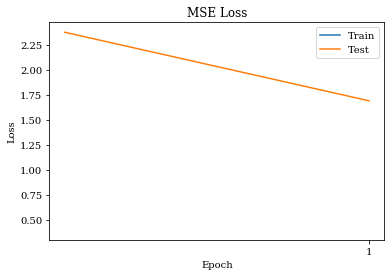











  0%|                                                                                                                                                                    | 0/136050 [00:00<?, ?it/s]









  0%|                                                                                                                                                          | 1/136050 [00:00<7:09:40,  5.28it/s]









  0%|                                                                                                                                                         | 17/136050 [00:00<5:05:12,  7.43it/s]

Train Epoch: 2 [0/4353569 (0%)]	Loss: 0.354111












  0%|                                                                                                                                                         | 33/136050 [00:00<3:38:06, 10.39it/s]









  0%|                                                                                                                                                         | 49/136050 [00:00<2:37:03, 14.43it/s]









  0%|                                                                                                                                                         | 65/136050 [00:00<1:54:20, 19.82it/s]









  0%|                                                                                                                                                         | 81/136050 [00:00<1:24:25, 26.84it/s]









  0%|                                                                                                                                                         | 96/136

Train Epoch: 2 [16000/4353569 (0%)]	Loss: 0.332353












  0%|▌                                                                                                                                                        | 534/136050 [00:03<15:13, 148.34it/s]









  0%|▌                                                                                                                                                        | 549/136050 [00:03<15:14, 148.09it/s]









  0%|▋                                                                                                                                                        | 564/136050 [00:03<15:34, 144.91it/s]









  0%|▋                                                                                                                                                        | 580/136050 [00:04<15:23, 146.68it/s]









  0%|▋                                                                                                                                                        | 596/13

Train Epoch: 2 [32000/4353569 (1%)]	Loss: 0.379463












  1%|█▏                                                                                                                                                      | 1039/136050 [00:07<15:00, 149.99it/s]









  1%|█▏                                                                                                                                                      | 1055/136050 [00:07<15:02, 149.56it/s]









  1%|█▏                                                                                                                                                      | 1071/136050 [00:07<14:54, 150.95it/s]









  1%|█▏                                                                                                                                                      | 1087/136050 [00:07<14:45, 152.36it/s]









  1%|█▏                                                                                                                                                      | 1103/13

Train Epoch: 2 [48000/4353569 (1%)]	Loss: 0.341575












  1%|█▋                                                                                                                                                      | 1541/136050 [00:10<14:50, 151.05it/s]









  1%|█▋                                                                                                                                                      | 1557/136050 [00:10<14:42, 152.42it/s]









  1%|█▊                                                                                                                                                      | 1573/136050 [00:10<14:46, 151.67it/s]









  1%|█▊                                                                                                                                                      | 1589/136050 [00:10<14:54, 150.29it/s]









  1%|█▊                                                                                                                                                      | 1605/13

Train Epoch: 2 [64000/4353569 (1%)]	Loss: 0.377858












  1%|██▎                                                                                                                                                     | 2036/136050 [00:13<15:13, 146.76it/s]









  2%|██▎                                                                                                                                                     | 2051/136050 [00:13<15:17, 146.10it/s]









  2%|██▎                                                                                                                                                     | 2067/136050 [00:14<15:07, 147.64it/s]









  2%|██▎                                                                                                                                                     | 2083/136050 [00:14<14:55, 149.56it/s]









  2%|██▎                                                                                                                                                     | 2099/13

Train Epoch: 2 [80000/4353569 (2%)]	Loss: 0.348251












  2%|██▊                                                                                                                                                     | 2529/136050 [00:17<15:03, 147.85it/s]









  2%|██▊                                                                                                                                                     | 2545/136050 [00:17<14:56, 148.89it/s]









  2%|██▊                                                                                                                                                     | 2560/136050 [00:17<15:04, 147.57it/s]









  2%|██▉                                                                                                                                                     | 2576/136050 [00:17<14:50, 149.95it/s]









  2%|██▉                                                                                                                                                     | 2592/13

Train Epoch: 2 [96000/4353569 (2%)]	Loss: 0.373137












  2%|███▍                                                                                                                                                    | 3037/136050 [00:20<14:53, 148.84it/s]









  2%|███▍                                                                                                                                                    | 3053/136050 [00:20<14:44, 150.41it/s]









  2%|███▍                                                                                                                                                    | 3069/136050 [00:20<14:44, 150.27it/s]









  2%|███▍                                                                                                                                                    | 3085/136050 [00:20<14:45, 150.18it/s]









  2%|███▍                                                                                                                                                    | 3101/13

Train Epoch: 2 [112000/4353569 (3%)]	Loss: 0.428075












  3%|███▉                                                                                                                                                    | 3538/136050 [00:23<14:48, 149.18it/s]









  3%|███▉                                                                                                                                                    | 3553/136050 [00:23<14:48, 149.06it/s]









  3%|███▉                                                                                                                                                    | 3568/136050 [00:24<14:49, 149.01it/s]









  3%|████                                                                                                                                                    | 3583/136050 [00:24<14:49, 148.98it/s]









  3%|████                                                                                                                                                    | 3598/13

Train Epoch: 2 [128000/4353569 (3%)]	Loss: 0.425509












  3%|████▌                                                                                                                                                   | 4038/136050 [00:27<14:28, 151.96it/s]









  3%|████▌                                                                                                                                                   | 4054/136050 [00:27<14:24, 152.64it/s]









  3%|████▌                                                                                                                                                   | 4070/136050 [00:27<14:20, 153.34it/s]









  3%|████▌                                                                                                                                                   | 4086/136050 [00:27<14:15, 154.29it/s]









  3%|████▌                                                                                                                                                   | 4102/13

Train Epoch: 2 [144000/4353569 (3%)]	Loss: 0.350963












  3%|█████                                                                                                                                                   | 4533/136050 [00:30<14:33, 150.54it/s]









  3%|█████                                                                                                                                                   | 4549/136050 [00:30<14:36, 149.95it/s]









  3%|█████                                                                                                                                                   | 4564/136050 [00:30<14:46, 148.30it/s]









  3%|█████                                                                                                                                                   | 4580/136050 [00:30<14:36, 150.04it/s]









  3%|█████▏                                                                                                                                                  | 4596/13

Train Epoch: 2 [160000/4353569 (4%)]	Loss: 0.295023












  4%|█████▋                                                                                                                                                  | 5039/136050 [00:33<14:45, 147.90it/s]









  4%|█████▋                                                                                                                                                  | 5054/136050 [00:33<14:54, 146.48it/s]









  4%|█████▋                                                                                                                                                  | 5070/136050 [00:34<14:40, 148.73it/s]









  4%|█████▋                                                                                                                                                  | 5086/136050 [00:34<14:31, 150.34it/s]









  4%|█████▋                                                                                                                                                  | 5102/13

Train Epoch: 2 [176000/4353569 (4%)]	Loss: 0.520458












  4%|██████▏                                                                                                                                                 | 5543/136050 [00:37<14:30, 149.98it/s]









  4%|██████▏                                                                                                                                                 | 5559/136050 [00:37<14:44, 147.50it/s]









  4%|██████▏                                                                                                                                                 | 5574/136050 [00:37<14:47, 147.04it/s]









  4%|██████▏                                                                                                                                                 | 5589/136050 [00:37<14:49, 146.73it/s]









  4%|██████▎                                                                                                                                                 | 5605/13

Train Epoch: 2 [192000/4353569 (4%)]	Loss: 0.326676












  4%|██████▋                                                                                                                                                 | 6041/136050 [00:40<14:25, 150.26it/s]









  4%|██████▊                                                                                                                                                 | 6057/136050 [00:40<14:31, 149.21it/s]









  4%|██████▊                                                                                                                                                 | 6072/136050 [00:40<14:42, 147.37it/s]









  4%|██████▊                                                                                                                                                 | 6088/136050 [00:40<14:32, 148.95it/s]









  4%|██████▊                                                                                                                                                 | 6104/13

Train Epoch: 2 [208000/4353569 (5%)]	Loss: 0.432440












  5%|███████▎                                                                                                                                                | 6542/136050 [00:43<14:37, 147.54it/s]









  5%|███████▎                                                                                                                                                | 6557/136050 [00:44<14:51, 145.17it/s]









  5%|███████▎                                                                                                                                                | 6572/136050 [00:44<14:47, 145.82it/s]









  5%|███████▎                                                                                                                                                | 6587/136050 [00:44<14:42, 146.74it/s]









  5%|███████▍                                                                                                                                                | 6602/13

Train Epoch: 2 [224000/4353569 (5%)]	Loss: 0.666507












  5%|███████▊                                                                                                                                                | 7044/136050 [00:47<14:17, 150.47it/s]









  5%|███████▉                                                                                                                                                | 7060/136050 [00:47<14:10, 151.58it/s]









  5%|███████▉                                                                                                                                                | 7076/136050 [00:47<14:06, 152.38it/s]









  5%|███████▉                                                                                                                                                | 7092/136050 [00:47<14:09, 151.87it/s]









  5%|███████▉                                                                                                                                                | 7108/13

Train Epoch: 2 [240000/4353569 (6%)]	Loss: 0.432652












  6%|████████▍                                                                                                                                               | 7542/136050 [00:50<14:30, 147.65it/s]









  6%|████████▍                                                                                                                                               | 7558/136050 [00:50<14:17, 149.85it/s]









  6%|████████▍                                                                                                                                               | 7574/136050 [00:50<14:06, 151.75it/s]









  6%|████████▍                                                                                                                                               | 7590/136050 [00:50<14:06, 151.67it/s]









  6%|████████▍                                                                                                                                               | 7606/13

Train Epoch: 2 [256000/4353569 (6%)]	Loss: 0.520471












  6%|████████▉                                                                                                                                               | 8036/136050 [00:53<14:09, 150.71it/s]









  6%|████████▉                                                                                                                                               | 8052/136050 [00:54<14:18, 149.17it/s]









  6%|█████████                                                                                                                                               | 8067/136050 [00:54<14:20, 148.65it/s]









  6%|█████████                                                                                                                                               | 8083/136050 [00:54<14:11, 150.29it/s]









  6%|█████████                                                                                                                                               | 8099/13

Train Epoch: 2 [272000/4353569 (6%)]	Loss: 0.418405


  6%|█████████▌                                                                                                                                              | 8532/136050 [00:57<14:21, 148.06it/s]









  6%|█████████▌                                                                                                                                              | 8547/136050 [00:57<14:19, 148.31it/s]









  6%|█████████▌                                                                                                                                              | 8563/136050 [00:57<14:12, 149.51it/s]









  6%|█████████▌                                                                                                                                              | 8578/136050 [00:57<14:13, 149.28it/s]









  6%|█████████▌                                                                                                                                              | 8593/136050 [00:5

Train Epoch: 2 [288000/4353569 (7%)]	Loss: 0.381119












  7%|██████████                                                                                                                                              | 9032/136050 [01:00<14:12, 148.92it/s]









  7%|██████████                                                                                                                                              | 9047/136050 [01:00<14:16, 148.33it/s]









  7%|██████████▏                                                                                                                                             | 9063/136050 [01:00<14:09, 149.45it/s]









  7%|██████████▏                                                                                                                                             | 9079/136050 [01:00<14:02, 150.71it/s]









  7%|██████████▏                                                                                                                                             | 9095/13

Train Epoch: 2 [304000/4353569 (7%)]	Loss: 0.332513


  7%|██████████▋                                                                                                                                             | 9531/136050 [01:03<13:51, 152.13it/s]









  7%|██████████▋                                                                                                                                             | 9547/136050 [01:04<14:04, 149.75it/s]









  7%|██████████▋                                                                                                                                             | 9563/136050 [01:04<13:57, 151.02it/s]









  7%|██████████▋                                                                                                                                             | 9579/136050 [01:04<13:51, 152.05it/s]









  7%|██████████▋                                                                                                                                             | 9595/136050 [01:0

Train Epoch: 2 [320000/4353569 (7%)]	Loss: 0.569958












  7%|███████████▏                                                                                                                                           | 10036/136050 [01:07<14:04, 149.23it/s]









  7%|███████████▏                                                                                                                                           | 10051/136050 [01:07<14:04, 149.16it/s]









  7%|███████████▏                                                                                                                                           | 10066/136050 [01:07<14:05, 149.08it/s]









  7%|███████████▏                                                                                                                                           | 10082/136050 [01:07<13:56, 150.51it/s]









  7%|███████████▏                                                                                                                                           | 10098/13

Train Epoch: 2 [336000/4353569 (8%)]	Loss: 0.389806


  8%|███████████▋                                                                                                                                           | 10530/136050 [01:10<13:46, 151.90it/s]









  8%|███████████▋                                                                                                                                           | 10546/136050 [01:10<13:49, 151.31it/s]









  8%|███████████▋                                                                                                                                           | 10562/136050 [01:10<14:08, 147.97it/s]









  8%|███████████▋                                                                                                                                           | 10578/136050 [01:10<13:57, 149.81it/s]









  8%|███████████▊                                                                                                                                           | 10594/136050 [01:1

Train Epoch: 2 [352000/4353569 (8%)]	Loss: 0.395226












  8%|████████████▏                                                                                                                                          | 11032/136050 [01:13<13:55, 149.62it/s]









  8%|████████████▎                                                                                                                                          | 11047/136050 [01:14<14:15, 146.07it/s]









  8%|████████████▎                                                                                                                                          | 11063/136050 [01:14<14:01, 148.44it/s]









  8%|████████████▎                                                                                                                                          | 11079/136050 [01:14<13:54, 149.71it/s]









  8%|████████████▎                                                                                                                                          | 11094/13

Train Epoch: 2 [368000/4353569 (8%)]	Loss: 0.459645


  8%|████████████▊                                                                                                                                          | 11527/136050 [01:17<14:08, 146.69it/s]









  8%|████████████▊                                                                                                                                          | 11542/136050 [01:17<14:29, 143.14it/s]









  8%|████████████▊                                                                                                                                          | 11557/136050 [01:17<14:30, 142.96it/s]









  9%|████████████▊                                                                                                                                          | 11573/136050 [01:17<14:12, 146.10it/s]









  9%|████████████▊                                                                                                                                          | 11588/136050 [01:1

Train Epoch: 2 [384000/4353569 (9%)]	Loss: 0.376973


  9%|█████████████▎                                                                                                                                         | 12028/136050 [01:20<13:49, 149.48it/s]









  9%|█████████████▎                                                                                                                                         | 12043/136050 [01:20<14:05, 146.59it/s]









  9%|█████████████▍                                                                                                                                         | 12058/136050 [01:20<14:01, 147.28it/s]









  9%|█████████████▍                                                                                                                                         | 12073/136050 [01:20<14:18, 144.48it/s]









  9%|█████████████▍                                                                                                                                         | 12088/136050 [01:2

Train Epoch: 2 [400000/4353569 (9%)]	Loss: 0.340078


  9%|█████████████▉                                                                                                                                         | 12528/136050 [01:24<13:51, 148.58it/s]









  9%|█████████████▉                                                                                                                                         | 12543/136050 [01:24<13:51, 148.61it/s]









  9%|█████████████▉                                                                                                                                         | 12558/136050 [01:24<13:50, 148.70it/s]









  9%|█████████████▉                                                                                                                                         | 12574/136050 [01:24<13:46, 149.48it/s]









  9%|█████████████▉                                                                                                                                         | 12590/136050 [01:2

Train Epoch: 2 [416000/4353569 (10%)]	Loss: 0.343932












 10%|██████████████▍                                                                                                                                        | 13044/136050 [01:27<13:37, 150.44it/s]









 10%|██████████████▍                                                                                                                                        | 13060/136050 [01:27<13:47, 148.62it/s]









 10%|██████████████▌                                                                                                                                        | 13075/136050 [01:27<13:49, 148.27it/s]









 10%|██████████████▌                                                                                                                                        | 13091/136050 [01:27<13:38, 150.31it/s]









 10%|██████████████▌                                                                                                                                        | 13107/13

Train Epoch: 2 [432000/4353569 (10%)]	Loss: 0.477184












 10%|███████████████                                                                                                                                        | 13533/136050 [01:30<13:25, 152.13it/s]









 10%|███████████████                                                                                                                                        | 13549/136050 [01:30<13:40, 149.31it/s]









 10%|███████████████                                                                                                                                        | 13564/136050 [01:30<13:40, 149.20it/s]









 10%|███████████████                                                                                                                                        | 13579/136050 [01:31<13:45, 148.40it/s]









 10%|███████████████                                                                                                                                        | 13595/13

Train Epoch: 2 [448000/4353569 (10%)]	Loss: 0.569212












 10%|███████████████▌                                                                                                                                       | 14033/136050 [01:34<13:33, 149.90it/s]









 10%|███████████████▌                                                                                                                                       | 14049/136050 [01:34<13:24, 151.61it/s]









 10%|███████████████▌                                                                                                                                       | 14065/136050 [01:34<13:24, 151.53it/s]









 10%|███████████████▋                                                                                                                                       | 14081/136050 [01:34<13:36, 149.36it/s]









 10%|███████████████▋                                                                                                                                       | 14097/13

Train Epoch: 2 [464000/4353569 (11%)]	Loss: 0.393708












 11%|████████████████▏                                                                                                                                      | 14539/136050 [01:37<13:48, 146.66it/s]









 11%|████████████████▏                                                                                                                                      | 14554/136050 [01:37<14:01, 144.37it/s]









 11%|████████████████▏                                                                                                                                      | 14569/136050 [01:37<13:58, 144.86it/s]









 11%|████████████████▏                                                                                                                                      | 14584/136050 [01:37<13:56, 145.21it/s]









 11%|████████████████▏                                                                                                                                      | 14599/13

Train Epoch: 2 [480000/4353569 (11%)]	Loss: 0.371937












 11%|████████████████▋                                                                                                                                      | 15033/136050 [01:40<13:42, 147.11it/s]









 11%|████████████████▋                                                                                                                                      | 15049/136050 [01:40<13:33, 148.75it/s]









 11%|████████████████▋                                                                                                                                      | 15065/136050 [01:41<13:31, 149.10it/s]









 11%|████████████████▋                                                                                                                                      | 15080/136050 [01:41<13:31, 149.02it/s]









 11%|████████████████▊                                                                                                                                      | 15095/13

Train Epoch: 2 [496000/4353569 (11%)]	Loss: 0.406530












 11%|█████████████████▏                                                                                                                                     | 15535/136050 [01:44<13:43, 146.36it/s]









 11%|█████████████████▎                                                                                                                                     | 15550/136050 [01:44<13:39, 147.12it/s]









 11%|█████████████████▎                                                                                                                                     | 15565/136050 [01:44<13:55, 144.25it/s]









 11%|█████████████████▎                                                                                                                                     | 15581/136050 [01:44<13:45, 145.91it/s]









 11%|█████████████████▎                                                                                                                                     | 15597/13

Train Epoch: 2 [512000/4353569 (12%)]	Loss: 0.341975












 12%|█████████████████▊                                                                                                                                     | 16039/136050 [01:47<13:42, 145.85it/s]









 12%|█████████████████▊                                                                                                                                     | 16054/136050 [01:47<13:49, 144.64it/s]









 12%|█████████████████▊                                                                                                                                     | 16069/136050 [01:47<14:01, 142.59it/s]









 12%|█████████████████▊                                                                                                                                     | 16084/136050 [01:47<13:53, 144.00it/s]









 12%|█████████████████▊                                                                                                                                     | 16099/13

Train Epoch: 2 [528000/4353569 (12%)]	Loss: 0.387072












 12%|██████████████████▎                                                                                                                                    | 16538/136050 [01:51<13:31, 147.20it/s]









 12%|██████████████████▎                                                                                                                                    | 16554/136050 [01:51<13:22, 148.82it/s]









 12%|██████████████████▍                                                                                                                                    | 16569/136050 [01:51<13:32, 147.10it/s]









 12%|██████████████████▍                                                                                                                                    | 16584/136050 [01:51<13:31, 147.21it/s]









 12%|██████████████████▍                                                                                                                                    | 16600/13

Train Epoch: 2 [544000/4353569 (12%)]	Loss: 0.485176












 13%|██████████████████▉                                                                                                                                    | 17040/136050 [01:54<13:18, 149.10it/s]









 13%|██████████████████▉                                                                                                                                    | 17056/136050 [01:54<13:12, 150.20it/s]









 13%|██████████████████▉                                                                                                                                    | 17072/136050 [01:54<13:08, 150.96it/s]









 13%|██████████████████▉                                                                                                                                    | 17088/136050 [01:54<13:02, 151.94it/s]









 13%|██████████████████▉                                                                                                                                    | 17104/13

Train Epoch: 2 [560000/4353569 (13%)]	Loss: 0.418446












 13%|███████████████████▍                                                                                                                                   | 17545/136050 [01:57<13:06, 150.61it/s]









 13%|███████████████████▍                                                                                                                                   | 17561/136050 [01:57<13:09, 150.09it/s]









 13%|███████████████████▌                                                                                                                                   | 17577/136050 [01:58<13:16, 148.77it/s]









 13%|███████████████████▌                                                                                                                                   | 17592/136050 [01:58<13:16, 148.64it/s]









 13%|███████████████████▌                                                                                                                                   | 17607/13

Train Epoch: 2 [576000/4353569 (13%)]	Loss: 0.358992












 13%|████████████████████                                                                                                                                   | 18042/136050 [02:01<13:29, 145.84it/s]









 13%|████████████████████                                                                                                                                   | 18057/136050 [02:01<13:24, 146.74it/s]









 13%|████████████████████                                                                                                                                   | 18072/136050 [02:01<13:28, 145.88it/s]









 13%|████████████████████                                                                                                                                   | 18088/136050 [02:01<13:17, 147.88it/s]









 13%|████████████████████                                                                                                                                   | 18103/13

Train Epoch: 2 [592000/4353569 (14%)]	Loss: 0.342327












 14%|████████████████████▌                                                                                                                                  | 18536/136050 [02:04<13:24, 146.06it/s]









 14%|████████████████████▌                                                                                                                                  | 18552/136050 [02:04<13:13, 148.03it/s]









 14%|████████████████████▌                                                                                                                                  | 18567/136050 [02:04<13:21, 146.55it/s]









 14%|████████████████████▋                                                                                                                                  | 18583/136050 [02:04<13:12, 148.28it/s]









 14%|████████████████████▋                                                                                                                                  | 18598/13

Train Epoch: 2 [608000/4353569 (14%)]	Loss: 0.337523












 14%|█████████████████████▏                                                                                                                                 | 19038/136050 [02:07<12:57, 150.56it/s]









 14%|█████████████████████▏                                                                                                                                 | 19054/136050 [02:07<12:52, 151.49it/s]









 14%|█████████████████████▏                                                                                                                                 | 19070/136050 [02:08<12:58, 150.17it/s]









 14%|█████████████████████▏                                                                                                                                 | 19086/136050 [02:08<12:57, 150.50it/s]









 14%|█████████████████████▏                                                                                                                                 | 19102/13

Train Epoch: 2 [624000/4353569 (14%)]	Loss: 0.329359












 14%|█████████████████████▋                                                                                                                                 | 19541/136050 [02:11<12:59, 149.53it/s]









 14%|█████████████████████▋                                                                                                                                 | 19556/136050 [02:11<13:00, 149.34it/s]









 14%|█████████████████████▋                                                                                                                                 | 19571/136050 [02:11<13:07, 147.89it/s]









 14%|█████████████████████▋                                                                                                                                 | 19587/136050 [02:11<12:59, 149.33it/s]









 14%|█████████████████████▊                                                                                                                                 | 19603/13

Train Epoch: 2 [640000/4353569 (15%)]	Loss: 0.358126












 15%|██████████████████████▏                                                                                                                                | 20039/136050 [02:14<13:24, 144.27it/s]









 15%|██████████████████████▎                                                                                                                                | 20055/136050 [02:14<13:10, 146.74it/s]









 15%|██████████████████████▎                                                                                                                                | 20071/136050 [02:14<13:05, 147.69it/s]









 15%|██████████████████████▎                                                                                                                                | 20086/136050 [02:14<13:05, 147.62it/s]









 15%|██████████████████████▎                                                                                                                                | 20101/13

Train Epoch: 2 [656000/4353569 (15%)]	Loss: 0.332036












 15%|██████████████████████▊                                                                                                                                | 20529/136050 [02:17<13:07, 146.77it/s]









 15%|██████████████████████▊                                                                                                                                | 20545/136050 [02:18<12:57, 148.52it/s]









 15%|██████████████████████▊                                                                                                                                | 20561/136050 [02:18<12:55, 148.95it/s]









 15%|██████████████████████▊                                                                                                                                | 20577/136050 [02:18<12:47, 150.47it/s]









 15%|██████████████████████▊                                                                                                                                | 20593/13

Train Epoch: 2 [672000/4353569 (15%)]	Loss: 0.449309












 15%|███████████████████████▎                                                                                                                               | 21031/136050 [02:21<13:00, 147.29it/s]









 15%|███████████████████████▎                                                                                                                               | 21046/136050 [02:21<13:07, 146.06it/s]









 15%|███████████████████████▍                                                                                                                               | 21062/136050 [02:21<12:55, 148.36it/s]









 15%|███████████████████████▍                                                                                                                               | 21078/136050 [02:21<12:48, 149.65it/s]









 16%|███████████████████████▍                                                                                                                               | 21094/13

Train Epoch: 2 [688000/4353569 (16%)]	Loss: 0.430723












 16%|███████████████████████▉                                                                                                                               | 21532/136050 [02:24<12:55, 147.69it/s]









 16%|███████████████████████▉                                                                                                                               | 21547/136050 [02:24<12:58, 147.17it/s]









 16%|███████████████████████▉                                                                                                                               | 21563/136050 [02:24<12:45, 149.64it/s]









 16%|███████████████████████▉                                                                                                                               | 21578/136050 [02:24<12:48, 148.90it/s]









 16%|███████████████████████▉                                                                                                                               | 21593/13

Train Epoch: 2 [704000/4353569 (16%)]	Loss: 0.416407












 16%|████████████████████████▍                                                                                                                              | 22040/136050 [02:28<12:40, 149.86it/s]









 16%|████████████████████████▍                                                                                                                              | 22055/136050 [02:28<12:51, 147.81it/s]









 16%|████████████████████████▍                                                                                                                              | 22071/136050 [02:28<12:52, 147.62it/s]









 16%|████████████████████████▌                                                                                                                              | 22086/136050 [02:28<13:19, 142.51it/s]









 16%|████████████████████████▌                                                                                                                              | 22101/13

Train Epoch: 2 [720000/4353569 (17%)]	Loss: 0.429828


 17%|█████████████████████████                                                                                                                              | 22528/136050 [02:31<12:54, 146.51it/s]









 17%|█████████████████████████                                                                                                                              | 22544/136050 [02:31<12:47, 147.93it/s]









 17%|█████████████████████████                                                                                                                              | 22559/136050 [02:31<12:45, 148.21it/s]









 17%|█████████████████████████                                                                                                                              | 22575/136050 [02:31<12:43, 148.72it/s]









 17%|█████████████████████████                                                                                                                              | 22591/136050 [02:3

 17%|█████████████████████████▌                                                                                                                             | 23024/136050 [02:35<13:09, 143.11it/s]

Train Epoch: 2 [736000/4353569 (17%)]	Loss: 0.370139












 17%|█████████████████████████▌                                                                                                                             | 23039/136050 [02:35<13:18, 141.61it/s]









 17%|█████████████████████████▌                                                                                                                             | 23054/136050 [02:35<13:17, 141.67it/s]









 17%|█████████████████████████▌                                                                                                                             | 23069/136050 [02:35<13:23, 140.61it/s]









 17%|█████████████████████████▌                                                                                                                             | 23085/136050 [02:35<13:03, 144.13it/s]









 17%|█████████████████████████▋                                                                                                                             | 23100/13

Train Epoch: 2 [752000/4353569 (17%)]	Loss: 0.370764












 17%|██████████████████████████                                                                                                                             | 23534/136050 [02:38<12:50, 146.12it/s]









 17%|██████████████████████████▏                                                                                                                            | 23549/136050 [02:38<12:56, 144.83it/s]









 17%|██████████████████████████▏                                                                                                                            | 23565/136050 [02:38<12:48, 146.32it/s]









 17%|██████████████████████████▏                                                                                                                            | 23580/136050 [02:38<12:54, 145.25it/s]









 17%|██████████████████████████▏                                                                                                                            | 23596/13

Train Epoch: 2 [768000/4353569 (18%)]	Loss: 0.330556












 18%|██████████████████████████▋                                                                                                                            | 24035/136050 [02:41<12:33, 148.67it/s]









 18%|██████████████████████████▋                                                                                                                            | 24050/136050 [02:41<12:37, 147.79it/s]









 18%|██████████████████████████▋                                                                                                                            | 24065/136050 [02:42<12:49, 145.56it/s]









 18%|██████████████████████████▋                                                                                                                            | 24080/136050 [02:42<12:46, 146.11it/s]









 18%|██████████████████████████▋                                                                                                                            | 24096/13

Train Epoch: 2 [784000/4353569 (18%)]	Loss: 0.427490












 18%|███████████████████████████▏                                                                                                                           | 24531/136050 [02:45<12:37, 147.15it/s]









 18%|███████████████████████████▏                                                                                                                           | 24547/136050 [02:45<12:29, 148.80it/s]









 18%|███████████████████████████▎                                                                                                                           | 24562/136050 [02:45<12:31, 148.39it/s]









 18%|███████████████████████████▎                                                                                                                           | 24577/136050 [02:45<12:32, 148.11it/s]









 18%|███████████████████████████▎                                                                                                                           | 24593/13

Train Epoch: 2 [800000/4353569 (18%)]	Loss: 0.371519












 18%|███████████████████████████▊                                                                                                                           | 25041/136050 [02:48<12:39, 146.08it/s]









 18%|███████████████████████████▊                                                                                                                           | 25056/136050 [02:48<12:34, 147.13it/s]









 18%|███████████████████████████▊                                                                                                                           | 25072/136050 [02:48<12:24, 149.06it/s]









 18%|███████████████████████████▊                                                                                                                           | 25088/136050 [02:48<12:16, 150.60it/s]









 18%|███████████████████████████▊                                                                                                                           | 25104/13

Train Epoch: 2 [816000/4353569 (19%)]	Loss: 0.281368












 19%|████████████████████████████▎                                                                                                                          | 25544/136050 [02:52<12:28, 147.70it/s]









 19%|████████████████████████████▎                                                                                                                          | 25559/136050 [02:52<12:28, 147.62it/s]









 19%|████████████████████████████▍                                                                                                                          | 25574/136050 [02:52<12:30, 147.13it/s]









 19%|████████████████████████████▍                                                                                                                          | 25589/136050 [02:52<12:33, 146.60it/s]









 19%|████████████████████████████▍                                                                                                                          | 25605/13

Train Epoch: 2 [832000/4353569 (19%)]	Loss: 0.473353












 19%|████████████████████████████▉                                                                                                                          | 26043/136050 [02:55<12:32, 146.16it/s]









 19%|████████████████████████████▉                                                                                                                          | 26059/136050 [02:55<12:22, 148.09it/s]









 19%|████████████████████████████▉                                                                                                                          | 26074/136050 [02:55<12:32, 146.17it/s]









 19%|████████████████████████████▉                                                                                                                          | 26089/136050 [02:55<12:52, 142.38it/s]









 19%|████████████████████████████▉                                                                                                                          | 26105/13

Train Epoch: 2 [848000/4353569 (19%)]	Loss: 0.375090












 20%|█████████████████████████████▍                                                                                                                         | 26535/136050 [02:58<12:27, 146.56it/s]









 20%|█████████████████████████████▍                                                                                                                         | 26550/136050 [02:58<12:25, 146.83it/s]









 20%|█████████████████████████████▍                                                                                                                         | 26565/136050 [02:58<12:22, 147.45it/s]









 20%|█████████████████████████████▌                                                                                                                         | 26580/136050 [02:59<12:22, 147.45it/s]









 20%|█████████████████████████████▌                                                                                                                         | 26595/13

Train Epoch: 2 [864000/4353569 (20%)]	Loss: 0.458230












 20%|██████████████████████████████                                                                                                                         | 27041/136050 [03:02<12:19, 147.42it/s]









 20%|██████████████████████████████                                                                                                                         | 27056/136050 [03:02<12:19, 147.43it/s]









 20%|██████████████████████████████                                                                                                                         | 27071/136050 [03:02<12:19, 147.45it/s]









 20%|██████████████████████████████                                                                                                                         | 27086/136050 [03:02<12:23, 146.58it/s]









 20%|██████████████████████████████                                                                                                                         | 27102/13

Train Epoch: 2 [880000/4353569 (20%)]	Loss: 0.303007












 20%|██████████████████████████████▌                                                                                                                        | 27530/136050 [03:05<12:09, 148.80it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27545/136050 [03:05<12:32, 144.18it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27560/136050 [03:05<12:31, 144.30it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27575/136050 [03:05<12:26, 145.23it/s]









 20%|██████████████████████████████▌                                                                                                                        | 27591/13

Train Epoch: 2 [896000/4353569 (21%)]	Loss: 0.358633












 21%|███████████████████████████████                                                                                                                        | 28040/136050 [03:08<12:23, 145.27it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28055/136050 [03:09<12:35, 143.01it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28070/136050 [03:09<12:34, 143.08it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28086/136050 [03:09<12:26, 144.64it/s]









 21%|███████████████████████████████▏                                                                                                                       | 28102/13

Train Epoch: 2 [912000/4353569 (21%)]	Loss: 0.452655












 21%|███████████████████████████████▋                                                                                                                       | 28534/136050 [03:12<11:56, 149.97it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28550/136050 [03:12<11:58, 149.54it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28565/136050 [03:12<12:06, 148.03it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28580/136050 [03:12<12:08, 147.51it/s]









 21%|███████████████████████████████▋                                                                                                                       | 28595/13

Train Epoch: 2 [928000/4353569 (21%)]	Loss: 0.366610


 21%|████████████████████████████████▏                                                                                                                      | 29029/136050 [03:15<11:54, 149.88it/s]









 21%|████████████████████████████████▏                                                                                                                      | 29044/136050 [03:15<11:59, 148.69it/s]









 21%|████████████████████████████████▎                                                                                                                      | 29059/136050 [03:15<12:01, 148.32it/s]









 21%|████████████████████████████████▎                                                                                                                      | 29074/136050 [03:15<12:04, 147.62it/s]









 21%|████████████████████████████████▎                                                                                                                      | 29089/136050 [03:1

Train Epoch: 2 [944000/4353569 (22%)]	Loss: 0.496078












 22%|████████████████████████████████▊                                                                                                                      | 29535/136050 [03:19<12:02, 147.44it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29550/136050 [03:19<12:04, 147.01it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29566/136050 [03:19<11:54, 149.11it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29581/136050 [03:19<11:58, 148.17it/s]









 22%|████████████████████████████████▊                                                                                                                      | 29597/13

Train Epoch: 2 [960000/4353569 (22%)]	Loss: 0.416783












 22%|█████████████████████████████████▎                                                                                                                     | 30044/136050 [03:22<11:42, 150.82it/s]









 22%|█████████████████████████████████▎                                                                                                                     | 30060/136050 [03:22<11:41, 151.09it/s]









 22%|█████████████████████████████████▍                                                                                                                     | 30076/136050 [03:22<11:43, 150.74it/s]









 22%|█████████████████████████████████▍                                                                                                                     | 30092/136050 [03:22<11:40, 151.34it/s]









 22%|█████████████████████████████████▍                                                                                                                     | 30108/13

Train Epoch: 2 [976000/4353569 (22%)]	Loss: 0.435962


 22%|█████████████████████████████████▉                                                                                                                     | 30528/136050 [03:25<11:42, 150.14it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30544/136050 [03:25<11:39, 150.94it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30560/136050 [03:25<11:46, 149.28it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30575/136050 [03:26<11:56, 147.30it/s]









 22%|█████████████████████████████████▉                                                                                                                     | 30590/136050 [03:2

Train Epoch: 2 [992000/4353569 (23%)]	Loss: 0.500285












 23%|██████████████████████████████████▍                                                                                                                    | 31040/136050 [03:29<11:49, 148.07it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31056/136050 [03:29<11:46, 148.62it/s]









 23%|██████████████████████████████████▍                                                                                                                    | 31071/136050 [03:29<11:54, 146.97it/s]









 23%|██████████████████████████████████▌                                                                                                                    | 31087/136050 [03:29<11:46, 148.62it/s]









 23%|██████████████████████████████████▌                                                                                                                    | 31102/13

Train Epoch: 2 [1008000/4353569 (23%)]	Loss: 0.432399












 23%|██████████████████████████████████▉                                                                                                                    | 31534/136050 [03:32<11:51, 146.97it/s]









 23%|███████████████████████████████████                                                                                                                    | 31550/136050 [03:32<11:44, 148.25it/s]









 23%|███████████████████████████████████                                                                                                                    | 31565/136050 [03:32<12:01, 144.91it/s]









 23%|███████████████████████████████████                                                                                                                    | 31581/136050 [03:32<11:49, 147.19it/s]









 23%|███████████████████████████████████                                                                                                                    | 31596/13

Train Epoch: 2 [1024000/4353569 (24%)]	Loss: 0.273891












 24%|███████████████████████████████████▌                                                                                                                   | 32040/136050 [03:36<11:54, 145.53it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32056/136050 [03:36<11:44, 147.63it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32072/136050 [03:36<11:35, 149.56it/s]









 24%|███████████████████████████████████▌                                                                                                                   | 32087/136050 [03:36<11:38, 148.92it/s]









 24%|███████████████████████████████████▋                                                                                                                   | 32102/13

Train Epoch: 2 [1040000/4353569 (24%)]	Loss: 0.427899












 24%|████████████████████████████████████                                                                                                                   | 32530/136050 [03:39<11:38, 148.27it/s]









 24%|████████████████████████████████████                                                                                                                   | 32545/136050 [03:39<11:51, 145.45it/s]









 24%|████████████████████████████████████▏                                                                                                                  | 32561/136050 [03:39<11:41, 147.46it/s]









 24%|████████████████████████████████████▏                                                                                                                  | 32576/136050 [03:39<11:39, 147.89it/s]









 24%|████████████████████████████████████▏                                                                                                                  | 32592/13

Train Epoch: 2 [1056000/4353569 (24%)]	Loss: 0.338697












 24%|████████████████████████████████████▋                                                                                                                  | 33039/136050 [03:42<11:35, 148.17it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33054/136050 [03:42<11:46, 145.79it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33070/136050 [03:42<11:34, 148.18it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33086/136050 [03:43<11:30, 149.11it/s]









 24%|████████████████████████████████████▋                                                                                                                  | 33101/13

Train Epoch: 2 [1072000/4353569 (25%)]	Loss: 0.285239












 25%|█████████████████████████████████████▏                                                                                                                 | 33534/136050 [03:46<11:40, 146.38it/s]









 25%|█████████████████████████████████████▏                                                                                                                 | 33550/136050 [03:46<11:32, 148.07it/s]









 25%|█████████████████████████████████████▎                                                                                                                 | 33566/136050 [03:46<11:23, 149.89it/s]









 25%|█████████████████████████████████████▎                                                                                                                 | 33582/136050 [03:46<11:19, 150.75it/s]









 25%|█████████████████████████████████████▎                                                                                                                 | 33598/13

Train Epoch: 2 [1088000/4353569 (25%)]	Loss: 0.344129












 25%|█████████████████████████████████████▊                                                                                                                 | 34043/136050 [03:49<11:20, 149.80it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34059/136050 [03:49<11:18, 150.26it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34075/136050 [03:49<11:19, 150.13it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34091/136050 [03:49<11:14, 151.16it/s]









 25%|█████████████████████████████████████▊                                                                                                                 | 34107/13

Train Epoch: 2 [1104000/4353569 (25%)]	Loss: 0.299357


 25%|██████████████████████████████████████▎                                                                                                                | 34530/136050 [03:52<11:24, 148.39it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34546/136050 [03:52<11:19, 149.45it/s]









 25%|██████████████████████████████████████▎                                                                                                                | 34561/136050 [03:53<11:29, 147.10it/s]









 25%|██████████████████████████████████████▍                                                                                                                | 34577/136050 [03:53<11:18, 149.60it/s]









 25%|██████████████████████████████████████▍                                                                                                                | 34593/136050 [03:5

Train Epoch: 2 [1120000/4353569 (26%)]	Loss: 0.388043












 26%|██████████████████████████████████████▉                                                                                                                | 35039/136050 [03:56<11:35, 145.34it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35054/136050 [03:56<11:29, 146.39it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35070/136050 [03:56<11:24, 147.44it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35086/136050 [03:56<11:15, 149.43it/s]









 26%|██████████████████████████████████████▉                                                                                                                | 35102/13

Train Epoch: 2 [1136000/4353569 (26%)]	Loss: 0.446614












 26%|███████████████████████████████████████▍                                                                                                               | 35541/136050 [03:59<11:26, 146.42it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35556/136050 [03:59<11:22, 147.16it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35571/136050 [03:59<11:28, 145.96it/s]









 26%|███████████████████████████████████████▍                                                                                                               | 35586/136050 [03:59<11:24, 146.84it/s]









 26%|███████████████████████████████████████▌                                                                                                               | 35602/13

Train Epoch: 2 [1152000/4353569 (26%)]	Loss: 0.476109












 26%|████████████████████████████████████████                                                                                                               | 36043/136050 [04:02<11:20, 146.98it/s]









 27%|████████████████████████████████████████                                                                                                               | 36059/136050 [04:03<11:10, 149.09it/s]









 27%|████████████████████████████████████████                                                                                                               | 36074/136050 [04:03<11:27, 145.35it/s]









 27%|████████████████████████████████████████                                                                                                               | 36089/136050 [04:03<11:29, 144.96it/s]









 27%|████████████████████████████████████████                                                                                                               | 36104/13

Train Epoch: 2 [1168000/4353569 (27%)]	Loss: 0.479058


 27%|████████████████████████████████████████▌                                                                                                              | 36530/136050 [04:06<11:15, 147.25it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36546/136050 [04:06<11:10, 148.46it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36561/136050 [04:06<11:12, 147.95it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36576/136050 [04:06<11:26, 144.80it/s]









 27%|████████████████████████████████████████▌                                                                                                              | 36591/136050 [04:0

Train Epoch: 2 [1184000/4353569 (27%)]	Loss: 0.404210












 27%|█████████████████████████████████████████                                                                                                              | 37038/136050 [04:09<12:00, 137.47it/s]









 27%|█████████████████████████████████████████                                                                                                              | 37053/136050 [04:09<11:49, 139.53it/s]









 27%|█████████████████████████████████████████▏                                                                                                             | 37069/136050 [04:10<11:30, 143.36it/s]









 27%|█████████████████████████████████████████▏                                                                                                             | 37085/136050 [04:10<11:19, 145.65it/s]









 27%|█████████████████████████████████████████▏                                                                                                             | 37100/13

Train Epoch: 2 [1200000/4353569 (28%)]	Loss: 0.419223












 28%|█████████████████████████████████████████▋                                                                                                             | 37534/136050 [04:13<12:04, 135.96it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37548/136050 [04:13<11:59, 136.86it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37562/136050 [04:13<12:08, 135.11it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37577/136050 [04:13<11:50, 138.67it/s]









 28%|█████████████████████████████████████████▋                                                                                                             | 37592/13

Train Epoch: 2 [1216000/4353569 (28%)]	Loss: 0.301065












 28%|██████████████████████████████████████████▏                                                                                                            | 38037/136050 [04:16<10:57, 149.06it/s]









 28%|██████████████████████████████████████████▏                                                                                                            | 38053/136050 [04:16<10:54, 149.74it/s]









 28%|██████████████████████████████████████████▎                                                                                                            | 38068/136050 [04:17<10:59, 148.60it/s]









 28%|██████████████████████████████████████████▎                                                                                                            | 38083/136050 [04:17<11:03, 147.64it/s]









 28%|██████████████████████████████████████████▎                                                                                                            | 38099/13

Train Epoch: 2 [1232000/4353569 (28%)]	Loss: 0.552030












 28%|██████████████████████████████████████████▊                                                                                                            | 38541/136050 [04:20<11:14, 144.58it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38556/136050 [04:20<11:08, 145.85it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38571/136050 [04:20<11:15, 144.23it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38586/136050 [04:20<11:16, 144.08it/s]









 28%|██████████████████████████████████████████▊                                                                                                            | 38602/13

Train Epoch: 2 [1248000/4353569 (29%)]	Loss: 0.447601












 29%|███████████████████████████████████████████▎                                                                                                           | 39042/136050 [04:23<11:06, 145.53it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39057/136050 [04:23<11:01, 146.54it/s]









 29%|███████████████████████████████████████████▎                                                                                                           | 39072/136050 [04:23<11:08, 145.11it/s]









 29%|███████████████████████████████████████████▍                                                                                                           | 39088/136050 [04:24<10:56, 147.73it/s]









 29%|███████████████████████████████████████████▍                                                                                                           | 39103/13

Train Epoch: 2 [1264000/4353569 (29%)]	Loss: 0.400877












 29%|███████████████████████████████████████████▉                                                                                                           | 39535/136050 [04:27<10:54, 147.40it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39551/136050 [04:27<10:45, 149.40it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39567/136050 [04:27<10:39, 150.98it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39583/136050 [04:27<10:44, 149.59it/s]









 29%|███████████████████████████████████████████▉                                                                                                           | 39598/13

Train Epoch: 2 [1280000/4353569 (29%)]	Loss: 0.436858












 29%|████████████████████████████████████████████▍                                                                                                          | 40033/136050 [04:30<10:53, 147.00it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40048/136050 [04:30<11:15, 142.13it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40063/136050 [04:30<11:09, 143.28it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40078/136050 [04:30<11:11, 142.87it/s]









 29%|████████████████████████████████████████████▍                                                                                                          | 40093/13

Train Epoch: 2 [1296000/4353569 (30%)]	Loss: 0.339550












 30%|████████████████████████████████████████████▉                                                                                                          | 40538/136050 [04:33<10:50, 146.92it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40553/136050 [04:34<10:47, 147.51it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40569/136050 [04:34<10:38, 149.51it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40584/136050 [04:34<10:45, 147.87it/s]









 30%|█████████████████████████████████████████████                                                                                                          | 40599/13

Train Epoch: 2 [1312000/4353569 (30%)]	Loss: 0.277226












 30%|█████████████████████████████████████████████▌                                                                                                         | 41038/136050 [04:37<10:36, 149.24it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41053/136050 [04:37<10:40, 148.26it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41068/136050 [04:37<10:49, 146.29it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41084/136050 [04:37<10:39, 148.60it/s]









 30%|█████████████████████████████████████████████▌                                                                                                         | 41099/13

Train Epoch: 2 [1328000/4353569 (31%)]	Loss: 0.332250












 31%|██████████████████████████████████████████████                                                                                                         | 41537/136050 [04:40<10:59, 143.42it/s]









 31%|██████████████████████████████████████████████                                                                                                         | 41552/136050 [04:40<11:14, 140.15it/s]









 31%|██████████████████████████████████████████████▏                                                                                                        | 41568/136050 [04:40<10:55, 144.12it/s]









 31%|██████████████████████████████████████████████▏                                                                                                        | 41584/136050 [04:41<10:46, 146.21it/s]









 31%|██████████████████████████████████████████████▏                                                                                                        | 41599/13

Train Epoch: 2 [1344000/4353569 (31%)]	Loss: 0.370322


 31%|██████████████████████████████████████████████▋                                                                                                        | 42028/136050 [04:44<10:37, 147.48it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42043/136050 [04:44<10:37, 147.44it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42058/136050 [04:44<10:37, 147.44it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42073/136050 [04:44<10:58, 142.82it/s]









 31%|██████████████████████████████████████████████▋                                                                                                        | 42088/136050 [04:4

Train Epoch: 2 [1360000/4353569 (31%)]	Loss: 0.362794












 31%|███████████████████████████████████████████████▏                                                                                                       | 42537/136050 [04:47<10:33, 147.58it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42552/136050 [04:47<10:35, 147.11it/s]









 31%|███████████████████████████████████████████████▏                                                                                                       | 42567/136050 [04:47<10:35, 147.19it/s]









 31%|███████████████████████████████████████████████▎                                                                                                       | 42582/136050 [04:47<10:47, 144.38it/s]









 31%|███████████████████████████████████████████████▎                                                                                                       | 42598/13

Train Epoch: 2 [1376000/4353569 (32%)]	Loss: 0.323510












 32%|███████████████████████████████████████████████▊                                                                                                       | 43039/136050 [04:51<10:45, 144.10it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43054/136050 [04:51<10:44, 144.26it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43070/136050 [04:51<10:29, 147.69it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43086/136050 [04:51<10:23, 149.19it/s]









 32%|███████████████████████████████████████████████▊                                                                                                       | 43101/13

Train Epoch: 2 [1392000/4353569 (32%)]	Loss: 0.281335












 32%|████████████████████████████████████████████████▎                                                                                                      | 43531/136050 [04:54<10:33, 145.95it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43546/136050 [04:54<10:31, 146.40it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43562/136050 [04:54<10:25, 147.85it/s]









 32%|████████████████████████████████████████████████▎                                                                                                      | 43578/136050 [04:54<10:19, 149.29it/s]









 32%|████████████████████████████████████████████████▍                                                                                                      | 43593/13

Train Epoch: 2 [1408000/4353569 (32%)]	Loss: 0.282601












 32%|████████████████████████████████████████████████▉                                                                                                      | 44042/136050 [04:57<10:13, 149.86it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44057/136050 [04:58<10:22, 147.81it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44073/136050 [04:58<10:13, 149.88it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44089/136050 [04:58<10:11, 150.48it/s]









 32%|████████████████████████████████████████████████▉                                                                                                      | 44105/13

Train Epoch: 2 [1424000/4353569 (33%)]	Loss: 0.446260












 33%|█████████████████████████████████████████████████▍                                                                                                     | 44535/136050 [05:01<10:20, 147.57it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44550/136050 [05:01<10:18, 147.97it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44566/136050 [05:01<10:10, 149.81it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44581/136050 [05:01<10:13, 149.14it/s]









 33%|█████████████████████████████████████████████████▍                                                                                                     | 44596/13

Train Epoch: 2 [1440000/4353569 (33%)]	Loss: 0.536157


 33%|█████████████████████████████████████████████████▉                                                                                                     | 45029/136050 [05:04<10:17, 147.38it/s]









 33%|█████████████████████████████████████████████████▉                                                                                                     | 45044/136050 [05:04<10:21, 146.54it/s]









 33%|██████████████████████████████████████████████████                                                                                                     | 45060/136050 [05:04<10:12, 148.62it/s]









 33%|██████████████████████████████████████████████████                                                                                                     | 45076/136050 [05:04<10:05, 150.37it/s]









 33%|██████████████████████████████████████████████████                                                                                                     | 45092/136050 [05:0

Train Epoch: 2 [1456000/4353569 (33%)]	Loss: 0.457389












 33%|██████████████████████████████████████████████████▌                                                                                                    | 45540/136050 [05:08<10:18, 146.42it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45556/136050 [05:08<10:13, 147.46it/s]









 33%|██████████████████████████████████████████████████▌                                                                                                    | 45572/136050 [05:08<10:07, 149.02it/s]









 34%|██████████████████████████████████████████████████▌                                                                                                    | 45587/136050 [05:08<10:09, 148.53it/s]









 34%|██████████████████████████████████████████████████▌                                                                                                    | 45602/13

Train Epoch: 2 [1472000/4353569 (34%)]	Loss: 0.386324












 34%|███████████████████████████████████████████████████                                                                                                    | 46040/136050 [05:11<10:07, 148.09it/s]









 34%|███████████████████████████████████████████████████                                                                                                    | 46055/136050 [05:11<10:18, 145.54it/s]









 34%|███████████████████████████████████████████████████▏                                                                                                   | 46070/136050 [05:11<10:14, 146.54it/s]









 34%|███████████████████████████████████████████████████▏                                                                                                   | 46085/136050 [05:11<10:27, 143.48it/s]









 34%|███████████████████████████████████████████████████▏                                                                                                   | 46100/13

Train Epoch: 2 [1488000/4353569 (34%)]	Loss: 0.325414


 34%|███████████████████████████████████████████████████▋                                                                                                   | 46529/136050 [05:14<10:24, 143.24it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46545/136050 [05:14<10:13, 145.98it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46560/136050 [05:15<10:11, 146.42it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46575/136050 [05:15<10:13, 145.87it/s]









 34%|███████████████████████████████████████████████████▋                                                                                                   | 46590/136050 [05:1

Train Epoch: 2 [1504000/4353569 (35%)]	Loss: 0.280294












 35%|████████████████████████████████████████████████████▏                                                                                                  | 47042/136050 [05:18<09:47, 151.62it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47058/136050 [05:18<09:50, 150.70it/s]









 35%|████████████████████████████████████████████████████▏                                                                                                  | 47074/136050 [05:18<09:54, 149.61it/s]









 35%|████████████████████████████████████████████████████▎                                                                                                  | 47090/136050 [05:18<09:50, 150.55it/s]









 35%|████████████████████████████████████████████████████▎                                                                                                  | 47106/13

Train Epoch: 2 [1520000/4353569 (35%)]	Loss: 0.351082












 35%|████████████████████████████████████████████████████▊                                                                                                  | 47537/136050 [05:21<09:57, 148.08it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47552/136050 [05:21<09:59, 147.72it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47567/136050 [05:21<10:06, 145.91it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47582/136050 [05:21<10:04, 146.37it/s]









 35%|████████████████████████████████████████████████████▊                                                                                                  | 47598/13

Train Epoch: 2 [1536000/4353569 (35%)]	Loss: 0.352548












 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48044/136050 [05:25<09:48, 149.56it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48060/136050 [05:25<09:47, 149.71it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48075/136050 [05:25<09:59, 146.84it/s]









 35%|█████████████████████████████████████████████████████▎                                                                                                 | 48090/136050 [05:25<09:58, 146.89it/s]









 35%|█████████████████████████████████████████████████████▍                                                                                                 | 48105/13

Train Epoch: 2 [1552000/4353569 (36%)]	Loss: 0.357856












 36%|█████████████████████████████████████████████████████▊                                                                                                 | 48541/136050 [05:28<09:56, 146.76it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48556/136050 [05:28<09:55, 146.97it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48572/136050 [05:28<09:47, 148.91it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48587/136050 [05:28<09:56, 146.73it/s]









 36%|█████████████████████████████████████████████████████▉                                                                                                 | 48603/13

Train Epoch: 2 [1568000/4353569 (36%)]	Loss: 0.336184












 36%|██████████████████████████████████████████████████████▍                                                                                                | 49032/136050 [05:31<10:03, 144.16it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49048/136050 [05:31<09:58, 145.28it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49064/136050 [05:32<09:48, 147.86it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49080/136050 [05:32<09:42, 149.31it/s]









 36%|██████████████████████████████████████████████████████▍                                                                                                | 49095/13

Train Epoch: 2 [1584000/4353569 (36%)]	Loss: 0.406317












 36%|██████████████████████████████████████████████████████▉                                                                                                | 49543/136050 [05:35<09:36, 150.05it/s]









 36%|███████████████████████████████████████████████████████                                                                                                | 49559/136050 [05:35<09:33, 150.86it/s]









 36%|███████████████████████████████████████████████████████                                                                                                | 49575/136050 [05:35<09:37, 149.74it/s]









 36%|███████████████████████████████████████████████████████                                                                                                | 49590/136050 [05:35<09:40, 149.05it/s]









 36%|███████████████████████████████████████████████████████                                                                                                | 49605/13

Train Epoch: 2 [1600000/4353569 (37%)]	Loss: 0.501091


 37%|███████████████████████████████████████████████████████▌                                                                                               | 50030/136050 [05:38<09:31, 150.39it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50046/136050 [05:38<09:33, 149.83it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50062/136050 [05:38<09:30, 150.71it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50078/136050 [05:38<09:29, 150.84it/s]









 37%|███████████████████████████████████████████████████████▌                                                                                               | 50094/136050 [05:3

Train Epoch: 2 [1616000/4353569 (37%)]	Loss: 0.552681


 37%|████████████████████████████████████████████████████████                                                                                               | 50529/136050 [05:41<09:35, 148.56it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50544/136050 [05:41<09:36, 148.23it/s]









 37%|████████████████████████████████████████████████████████                                                                                               | 50560/136050 [05:42<09:29, 149.99it/s]









 37%|████████████████████████████████████████████████████████▏                                                                                              | 50576/136050 [05:42<09:36, 148.31it/s]









 37%|████████████████████████████████████████████████████████▏                                                                                              | 50591/136050 [05:4

Train Epoch: 2 [1632000/4353569 (37%)]	Loss: 0.371768












 38%|████████████████████████████████████████████████████████▋                                                                                              | 51031/136050 [05:45<09:29, 149.28it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51047/136050 [05:45<09:27, 149.90it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51063/136050 [05:45<09:41, 146.21it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51079/136050 [05:45<09:32, 148.53it/s]









 38%|████████████████████████████████████████████████████████▋                                                                                              | 51094/13

Train Epoch: 2 [1648000/4353569 (38%)]	Loss: 0.377085












 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51535/136050 [05:48<09:32, 147.56it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51550/136050 [05:48<09:32, 147.52it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51566/136050 [05:48<09:28, 148.62it/s]









 38%|█████████████████████████████████████████████████████████▏                                                                                             | 51581/136050 [05:48<09:29, 148.28it/s]









 38%|█████████████████████████████████████████████████████████▎                                                                                             | 51596/13

Train Epoch: 2 [1664000/4353569 (38%)]	Loss: 0.382849












 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52043/136050 [05:52<09:39, 145.04it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52058/136050 [05:52<09:39, 144.90it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52074/136050 [05:52<09:32, 146.78it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52089/136050 [05:52<09:31, 146.98it/s]









 38%|█████████████████████████████████████████████████████████▊                                                                                             | 52105/13

Train Epoch: 2 [1680000/4353569 (39%)]	Loss: 0.427374












 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52534/136050 [05:55<09:30, 146.50it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52550/136050 [05:55<09:24, 148.01it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52566/136050 [05:55<09:18, 149.42it/s]









 39%|██████████████████████████████████████████████████████████▎                                                                                            | 52582/136050 [05:55<09:18, 149.57it/s]









 39%|██████████████████████████████████████████████████████████▍                                                                                            | 52597/13

Train Epoch: 2 [1696000/4353569 (39%)]	Loss: 0.377022












 39%|██████████████████████████████████████████████████████████▊                                                                                            | 53036/136050 [05:58<09:24, 147.14it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53051/136050 [05:58<09:23, 147.24it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53066/136050 [05:58<09:28, 146.04it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53082/136050 [05:59<09:21, 147.89it/s]









 39%|██████████████████████████████████████████████████████████▉                                                                                            | 53098/13

Train Epoch: 2 [1712000/4353569 (39%)]	Loss: 0.396979


 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53527/136050 [06:02<09:21, 147.06it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53543/136050 [06:02<09:17, 147.91it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53558/136050 [06:02<09:21, 146.90it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53574/136050 [06:02<09:17, 147.81it/s]









 39%|███████████████████████████████████████████████████████████▍                                                                                           | 53589/136050 [06:0

Train Epoch: 2 [1728000/4353569 (40%)]	Loss: 0.494944












 40%|███████████████████████████████████████████████████████████▉                                                                                           | 54029/136050 [06:05<09:19, 146.66it/s]









 40%|███████████████████████████████████████████████████████████▉                                                                                           | 54044/136050 [06:05<09:16, 147.31it/s]









 40%|████████████████████████████████████████████████████████████                                                                                           | 54060/136050 [06:05<09:10, 148.92it/s]









 40%|████████████████████████████████████████████████████████████                                                                                           | 54075/136050 [06:05<09:31, 143.39it/s]









 40%|████████████████████████████████████████████████████████████                                                                                           | 54090/13

Train Epoch: 2 [1744000/4353569 (40%)]	Loss: 0.375311












 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54537/136050 [06:09<09:22, 144.82it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54553/136050 [06:09<09:13, 147.12it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54569/136050 [06:09<09:07, 148.78it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54584/136050 [06:09<09:11, 147.70it/s]









 40%|████████████████████████████████████████████████████████████▌                                                                                          | 54600/13

Train Epoch: 2 [1760000/4353569 (40%)]	Loss: 0.457370












 40%|█████████████████████████████████████████████████████████████                                                                                          | 55042/136050 [06:12<09:09, 147.41it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 55058/136050 [06:12<09:05, 148.57it/s]









 40%|█████████████████████████████████████████████████████████████                                                                                          | 55073/136050 [06:12<09:06, 148.25it/s]









 40%|█████████████████████████████████████████████████████████████▏                                                                                         | 55089/136050 [06:12<09:01, 149.39it/s]









 41%|█████████████████████████████████████████████████████████████▏                                                                                         | 55104/13

Train Epoch: 2 [1776000/4353569 (41%)]	Loss: 0.452257












 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55538/136050 [06:15<09:15, 145.05it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55554/136050 [06:16<09:09, 146.47it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55570/136050 [06:16<09:01, 148.72it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55585/136050 [06:16<09:02, 148.34it/s]









 41%|█████████████████████████████████████████████████████████████▋                                                                                         | 55600/13

Train Epoch: 2 [1792000/4353569 (41%)]	Loss: 0.504100












 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56043/136050 [06:19<08:59, 148.39it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56059/136050 [06:19<08:55, 149.26it/s]









 41%|██████████████████████████████████████████████████████████████▏                                                                                        | 56075/136050 [06:19<08:52, 150.31it/s]









 41%|██████████████████████████████████████████████████████████████▎                                                                                        | 56091/136050 [06:19<08:47, 151.47it/s]









 41%|██████████████████████████████████████████████████████████████▎                                                                                        | 56107/13

Train Epoch: 2 [1808000/4353569 (42%)]	Loss: 0.428033












 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56544/136050 [06:22<08:53, 149.08it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56559/136050 [06:22<09:01, 146.74it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56575/136050 [06:22<08:56, 148.10it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56590/136050 [06:22<09:14, 143.25it/s]









 42%|██████████████████████████████████████████████████████████████▊                                                                                        | 56605/13

Train Epoch: 2 [1824000/4353569 (42%)]	Loss: 0.387466












 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57036/136050 [06:26<09:01, 145.84it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57052/136050 [06:26<08:54, 147.90it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57068/136050 [06:26<08:48, 149.33it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57083/136050 [06:26<08:55, 147.44it/s]









 42%|███████████████████████████████████████████████████████████████▎                                                                                       | 57099/13

Train Epoch: 2 [1840000/4353569 (42%)]	Loss: 0.405554


 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57529/136050 [06:29<08:50, 147.94it/s]









 42%|███████████████████████████████████████████████████████████████▊                                                                                       | 57544/136050 [06:29<08:51, 147.79it/s]









 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 57560/136050 [06:29<08:48, 148.43it/s]









 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 57576/136050 [06:29<08:46, 148.93it/s]









 42%|███████████████████████████████████████████████████████████████▉                                                                                       | 57591/136050 [06:2

Train Epoch: 2 [1856000/4353569 (43%)]	Loss: 0.486007












 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58042/136050 [06:32<08:46, 148.27it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58057/136050 [06:32<08:46, 148.01it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58072/136050 [06:33<08:47, 147.84it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58088/136050 [06:33<08:42, 149.29it/s]









 43%|████████████████████████████████████████████████████████████████▍                                                                                      | 58104/13

Train Epoch: 2 [1872000/4353569 (43%)]	Loss: 0.388017












 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58536/136050 [06:36<08:47, 146.96it/s]









 43%|████████████████████████████████████████████████████████████████▉                                                                                      | 58552/136050 [06:36<08:42, 148.26it/s]









 43%|█████████████████████████████████████████████████████████████████                                                                                      | 58567/136050 [06:36<08:43, 148.01it/s]









 43%|█████████████████████████████████████████████████████████████████                                                                                      | 58582/136050 [06:36<08:42, 148.28it/s]









 43%|█████████████████████████████████████████████████████████████████                                                                                      | 58597/13

Train Epoch: 2 [1888000/4353569 (43%)]	Loss: 0.583609












 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59032/136050 [06:39<08:35, 149.33it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59047/136050 [06:39<08:39, 148.32it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59063/136050 [06:39<08:34, 149.60it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59078/136050 [06:39<08:41, 147.65it/s]









 43%|█████████████████████████████████████████████████████████████████▌                                                                                     | 59094/13

Train Epoch: 2 [1904000/4353569 (44%)]	Loss: 0.510665












 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59531/136050 [06:42<08:48, 144.75it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59546/136050 [06:43<08:50, 144.24it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59561/136050 [06:43<08:46, 145.29it/s]









 44%|██████████████████████████████████████████████████████████████████                                                                                     | 59576/136050 [06:43<08:46, 145.39it/s]









 44%|██████████████████████████████████████████████████████████████████▏                                                                                    | 59591/13

Train Epoch: 2 [1920000/4353569 (44%)]	Loss: 0.307282












 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60039/136050 [06:46<08:37, 146.88it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60055/136050 [06:46<08:31, 148.60it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60070/136050 [06:46<08:33, 147.82it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60085/136050 [06:46<08:37, 146.86it/s]









 44%|██████████████████████████████████████████████████████████████████▋                                                                                    | 60100/13

Train Epoch: 2 [1936000/4353569 (44%)]	Loss: 0.479906












 44%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60532/136050 [06:49<08:36, 146.09it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60547/136050 [06:49<08:39, 145.36it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60562/136050 [06:49<08:47, 143.00it/s]









 45%|███████████████████████████████████████████████████████████████████▏                                                                                   | 60577/136050 [06:49<08:41, 144.72it/s]









 45%|███████████████████████████████████████████████████████████████████▎                                                                                   | 60592/13

Train Epoch: 2 [1952000/4353569 (45%)]	Loss: 0.388025












 45%|███████████████████████████████████████████████████████████████████▋                                                                                   | 61031/136050 [06:53<08:24, 148.65it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61046/136050 [06:53<08:28, 147.52it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61061/136050 [06:53<08:26, 147.97it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61076/136050 [06:53<08:28, 147.38it/s]









 45%|███████████████████████████████████████████████████████████████████▊                                                                                   | 61092/13

Train Epoch: 2 [1968000/4353569 (45%)]	Loss: 0.309266












 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61544/136050 [06:56<08:23, 147.86it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61560/136050 [06:56<08:20, 148.89it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61576/136050 [06:56<08:16, 150.04it/s]









 45%|████████████████████████████████████████████████████████████████████▎                                                                                  | 61592/136050 [06:56<08:12, 151.29it/s]









 45%|████████████████████████████████████████████████████████████████████▍                                                                                  | 61608/13

Train Epoch: 2 [1984000/4353569 (46%)]	Loss: 0.496595












 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 62038/136050 [06:59<08:20, 147.96it/s]









 46%|████████████████████████████████████████████████████████████████████▊                                                                                  | 62053/136050 [06:59<08:25, 146.50it/s]









 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 62069/136050 [07:00<08:17, 148.66it/s]









 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 62084/136050 [07:00<08:18, 148.30it/s]









 46%|████████████████████████████████████████████████████████████████████▉                                                                                  | 62099/13

Train Epoch: 2 [2000000/4353569 (46%)]	Loss: 0.425409












 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62544/136050 [07:03<08:08, 150.49it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62560/136050 [07:03<08:11, 149.38it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62576/136050 [07:03<08:08, 150.38it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62592/136050 [07:03<08:11, 149.41it/s]









 46%|█████████████████████████████████████████████████████████████████████▍                                                                                 | 62608/13

Train Epoch: 2 [2016000/4353569 (46%)]	Loss: 0.395736


 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63029/136050 [07:06<08:15, 147.43it/s]









 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63045/136050 [07:06<08:14, 147.75it/s]









 46%|█████████████████████████████████████████████████████████████████████▉                                                                                 | 63061/136050 [07:06<08:10, 148.81it/s]









 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 63077/136050 [07:06<08:06, 149.98it/s]









 46%|██████████████████████████████████████████████████████████████████████                                                                                 | 63093/136050 [07:0

Train Epoch: 2 [2032000/4353569 (47%)]	Loss: 0.392439












 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63531/136050 [07:09<08:14, 146.75it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63546/136050 [07:09<08:13, 146.96it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63562/136050 [07:10<08:07, 148.66it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63577/136050 [07:10<08:08, 148.30it/s]









 47%|██████████████████████████████████████████████████████████████████████▌                                                                                | 63592/13

Train Epoch: 2 [2048000/4353569 (47%)]	Loss: 0.402578












 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64042/136050 [07:13<08:17, 144.76it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64057/136050 [07:13<08:15, 145.43it/s]









 47%|███████████████████████████████████████████████████████████████████████                                                                                | 64072/136050 [07:13<08:17, 144.75it/s]









 47%|███████████████████████████████████████████████████████████████████████▏                                                                               | 64088/136050 [07:13<08:10, 146.86it/s]









 47%|███████████████████████████████████████████████████████████████████████▏                                                                               | 64103/13

Train Epoch: 2 [2064000/4353569 (47%)]	Loss: 0.317483












 47%|███████████████████████████████████████████████████████████████████████▌                                                                               | 64530/136050 [07:16<07:50, 152.06it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64546/136050 [07:16<07:50, 151.85it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64562/136050 [07:16<07:51, 151.70it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64578/136050 [07:16<07:50, 151.97it/s]









 47%|███████████████████████████████████████████████████████████████████████▋                                                                               | 64594/13

Train Epoch: 2 [2080000/4353569 (48%)]	Loss: 0.388855












 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65039/136050 [07:19<07:52, 150.17it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65055/136050 [07:20<07:55, 149.39it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65070/136050 [07:20<08:02, 147.06it/s]









 48%|████████████████████████████████████████████████████████████████████████▏                                                                              | 65085/136050 [07:20<08:07, 145.48it/s]









 48%|████████████████████████████████████████████████████████████████████████▎                                                                              | 65101/13

Train Epoch: 2 [2096000/4353569 (48%)]	Loss: 0.429161


 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65527/136050 [07:23<07:58, 147.32it/s]









 48%|████████████████████████████████████████████████████████████████████████▋                                                                              | 65542/136050 [07:23<07:57, 147.80it/s]









 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 65557/136050 [07:23<07:58, 147.26it/s]









 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 65572/136050 [07:23<08:05, 145.18it/s]









 48%|████████████████████████████████████████████████████████████████████████▊                                                                              | 65587/136050 [07:2

Train Epoch: 2 [2112000/4353569 (49%)]	Loss: 0.395542












 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66036/136050 [07:26<07:50, 148.88it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66051/136050 [07:26<07:51, 148.32it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66067/136050 [07:26<07:47, 149.64it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66083/136050 [07:26<07:44, 150.58it/s]









 49%|█████████████████████████████████████████████████████████████████████████▎                                                                             | 66099/13

Train Epoch: 2 [2128000/4353569 (49%)]	Loss: 0.421682












 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 66543/136050 [07:30<07:40, 151.09it/s]









 49%|█████████████████████████████████████████████████████████████████████████▊                                                                             | 66559/136050 [07:30<07:42, 150.32it/s]









 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 66575/136050 [07:30<07:39, 151.05it/s]









 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 66591/136050 [07:30<07:41, 150.49it/s]









 49%|█████████████████████████████████████████████████████████████████████████▉                                                                             | 66607/13

Train Epoch: 2 [2144000/4353569 (49%)]	Loss: 0.420413












 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67035/136050 [07:33<07:41, 149.60it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67050/136050 [07:33<07:41, 149.38it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67066/136050 [07:33<07:37, 150.81it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67082/136050 [07:33<07:36, 150.97it/s]









 49%|██████████████████████████████████████████████████████████████████████████▍                                                                            | 67098/13

Train Epoch: 2 [2160000/4353569 (50%)]	Loss: 0.468826












 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67538/136050 [07:36<07:53, 144.70it/s]









 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67553/136050 [07:36<07:50, 145.50it/s]









 50%|██████████████████████████████████████████████████████████████████████████▉                                                                            | 67568/136050 [07:36<07:47, 146.51it/s]









 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 67584/136050 [07:37<07:41, 148.34it/s]









 50%|███████████████████████████████████████████████████████████████████████████                                                                            | 67600/13

Train Epoch: 2 [2176000/4353569 (50%)]	Loss: 0.422606












 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68034/136050 [07:40<07:52, 143.95it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68049/136050 [07:40<07:49, 144.99it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68065/136050 [07:40<07:41, 147.24it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68080/136050 [07:40<07:40, 147.54it/s]









 50%|███████████████████████████████████████████████████████████████████████████▌                                                                           | 68096/13

Train Epoch: 2 [2192000/4353569 (50%)]	Loss: 0.439745












 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68530/136050 [07:43<07:39, 146.99it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68545/136050 [07:43<07:39, 146.76it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68561/136050 [07:43<07:34, 148.36it/s]









 50%|████████████████████████████████████████████████████████████████████████████                                                                           | 68576/136050 [07:43<07:35, 148.09it/s]









 50%|████████████████████████████████████████████████████████████████████████████▏                                                                          | 68592/13

Train Epoch: 2 [2208000/4353569 (51%)]	Loss: 0.330303












 51%|████████████████████████████████████████████████████████████████████████████▌                                                                          | 69032/136050 [07:46<07:26, 150.20it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69048/136050 [07:46<07:24, 150.75it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69064/136050 [07:46<07:31, 148.41it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69079/136050 [07:47<07:33, 147.83it/s]









 51%|████████████████████████████████████████████████████████████████████████████▋                                                                          | 69095/13

Train Epoch: 2 [2224000/4353569 (51%)]	Loss: 0.402684












 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69539/136050 [07:50<07:31, 147.41it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69554/136050 [07:50<07:32, 147.11it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69570/136050 [07:50<07:26, 148.92it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69585/136050 [07:50<07:32, 146.91it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▏                                                                         | 69601/13

Train Epoch: 2 [2240000/4353569 (51%)]	Loss: 0.380262












 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 70036/136050 [07:53<07:33, 145.62it/s]









 51%|█████████████████████████████████████████████████████████████████████████████▋                                                                         | 70051/136050 [07:53<07:38, 144.07it/s]









 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 70066/136050 [07:53<07:34, 145.06it/s]









 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 70082/136050 [07:53<07:27, 147.29it/s]









 52%|█████████████████████████████████████████████████████████████████████████████▊                                                                         | 70097/13

Train Epoch: 2 [2256000/4353569 (52%)]	Loss: 0.409474












 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70538/136050 [07:56<07:21, 148.27it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70553/136050 [07:57<07:21, 148.46it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70569/136050 [07:57<07:17, 149.73it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70584/136050 [07:57<07:24, 147.30it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▎                                                                        | 70599/13

Train Epoch: 2 [2272000/4353569 (52%)]	Loss: 0.306624












 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71030/136050 [08:00<07:19, 147.93it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71045/136050 [08:00<07:19, 147.79it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▊                                                                        | 71060/136050 [08:00<07:25, 145.97it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 71076/136050 [08:00<07:17, 148.35it/s]









 52%|██████████████████████████████████████████████████████████████████████████████▉                                                                        | 71091/13

Train Epoch: 2 [2288000/4353569 (53%)]	Loss: 0.354237












 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71535/136050 [08:03<07:08, 150.43it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71551/136050 [08:03<07:15, 148.10it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71566/136050 [08:03<07:23, 145.33it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71582/136050 [08:04<07:17, 147.49it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▍                                                                       | 71597/13

Train Epoch: 2 [2304000/4353569 (53%)]	Loss: 0.402207












 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72039/136050 [08:07<07:15, 146.94it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72055/136050 [08:07<07:10, 148.65it/s]









 53%|███████████████████████████████████████████████████████████████████████████████▉                                                                       | 72070/136050 [08:07<07:12, 147.85it/s]









 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 72085/136050 [08:07<07:12, 147.73it/s]









 53%|████████████████████████████████████████████████████████████████████████████████                                                                       | 72101/13

Train Epoch: 2 [2320000/4353569 (53%)]	Loss: 0.428152












 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72535/136050 [08:10<07:12, 146.86it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72551/136050 [08:10<07:08, 148.23it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72566/136050 [08:10<07:08, 148.00it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72581/136050 [08:10<07:11, 146.97it/s]









 53%|████████████████████████████████████████████████████████████████████████████████▌                                                                      | 72597/13

Train Epoch: 2 [2336000/4353569 (54%)]	Loss: 0.383917












 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73041/136050 [08:13<07:07, 147.23it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73057/136050 [08:13<07:05, 148.03it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73072/136050 [08:14<07:05, 147.84it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████                                                                      | 73087/136050 [08:14<07:11, 146.06it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                     | 73102/13

Train Epoch: 2 [2352000/4353569 (54%)]	Loss: 0.403898












 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                     | 73534/136050 [08:17<06:59, 148.90it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73549/136050 [08:17<07:00, 148.46it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73564/136050 [08:17<07:01, 148.16it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73580/136050 [08:17<06:57, 149.80it/s]









 54%|█████████████████████████████████████████████████████████████████████████████████▋                                                                     | 73596/13

Train Epoch: 2 [2368000/4353569 (54%)]	Loss: 0.356831












 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74037/136050 [08:20<06:50, 150.90it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74053/136050 [08:20<06:52, 150.19it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74069/136050 [08:20<06:54, 149.69it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74085/136050 [08:20<06:50, 151.04it/s]









 54%|██████████████████████████████████████████████████████████████████████████████████▏                                                                    | 74101/13

Train Epoch: 2 [2384000/4353569 (55%)]	Loss: 0.424195












 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 74536/136050 [08:23<07:06, 144.12it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▋                                                                    | 74551/136050 [08:24<07:06, 144.25it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 74566/136050 [08:24<07:03, 145.14it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 74582/136050 [08:24<06:55, 147.76it/s]









 55%|██████████████████████████████████████████████████████████████████████████████████▊                                                                    | 74597/13

Train Epoch: 2 [2400000/4353569 (55%)]	Loss: 0.303243


 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75028/136050 [08:27<07:01, 144.70it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75043/136050 [08:27<06:58, 145.93it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75059/136050 [08:27<06:51, 148.34it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75075/136050 [08:27<06:46, 150.06it/s]









 55%|███████████████████████████████████████████████████████████████████████████████████▎                                                                   | 75091/136050 [08:2

Train Epoch: 2 [2416000/4353569 (55%)]	Loss: 0.288044


 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 75533/136050 [08:30<06:40, 151.20it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 75549/136050 [08:30<06:45, 149.14it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▊                                                                   | 75564/136050 [08:30<06:48, 148.19it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 75579/136050 [08:30<06:51, 147.10it/s]









 56%|███████████████████████████████████████████████████████████████████████████████████▉                                                                   | 75595/136050 [08:3

Train Epoch: 2 [2432000/4353569 (56%)]	Loss: 0.434594












 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76035/136050 [08:34<06:39, 150.33it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76051/136050 [08:34<06:36, 151.25it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76067/136050 [08:34<06:38, 150.43it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76083/136050 [08:34<06:35, 151.56it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                  | 76099/13

Train Epoch: 2 [2448000/4353569 (56%)]	Loss: 0.418958












 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76534/136050 [08:37<06:41, 148.18it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76549/136050 [08:37<06:41, 148.19it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76565/136050 [08:37<06:36, 149.96it/s]









 56%|████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 76581/136050 [08:37<06:41, 148.29it/s]









 56%|█████████████████████████████████████████████████████████████████████████████████████                                                                  | 76596/13

Train Epoch: 2 [2464000/4353569 (57%)]	Loss: 0.428732












 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77041/136050 [08:40<06:47, 144.89it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77056/136050 [08:40<06:43, 146.07it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77072/136050 [08:41<06:43, 146.02it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77087/136050 [08:41<06:47, 144.74it/s]









 57%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 77102/13

Train Epoch: 2 [2480000/4353569 (57%)]	Loss: 0.329073












 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77537/136050 [08:44<06:34, 148.21it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77553/136050 [08:44<06:30, 149.97it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77569/136050 [08:44<06:36, 147.46it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                 | 77584/136050 [08:44<06:36, 147.57it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                | 77599/13

Train Epoch: 2 [2496000/4353569 (57%)]	Loss: 0.377266












 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 78032/136050 [08:47<06:31, 148.04it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                | 78048/136050 [08:47<06:30, 148.60it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78063/136050 [08:47<06:35, 146.53it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78079/136050 [08:47<06:33, 147.26it/s]









 57%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                | 78095/13

Train Epoch: 2 [2512000/4353569 (58%)]	Loss: 0.408754












 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78532/136050 [08:50<06:21, 150.90it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78548/136050 [08:51<06:20, 151.03it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78564/136050 [08:51<06:20, 151.05it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78580/136050 [08:51<06:25, 149.05it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▏                                                               | 78595/13

Train Epoch: 2 [2528000/4353569 (58%)]	Loss: 0.365729












 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 79032/136050 [08:54<06:18, 150.48it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▋                                                               | 79048/136050 [08:54<06:17, 151.17it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79064/136050 [08:54<06:16, 151.21it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79080/136050 [08:54<06:18, 150.40it/s]









 58%|███████████████████████████████████████████████████████████████████████████████████████▊                                                               | 79096/13

Train Epoch: 2 [2544000/4353569 (58%)]	Loss: 0.448690












 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79539/136050 [08:57<06:18, 149.12it/s]









 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79555/136050 [08:57<06:16, 150.20it/s]









 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79571/136050 [08:57<06:13, 151.40it/s]









 58%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79587/136050 [08:57<06:10, 152.24it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▎                                                              | 79603/13

Train Epoch: 2 [2560000/4353569 (59%)]	Loss: 0.418696












 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 80039/136050 [09:01<06:22, 146.34it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 80055/136050 [09:01<06:17, 148.21it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 80071/136050 [09:01<06:15, 148.91it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 80086/136050 [09:01<06:24, 145.62it/s]









 59%|████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 80102/13

Train Epoch: 2 [2576000/4353569 (59%)]	Loss: 0.446675












 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80537/136050 [09:04<06:17, 147.07it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80552/136050 [09:04<06:17, 147.20it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80567/136050 [09:04<06:18, 146.41it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80582/136050 [09:04<06:18, 146.73it/s]









 59%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 80597/13

Train Epoch: 2 [2592000/4353569 (60%)]	Loss: 0.422353












 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81029/136050 [09:07<06:18, 145.44it/s]









 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81045/136050 [09:07<06:12, 147.56it/s]









 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81061/136050 [09:07<06:10, 148.59it/s]









 60%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                             | 81076/136050 [09:08<06:10, 148.25it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████                                                             | 81092/13

Train Epoch: 2 [2608000/4353569 (60%)]	Loss: 0.471166












 60%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 81533/136050 [09:11<06:06, 148.63it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81548/136050 [09:11<06:08, 147.84it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81564/136050 [09:11<06:04, 149.29it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81580/136050 [09:11<06:03, 150.00it/s]









 60%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 81596/13

Train Epoch: 2 [2624000/4353569 (60%)]	Loss: 0.498072












 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82042/136050 [09:14<05:58, 150.63it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82058/136050 [09:14<06:02, 149.07it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82073/136050 [09:14<06:04, 148.14it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████                                                            | 82088/136050 [09:14<06:03, 148.37it/s]









 60%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 82104/13

Train Epoch: 2 [2640000/4353569 (61%)]	Loss: 0.503494












 61%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 82540/136050 [09:17<05:59, 148.81it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82556/136050 [09:17<05:56, 150.03it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82572/136050 [09:18<05:58, 149.17it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82587/136050 [09:18<05:59, 148.64it/s]









 61%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 82602/13

Train Epoch: 2 [2656000/4353569 (61%)]	Loss: 0.418275












 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83034/136050 [09:21<05:57, 148.44it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83050/136050 [09:21<05:55, 149.03it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83066/136050 [09:21<05:52, 150.15it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83082/136050 [09:21<05:51, 150.49it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 83098/13

Train Epoch: 2 [2672000/4353569 (61%)]	Loss: 0.338330












 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 83543/136050 [09:24<05:58, 146.53it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 83558/136050 [09:24<06:02, 144.67it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 83573/136050 [09:24<06:05, 143.43it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 83588/136050 [09:24<06:08, 142.55it/s]









 61%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                          | 83603/13

Train Epoch: 2 [2688000/4353569 (62%)]	Loss: 0.438262


 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84031/136050 [09:28<05:58, 145.24it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84046/136050 [09:28<05:56, 145.90it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84061/136050 [09:28<05:55, 146.36it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84077/136050 [09:28<05:51, 147.83it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 84092/136050 [09:2

Train Epoch: 2 [2704000/4353569 (62%)]	Loss: 0.425219












 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84537/136050 [09:31<05:50, 146.97it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84552/136050 [09:31<05:51, 146.53it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 84567/136050 [09:31<05:54, 145.11it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 84582/136050 [09:31<05:52, 145.80it/s]









 62%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 84598/13

Train Epoch: 2 [2720000/4353569 (62%)]	Loss: 0.364051












 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85044/136050 [09:34<05:45, 147.67it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85060/136050 [09:34<05:42, 148.98it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85075/136050 [09:35<05:45, 147.65it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85090/136050 [09:35<05:44, 148.02it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 85105/13

Train Epoch: 2 [2736000/4353569 (63%)]	Loss: 0.358141












 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85534/136050 [09:38<05:46, 145.88it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85550/136050 [09:38<05:42, 147.48it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85566/136050 [09:38<05:39, 148.62it/s]









 63%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 85581/136050 [09:38<05:45, 146.10it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████                                                        | 85596/13

Train Epoch: 2 [2752000/4353569 (63%)]	Loss: 0.441554












 63%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 86033/136050 [09:41<05:44, 145.24it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86048/136050 [09:41<05:47, 143.79it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86063/136050 [09:41<05:46, 144.37it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86078/136050 [09:42<05:43, 145.68it/s]









 63%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 86093/13

Train Epoch: 2 [2768000/4353569 (64%)]	Loss: 0.365093












 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86530/136050 [09:45<05:54, 139.74it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86544/136050 [09:45<06:02, 136.67it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86559/136050 [09:45<05:53, 139.81it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86574/136050 [09:45<05:47, 142.35it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 86590/13

Train Epoch: 2 [2784000/4353569 (64%)]	Loss: 0.409619












 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 87028/136050 [09:48<05:47, 141.24it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 87043/136050 [09:48<05:41, 143.44it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 87058/136050 [09:48<05:41, 143.64it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87073/136050 [09:48<05:37, 145.33it/s]









 64%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 87088/13

Train Epoch: 2 [2800000/4353569 (64%)]	Loss: 0.532438












 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87529/136050 [09:52<05:41, 142.00it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87544/136050 [09:52<05:36, 144.01it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87559/136050 [09:52<05:37, 143.81it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87575/136050 [09:52<05:33, 145.40it/s]









 64%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 87590/13

Train Epoch: 2 [2816000/4353569 (65%)]	Loss: 0.359126


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88030/136050 [09:55<05:29, 145.69it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88045/136050 [09:55<05:33, 144.13it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 88060/136050 [09:55<05:33, 143.84it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 88075/136050 [09:55<05:36, 142.70it/s]









 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 88090/136050 [09:5

Train Epoch: 2 [2832000/4353569 (65%)]	Loss: 0.347580












 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88530/136050 [09:58<05:30, 143.81it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88545/136050 [09:59<05:27, 145.23it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88560/136050 [09:59<05:27, 145.06it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88575/136050 [09:59<05:25, 146.07it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 88591/13

Train Epoch: 2 [2848000/4353569 (65%)]	Loss: 0.400287












 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89040/136050 [10:02<05:37, 139.19it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89054/136050 [10:02<05:37, 139.19it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89069/136050 [10:02<05:32, 141.16it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 89084/136050 [10:02<05:35, 139.81it/s]









 65%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 89099/13

Train Epoch: 2 [2864000/4353569 (66%)]	Loss: 0.341946












 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 89527/136050 [10:06<05:28, 141.41it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89542/136050 [10:06<05:28, 141.55it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89557/136050 [10:06<05:26, 142.46it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89572/136050 [10:06<05:28, 141.49it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 89587/13

Train Epoch: 2 [2880000/4353569 (66%)]	Loss: 0.360863












 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90035/136050 [10:09<05:18, 144.53it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90050/136050 [10:09<05:21, 143.10it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90065/136050 [10:09<05:18, 144.17it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90080/136050 [10:09<05:17, 144.87it/s]









 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 90095/13

Train Epoch: 2 [2896000/4353569 (67%)]	Loss: 0.566074












 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 90531/136050 [10:13<05:17, 143.52it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 90546/136050 [10:13<05:16, 143.83it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 90561/136050 [10:13<05:18, 142.61it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 90576/136050 [10:13<05:19, 142.42it/s]









 67%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 90591/13

Train Epoch: 2 [2912000/4353569 (67%)]	Loss: 0.346629












 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91042/136050 [10:16<05:12, 143.85it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91057/136050 [10:16<05:13, 143.63it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91072/136050 [10:16<05:13, 143.57it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91087/136050 [10:16<05:18, 141.21it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 91102/13

Train Epoch: 2 [2928000/4353569 (67%)]	Loss: 0.404992












 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 91537/136050 [10:20<05:08, 144.10it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 91552/136050 [10:20<05:06, 145.03it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 91567/136050 [10:20<05:10, 143.16it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 91582/136050 [10:20<05:08, 144.02it/s]









 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 91597/13

Train Epoch: 2 [2944000/4353569 (68%)]	Loss: 0.567382












 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92036/136050 [10:23<05:11, 141.24it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92051/136050 [10:23<05:15, 139.66it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92066/136050 [10:23<05:15, 139.53it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92080/136050 [10:23<05:15, 139.55it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 92095/13

Train Epoch: 2 [2960000/4353569 (68%)]	Loss: 0.466369


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92531/136050 [10:26<05:02, 143.72it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92546/136050 [10:26<05:02, 143.97it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92561/136050 [10:27<04:59, 145.34it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 92576/136050 [10:27<04:58, 145.82it/s]









 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 92591/136050 [10:2

Train Epoch: 2 [2976000/4353569 (68%)]	Loss: 0.510899












 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93029/136050 [10:30<05:04, 141.18it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93044/136050 [10:30<05:02, 142.39it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93059/136050 [10:30<05:02, 142.28it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93074/136050 [10:30<05:01, 142.71it/s]









 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 93089/13

Train Epoch: 2 [2992000/4353569 (69%)]	Loss: 0.412437












 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93530/136050 [10:33<04:50, 146.55it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93545/136050 [10:33<04:53, 144.91it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93560/136050 [10:33<04:53, 144.87it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93575/136050 [10:34<05:00, 141.43it/s]









 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 93590/13

Train Epoch: 2 [3008000/4353569 (69%)]	Loss: 0.352211












 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 94030/136050 [10:37<04:48, 145.57it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94045/136050 [10:37<04:49, 144.98it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94061/136050 [10:37<04:45, 147.14it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94076/136050 [10:37<04:45, 146.92it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 94091/13

Train Epoch: 2 [3024000/4353569 (69%)]	Loss: 0.338546












 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94538/136050 [10:40<04:59, 138.42it/s]









 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94553/136050 [10:40<04:55, 140.43it/s]









 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94568/136050 [10:40<04:56, 139.86it/s]









 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94583/136050 [10:41<04:51, 142.47it/s]









 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 94598/13

Train Epoch: 2 [3040000/4353569 (70%)]	Loss: 0.392506


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 95031/136050 [10:44<04:40, 146.01it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 95046/136050 [10:44<04:41, 145.61it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 95061/136050 [10:44<04:40, 146.33it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 95076/136050 [10:44<04:38, 146.87it/s]









 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 95091/136050 [10:4

Train Epoch: 2 [3056000/4353569 (70%)]	Loss: 0.395563


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95528/136050 [10:47<04:38, 145.51it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95543/136050 [10:47<04:38, 145.65it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95558/136050 [10:47<04:38, 145.24it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95573/136050 [10:47<04:42, 143.29it/s]









 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 95588/136050 [10:4

Train Epoch: 2 [3072000/4353569 (71%)]	Loss: 0.339663












 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 96041/136050 [10:51<04:40, 142.65it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 96056/136050 [10:51<04:36, 144.72it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 96071/136050 [10:51<04:34, 145.69it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 96086/136050 [10:51<04:33, 146.05it/s]









 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 96101/13

Train Epoch: 2 [3088000/4353569 (71%)]	Loss: 0.405222












 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96541/136050 [10:54<04:30, 146.25it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96556/136050 [10:54<04:31, 145.57it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96572/136050 [10:54<04:28, 146.93it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96588/136050 [10:54<04:26, 148.04it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 96603/13

Train Epoch: 2 [3104000/4353569 (71%)]	Loss: 0.400371












 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 97040/136050 [10:58<04:30, 144.29it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 97056/136050 [10:58<04:26, 146.14it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 97071/136050 [10:58<04:29, 144.85it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 97087/136050 [10:58<04:25, 146.52it/s]









 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 97102/13

Train Epoch: 2 [3120000/4353569 (72%)]	Loss: 0.334441


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 97527/136050 [11:01<04:38, 138.34it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97542/136050 [11:01<04:33, 140.94it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97557/136050 [11:01<04:35, 139.68it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97573/136050 [11:01<04:28, 143.06it/s]









 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 97588/136050 [11:0

In [ ]:
def main():
    hypers = dict(
        BATCH_SIZE = 32,
        TEST_BATCH_SIZE = 256,
        EPOCHS = 10,
        USE_ADAM = True,
        LEARNING_RATE = 0.001,
        MOMENTUM = 0.9,
        WEIGHT_DECAY = 0,
        DROPOUT = 0.3,
        INPUT_DROPOUT = True,
        USE_CUDA = True,
        PRINT_INTERVAL = 500
    )

    train_size = X.shape[0]-1
    data_train = CharControlDataset(P[:train_size], X[:train_size], Y[:train_size])
    data_test = CharControlDataset(P[train_size:], X[train_size:], Y[train_size:])

    model = nets.FastPFNN(dropout=hypers['DROPOUT'], input_dropout=hypers['INPUT_DROPOUT'])

    if hypers['USE_ADAM']:
        optimizer = optim.Adam(model.parameters(), lr=hypers['LEARNING_RATE'],
                               weight_decay=hypers['WEIGHT_DECAY'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=hypers['LEARNING_RATE'],
                              momentum=hypers['MOMENTUM'],
                              weight_decay=hypers['WEIGHT_DECAY'])

    return run(data_train, data_test, model, optimizer, hypers, model_version='copypaper')

model, device = main()

### Misc

In [51]:
sn = nets.StockPFNN.load_version()
model = nets.FastPFNN.load_version('dropout3')

FastPFNN: Loading 3.pt


In [52]:
model.export('project/net_export/')

In [53]:
Xmean.astype(np.float32).tofile('project/net_export/Xmean.bin')
Ymean.astype(np.float32).tofile('project/net_export/Ymean.bin')
Xstd.astype(np.float32).tofile('project/net_export/Xstd.bin')
Ystd.astype(np.float32).tofile('project/net_export/Ystd.bin')

In [99]:
data = CharControlDataset(P[:400000], X[:400000], Y[:400000])
ld = torch.utils.data.DataLoader(data, 256, shuffle=True)

In [100]:
test(sn, device, data)


Test set: Average loss: 0.4409



0.440881811754927

In [101]:
test(model, device, ld)


Test set: Average loss: 0.1813



0.18132665841074533

In [102]:
def t(md, cn=False):
    if cn:
        global Xstd, Xmean, Ymean, Ystd
        Xstd, Xmean = torch.as_tensor(Xstd), torch.as_tensor(Xmean)
        Ymean, Ystd = torch.as_tensor(Ymean), torch.as_tensor(Ystd)
        md.Xstd, md.Xmean = torch.as_tensor(md.Xstd), torch.as_tensor(md.Xmean)
        md.Ymean, md.Ystd = torch.as_tensor(md.Ymean), torch.as_tensor(md.Ystd)
    l = torch.zeros((1,311))
    for i, (p, x, y) in enumerate(data):
        if i == 100000: break
        p, x, y = p.unsqueeze(0), x.unsqueeze(0), y.unsqueeze(0)
        if cn:
            x = x*Xstd + Xmean
            x = (x - md.Xmean) / md.Xstd
        yh = md(p, x)
        if cn:
            yh = yh*md.Ystd + md.Ymean
            yh = (yh - Ymean) / Ystd
        l += (yh - y)**2 / 100000
    print(np.array_str(l.detach().numpy(), precision=3, suppress_small=True))

In [103]:
t(model)

[[0.072 0.083 0.081 0.603 0.333 0.309 0.344 0.33  0.    0.01  0.025 0.04
  0.071 0.182 0.    0.009 0.02  0.03  0.06  0.145 0.    0.033 0.072 0.053
  0.062 0.287 0.    0.004 0.037 0.058 0.037 0.13  0.    0.018 0.    0.
  0.018 0.    0.003 0.018 0.008 0.124 0.046 0.149 0.322 0.077 0.275 0.404
  0.061 0.415 0.    0.018 0.    0.002 0.021 0.011 0.104 0.045 0.148 0.339
  0.097 0.235 0.379 0.077 0.339 0.    0.018 0.    0.01  0.021 0.01  0.05
  0.02  0.024 0.05  0.02  0.024 0.072 0.019 0.052 0.081 0.023 0.094 0.05
  0.02  0.024 0.093 0.023 0.096 0.091 0.098 0.139 0.209 0.172 0.285 0.209
  0.172 0.285 0.264 0.213 0.392 0.209 0.172 0.285 0.05  0.02  0.024 0.086
  0.029 0.1   0.06  0.078 0.131 0.225 0.226 0.449 0.225 0.226 0.449 0.272
  0.327 0.571 0.225 0.226 0.449 0.055 0.043 0.063 0.055 0.043 0.063 0.065
  0.045 0.086 0.223 0.125 0.304 0.503 0.179 0.509 0.703 0.236 0.726 0.055
  0.043 0.063 0.062 0.046 0.085 0.239 0.116 0.343 0.453 0.164 0.445 0.567
  0.215 0.58  0.055 0.043 0.063 0.038 0.053 

In [104]:
t(sn, True)

[[0.086 0.208 0.045 1.11  0.496 0.558 0.741 1.057 0.    0.016 0.044 0.081
  0.173 0.371 0.    0.027 0.068 0.116 0.225 0.452 0.    0.02  0.048 0.05
  0.105 0.346 0.    0.004 0.034 0.091 0.163 0.343 0.    0.017 0.    0.
  0.017 0.    0.003 0.016 0.005 0.14  0.045 0.268 0.477 0.083 0.602 0.471
  0.043 0.947 0.    0.017 0.    0.003 0.019 0.005 0.134 0.055 0.374 0.557
  0.135 0.787 0.677 0.085 1.219 0.    0.017 0.    0.005 0.021 0.005 0.016
  0.022 0.011 0.016 0.022 0.011 0.016 0.025 0.018 0.02  0.027 0.033 0.016
  0.022 0.011 0.023 0.023 0.041 0.047 0.082 0.137 0.076 0.154 0.348 0.076
  0.154 0.348 0.106 0.204 0.503 0.076 0.154 0.348 0.016 0.022 0.011 0.026
  0.032 0.065 0.038 0.061 0.084 0.117 0.085 0.236 0.117 0.085 0.236 0.137
  0.118 0.293 0.117 0.085 0.236 0.066 0.051 0.157 0.066 0.051 0.157 0.082
  0.055 0.19  0.352 0.22  0.64  0.768 0.24  1.264 0.912 0.233 1.781 0.066
  0.051 0.157 0.076 0.057 0.17  0.529 0.356 1.281 1.725 0.736 4.703 2.28
  0.385 7.53  0.066 0.051 0.157 0.037 0.053

In [26]:
y1 = model(torch.as_tensor(P[:1]), torch.as_tensor(X[:1])).detach().numpy()[0]
y1 = y1*Ystd + Ymean
print(np.array_str(y1[218:].reshape(31,3)[18:20], precision=3, suppress_small=True))

[[ 0.287 -0.11  -0.773]
 [ 0.456  1.483  1.112]]


In [27]:
y2 = Y[0]
y2 = y2*Ystd + Ymean
print(np.array_str(y2[218:].reshape(31,3)[18:20], precision=3, suppress_small=True))

[[ 0.291 -0.13  -0.715]
 [ 0.601  1.422  1.044]]


In [28]:
y = np.load('out123.npy')
print(np.array_str(y[218:].reshape(31,3)[18:20], precision=3, suppress_small=True))

[[-0.2   -0.156  0.221]
 [-0.087  1.246  1.514]]


In [125]:
np.sqrt(((y[32:125].reshape(31,3) - y1[32:125].reshape(31,3))**2).sum(axis=1))

array([ 5.0834885,  5.0834885,  6.0565634, 15.718351 ,  8.945011 ,
       12.353654 ,  5.0834885,  4.139072 , 14.809392 , 34.761692 ,
       31.522549 ,  5.0834885,  5.907025 ,  8.13799  ,  8.13799  ,
        9.453464 , 10.691453 ,  8.13799  ,  8.941074 ,  9.31506  ,
       10.752453 , 10.752454 , 13.073356 , 10.752454 ,  8.13799  ,
        8.555294 ,  5.4175024,  6.035485 ,  6.0354853,  6.893754 ,
        6.0354853], dtype=float32)

In [128]:
np.sqrt(((y[32:125].reshape(31,3) - y2[32:125].reshape(31,3))**2).sum(axis=1))

array([ 6.1558   ,  6.1558   ,  7.215878 , 16.425867 ,  6.216717 ,
        3.9858863,  6.1558   ,  6.011599 , 14.941206 , 29.810259 ,
       27.127234 ,  6.1558   ,  7.3378973,  9.212961 ,  9.212961 ,
       10.528352 , 11.869389 ,  9.212962 ,  9.537647 ,  9.325793 ,
       10.368477 , 10.368477 , 13.706032 , 10.368477 ,  9.212961 ,
       10.648541 ,  8.602943 ,  6.521913 ,  6.521913 ,  6.5422297,
        6.521913 ], dtype=float32)

In [129]:
np.sqrt(((y1[32:125].reshape(31,3) - y2[32:125].reshape(31,3))**2).sum(axis=1))

array([1.0723114, 1.0723114, 1.5543087, 5.1299305, 4.65729  , 8.484506 ,
       1.0723114, 2.5779247, 5.288681 , 6.0487094, 5.1986547, 1.0723114,
       1.72587  , 2.102036 , 2.102036 , 2.0061479, 1.800199 , 2.102036 ,
       0.8546314, 5.39354  , 5.4314284, 5.431428 , 5.1457973, 5.431428 ,
       2.102036 , 3.4629393, 3.479563 , 6.0443687, 6.0443683, 6.797112 ,
       6.0443683], dtype=float32)